Описание данных

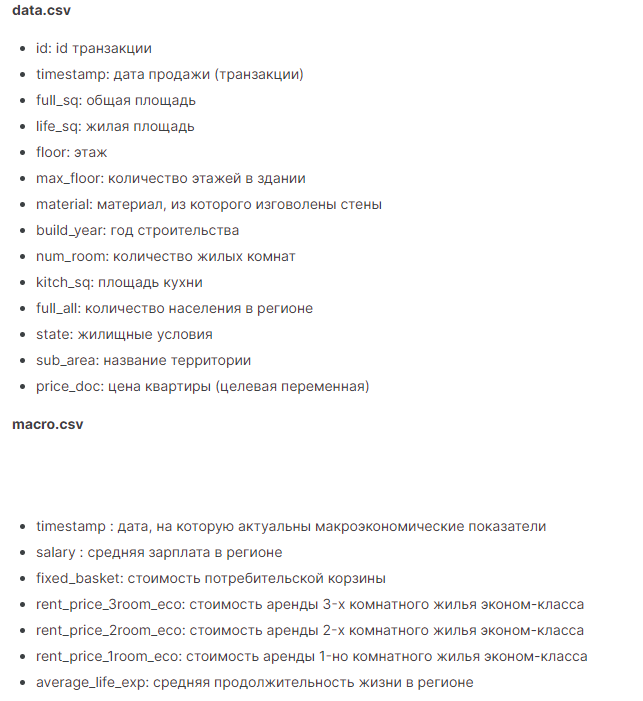

## Импорт библиотек + загрузка данных



In [1]:
import numpy as np
import pandas as pd
import datetime
import re

from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from lazypredict.Supervised import LazyRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit
import lazypredict
from sklearn.model_selection import cross_validate
import joblib
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
SEED = 666

In [3]:
macro = pd.read_csv('macro.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1.EDA + заполнение пропусков + работа с выбросами



In [4]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15092 entries, 0 to 15091
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15092 non-null  int64  
 1   timestamp   15092 non-null  object 
 2   full_sq     15092 non-null  int64  
 3   life_sq     13828 non-null  float64
 4   floor       15069 non-null  float64
 5   state       12366 non-null  float64
 6   max_floor   13938 non-null  float64
 7   material    13938 non-null  float64
 8   build_year  13475 non-null  object 
 9   num_room    13938 non-null  float64
 10  kitch_sq    13938 non-null  float64
 11  full_all    15092 non-null  int64  
 12  sub_area    15092 non-null  object 
 13  price_doc   15092 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------

(None, None)

In [5]:
train.duplicated().unique(), test.duplicated().unique()

(array([False]), array([False]))

Дубликатов не обнаружено

Из явных проблем : 1)Присутствуют нечисловые признаки. 2)Имеется наличие nan-ов


## 1)Приведение всех типов данных к числовым + заполнение пропусков + обработка выбросов

### timestamp

In [6]:
train.timestamp = train.timestamp.apply(lambda x: pd.to_datetime(x))
test.timestamp = test.timestamp.apply(lambda x: pd.to_datetime(x))


<AxesSubplot:>

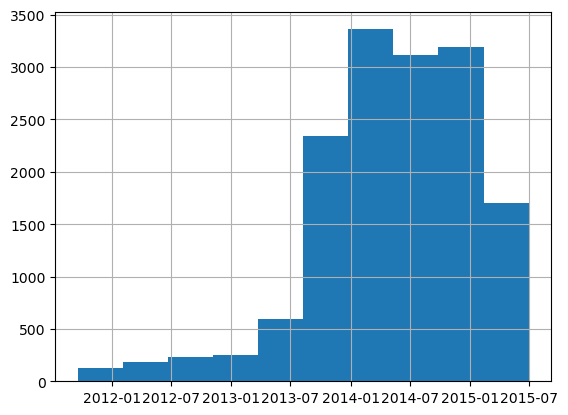

In [ ]:
train.timestamp.hist()

<AxesSubplot:>

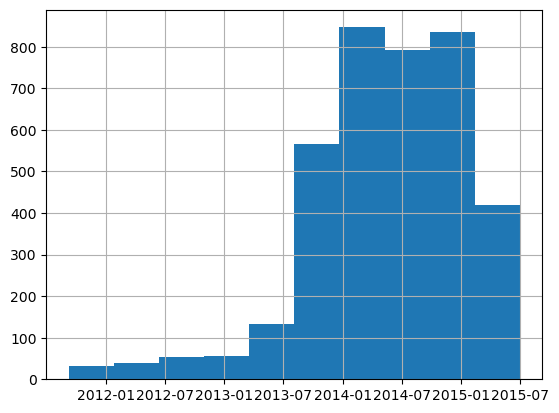

In [ ]:
test.timestamp.hist()

Выбросов и аномалий не наблюдается

### build_year

train

In [11]:
train.build_year.unique() #Проверяем всевозможные значения в колонке build_year

array(['1969.0', '1960.0', '1985.0', '2017.0', '2006.0', '1970.0',
       '1986.0', '1984.0', '2013.0', '1980.0', '2014.0', '1993.0',
       '1997.0', '1981.0', '1964.0', '1979.0', '2004.0', '0.0', '1994.0',
       nan, '1972.0', '1.0', '2010.0', '2012.0', '1976.0', '2000.0',
       '1966.0', '2015.0', '1989.0', '1987.0', '1932.0', '1977.0',
       '1983.0', '1962.0', '2008.0', '2003.0', '1965.0', '1990.0',
       '1971.0', '1978.0', '1974.0', '1961.0', '2016.0', '1959.0',
       '1975.0', '1957.0', '1968.0', '1992.0', '1967.0', '1956.0',
       '1995.0', '1988.0', '1958.0', '1973.0', '1999.0', '2005.0',
       '2002.0', '2007.0', '2001.0', '1982.0', '1950.0', '2011.0',
       '1951.0', '1955.0', '1991.0', '1952.0', '1963.0', '2009.0',
       '1998.0', '1890.0', '1954.0', '1927.0', '1917.0', '1930.0',
       '1937.0', '1996.0', '1929.0', '1910.0', '1926.0', '1928.0',
       '1953.0', '1912.0', '1947.0', '1931.0', '1938.0', '1940.0', '20.0',
       '1915.0', '1933.0', '1934.0', '1936.0'

In [12]:
year_build_unique_bad = [x for x in train.build_year.unique() if len(str(x)) < 6 or len(str(x)) > 6] #составляем список "плохих значений"
year_build_unique_bad

['0.0', nan, '1.0', '20.0', '20052009.0', 'o', '215.0', '71.0', '3.0']

In [13]:
sum = 0
for year in year_build_unique_bad:
  values_count = train[train.build_year == year].build_year.count()
  print(f'Плохой "год" - {year}, значений с плохим "годом" {values_count}')
  sum += values_count
print('Кол-во плохих значений всего ' + str(sum))

year_build_median = train[(train.build_year.isin(year_build_unique_bad) == False) & (train.build_year.isnull() == False)].build_year.map(float).median()
year_build_mode = train[train.build_year.isin(year_build_unique_bad) == False].build_year.map(float).mode().iloc[0]
year_build_mean = train[train.build_year.isin(year_build_unique_bad) == False].build_year.map(float).mean()

n = '\n'
print(f'Среднее значение года постройки - {year_build_mean}{n}Мода - {year_build_mode}{n}Медиана - {year_build_median}')

train.build_year = train.build_year.apply(lambda x: year_build_median if x in year_build_unique_bad else float(x)) #заменяем плохие значения на медианное значение

Плохой "год" - 0.0, значений с плохим "годом" 416
Плохой "год" - nan, значений с плохим "годом" 0
Плохой "год" - 1.0, значений с плохим "годом" 295
Плохой "год" - 20.0, значений с плохим "годом" 1
Плохой "год" - 20052009.0, значений с плохим "годом" 1
Плохой "год" - o, значений с плохим "годом" 1
Плохой "год" - 215.0, значений с плохим "годом" 1
Плохой "год" - 71.0, значений с плохим "годом" 1
Плохой "год" - 3.0, значений с плохим "годом" 1
Кол-во плохих значений всего 717
Среднее значение года постройки - 1985.3288916758113
Мода - 2014.0
Медиана - 1981.0


In [14]:
test[test.build_year == 1896]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area


test


In [15]:
test.build_year.unique() #Проверяем всевозможные значения в колонке build_year

array([      nan, 1.969e+03, 1.970e+03, 2.003e+03, 1.965e+03, 1.966e+03,
       1.928e+03, 1.982e+03, 1.959e+03, 1.978e+03, 1.964e+03, 1.985e+03,
       1.983e+03, 2.004e+03, 1.986e+03, 1.960e+03, 1.952e+03, 1.988e+03,
       1.961e+03, 1.987e+03, 2.014e+03, 1.996e+03, 1.981e+03, 1.976e+03,
       2.010e+03, 1.962e+03, 2.015e+03, 1.984e+03, 1.000e+00, 1.995e+03,
       2.007e+03, 1.974e+03, 2.005e+03, 1.967e+03, 1.939e+03, 2.013e+03,
       1.968e+03, 1.979e+03, 1.973e+03, 2.009e+03, 0.000e+00, 1.963e+03,
       1.972e+03, 1.994e+03, 1.958e+03, 1.998e+03, 1.980e+03, 2.012e+03,
       2.016e+03, 2.008e+03, 1.975e+03, 2.006e+03, 1.971e+03, 1.900e+03,
       1.997e+03, 2.017e+03, 1.935e+03, 1.991e+03, 1.957e+03, 1.977e+03,
       1.924e+03, 1.993e+03, 1.992e+03, 1.917e+03, 1.989e+03, 1.936e+03,
       1.956e+03, 1.915e+03, 1.990e+03, 1.999e+03, 2.002e+03, 1.954e+03,
       2.011e+03, 1.949e+03, 1.912e+03, 2.001e+03, 2.000e+03, 1.933e+03,
       1.955e+03, 1.932e+03, 1.940e+03, 1.926e+03, 

<AxesSubplot:>

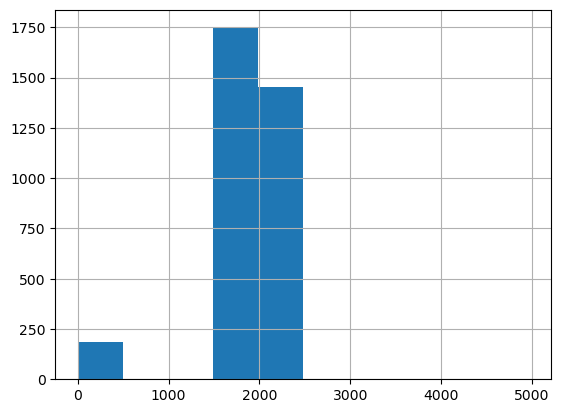

In [16]:
test.build_year.hist() ## Визуализация для поиска выбросов

Видны выбросы в виде экстремально низких значений, а также, раз график построился аж до 5000 значения, то присутсвуют и экстремально высокие значения

Медианный год постройки на тестовых данных - 1982.0


<AxesSubplot:>

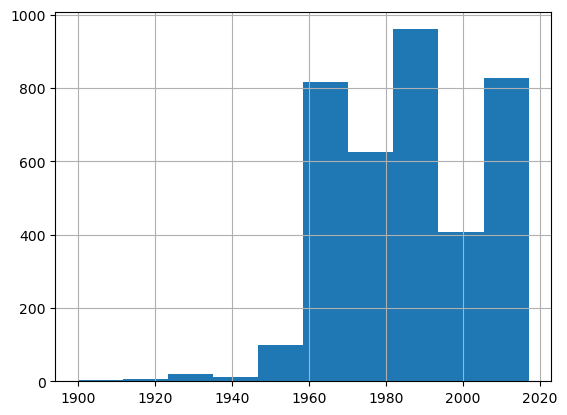

In [17]:
test_year_build_median = test[test.build_year > 1900].build_year.median()
print(f'Медианный год постройки на тестовых данных - {test_year_build_median}')

test.build_year = test.build_year.fillna(test_year_build_median) #заполняем наны медианным значением
test.build_year = test.build_year.apply(lambda x: test_year_build_median if x < 1900 or x > 2023 else x) # заменяем выбросы медианным значением

test.build_year.hist() ## Визуализация после обработки нанов и выбросов

### full_sq

train

In [18]:
train.full_sq.unique() #поиск плохих значений

array([  42,   55,   43,   62,   80,   32,   37,   51,   79,   75,   77,
         36,   38,   73,   59,   34,   90,   30,   44,   66,    1,  117,
         94,  150,   31,   58,   76,   84,   68,   39,   74,  102,   56,
         41,   45,  109,   61,  133,   50,   57,   25,   54,   97,   49,
         33,   47,   52,   35,   46,   82,   63,   88,   72,   67,   89,
         53,   28,   64,   83,   87,  110,   85,  107,  138,   86,   60,
         81,   17,  186,   65,   40,   29,   78,  132,  103,   20,   91,
        120,   48,   71,   69,  134,  101,  106,   98,  104,   27,   99,
        135,   19,  114,   96,  136,   92,   24,   70,  121,   93,  126,
         95,  137,  105,   14,  100,  143,  112,  131,  127,   26,   13,
        170,  119,  124,  144,  113,  116,  160,  139,   12,  123,   18,
        115,  108,  128,  146,  151,  125,   21,  183,  111,  148,   23,
        197,   22,   15,  159,  199,  167,   16,  122,  165,  157,  412,
        142,  219,  176,  129,  155,    0,  158,  2

<AxesSubplot:>

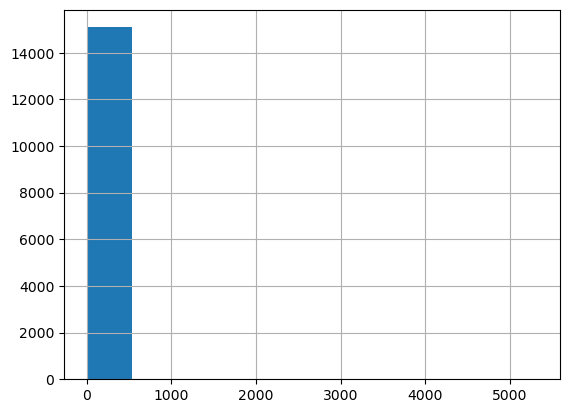

In [19]:
train.full_sq.hist()  ## Визуализация для поиска выбросов

In [20]:
question_full_sq = train[(train.full_sq > 400) | (train.full_sq < 10)] ## используя здарвый смысл удаляем объекты с слишком большой/маленькой площадью жилья
train = train.drop(question_full_sq.index).reset_index(drop=True)

<AxesSubplot:>

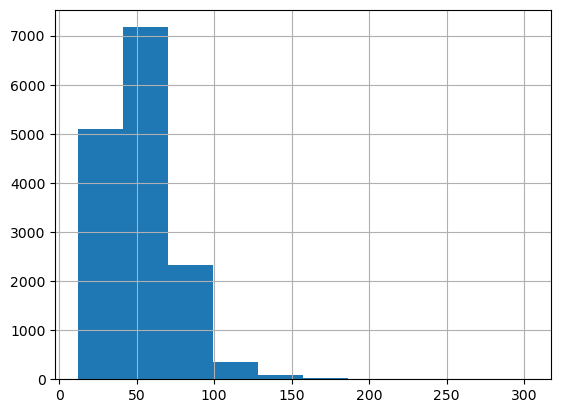

In [21]:
train.full_sq.hist()  ## Визуализация после удаления выбросов

test

In [22]:
test.full_sq.unique() ## поиск плохих значений

array([ 51,  44,  32,  31,  37,  33,  64,  34,  28,  41,  66,  77,  73,
        43,  48,  79,  74,  38,  39,  53,  61,  62,  56,  58,  76,  52,
        30,  60,  54,  36, 131,  84,  45,  50,  35,  29,  59,  55,  94,
        72, 106,  75,  40, 118,  87,  65,  67,  57, 151,  63, 121,  78,
        46,  71,  26, 116,  80,  70,  69,  81, 100,  42,  82,  47,  49,
       219, 113,  27,  23,  16, 101,  22, 195, 134,  93, 105,  85,  86,
       148,  18, 103,  97,  95, 102,  68,  99,  25,  88,  96, 138, 112,
       108,  83, 143, 407,  14, 107,  98,  89, 172, 110, 165, 202, 122,
       124, 141,  92, 111,  90,  91, 115, 133, 170,  20, 119, 150, 135,
       161, 129,   1, 117, 184, 146,  15, 114, 187, 155, 154, 183, 160,
       179, 206,  11, 120,   5,  21, 109, 145], dtype=int64)

<AxesSubplot:>

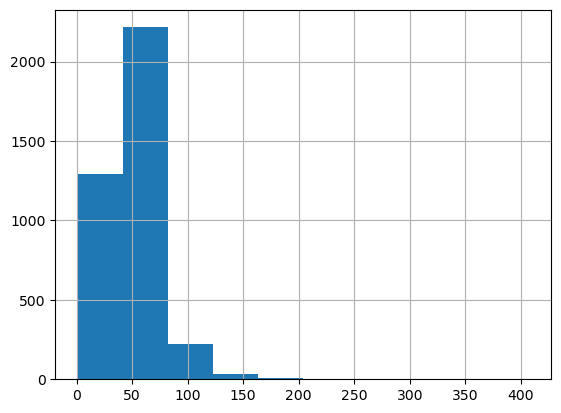

In [23]:
test.full_sq.hist()

### life_sq

train

In [24]:
train.life_sq.unique() #Проверяем всевозможные значения в колонке life_sq

array([ 28.,  41.,  29.,  35.,  55.,  18.,  19.,  40.,  77.,  44.,  75.,
        20.,  32.,  48.,   0.,  46.,  66.,  nan,  43.,  52.,  80.,  37.,
        45.,  62.,  30.,  23.,  63.,  34.,  50.,  22.,  36.,  79.,  74.,
        14.,  42.,  31.,  59.,  69.,  27.,  47.,   1.,  15.,  17.,  51.,
        54.,  21.,  73.,  16.,  64.,  38.,  33., 107.,  89.,  39.,  26.,
        76.,  70.,  49.,  81.,  53.,  13.,  60.,  86.,  56.,  57.,  58.,
       103.,  87.,  82.,  93.,  71., 134.,  10.,  83.,  25.,  24.,  61.,
        12.,  96.,  65.,  94.,  85., 121.,  78., 136.,  68.,  91., 104.,
         8., 112., 108., 458., 102., 113., 349., 160.,   9.,  67.,   7.,
        72.,  11., 435., 146.,  98., 125.,  97., 148., 114.,  95.,  88.,
       197.,  84., 101., 159., 116., 157.,  99., 122., 163., 100., 259.,
       133., 158., 117., 165., 120., 110., 115., 126., 179., 123.,  90.,
       232.,  92., 139., 149., 144., 106., 118., 124., 209., 301., 105.,
       174., 138., 119., 162., 145., 176., 142., 16

<AxesSubplot:>

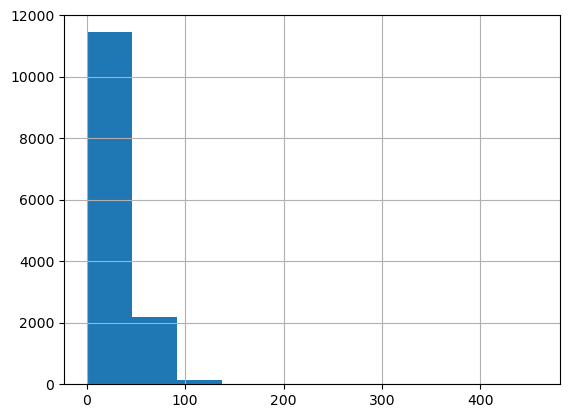

In [25]:
train.life_sq.hist()  ## Визуализация для поиска выбросов

In [26]:
train.life_sq.isnull().value_counts()

False    13803
True      1264
Name: life_sq, dtype: int64

Заполним пропуски значением, которое определяется 80% площади full_sq


In [27]:
for i in range(train.life_sq.shape[0]):
  if train.life_sq.iloc[i] < 20:
    train.at[i, 'life_sq'] = train.at[i, 'full_sq'] * 0.8  ## заменим экстремально низкие значения

In [28]:
train.life_sq.fillna(train.full_sq * 0.8,inplace=True) # Заполняем наны
train.life_sq.isnull().value_counts()

False    15067
Name: life_sq, dtype: int64

<AxesSubplot:>

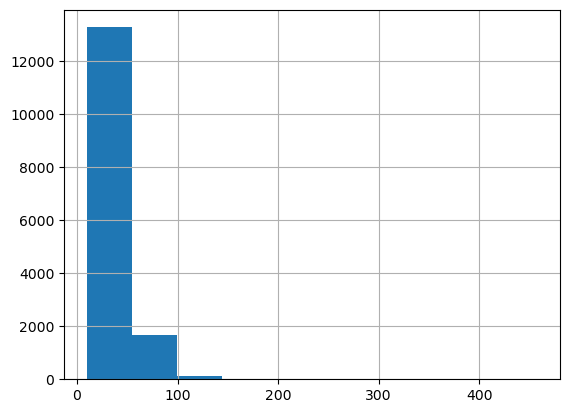

In [29]:
train.life_sq.hist()

test

In [30]:
test.life_sq.unique() #Проверяем всевозможные значения в колонке life_sq

array([3.100e+01, 2.900e+01, 1.800e+01, 3.000e+01, 2.800e+01, 2.100e+01,
       1.700e+01,       nan, 4.300e+01, 1.900e+01, 4.400e+01, 1.100e+01,
       2.600e+01, 4.600e+01, 3.800e+01, 2.700e+01, 1.400e+01, 4.100e+01,
       2.000e+01, 3.200e+01, 5.100e+01, 3.300e+01, 5.800e+01, 4.500e+01,
       1.000e+00, 3.400e+01, 2.300e+01, 1.180e+02, 2.400e+01, 8.400e+01,
       4.200e+01, 7.400e+01, 3.700e+01, 5.200e+01, 1.600e+01, 5.600e+01,
       3.900e+01, 5.500e+01, 6.700e+01, 5.900e+01, 7.600e+01, 2.500e+01,
       8.200e+01, 3.500e+01, 6.200e+01, 1.500e+01, 5.400e+01, 4.700e+01,
       5.000e+01, 7.700e+01, 6.600e+01, 3.600e+01, 9.000e+00, 7.000e+01,
       4.800e+01, 6.100e+01, 2.200e+01, 4.900e+01, 4.000e+01, 6.400e+01,
       6.300e+01, 7.800e+01, 5.700e+01, 5.300e+01, 6.800e+01, 8.100e+01,
       1.190e+02, 7.200e+01, 7.300e+01, 9.700e+01, 8.500e+01, 6.000e+01,
       8.600e+01, 6.500e+01, 7.900e+01, 9.500e+01, 8.700e+01, 9.000e+01,
       0.000e+00, 7.500e+01, 1.030e+02, 8.000e+01, 

In [31]:
test.life_sq.describe()

count   3463.00
mean      36.15
std      127.97
min        0.00
25%       20.00
50%       30.00
75%       43.00
max     7478.00
Name: life_sq, dtype: float64

<AxesSubplot:>

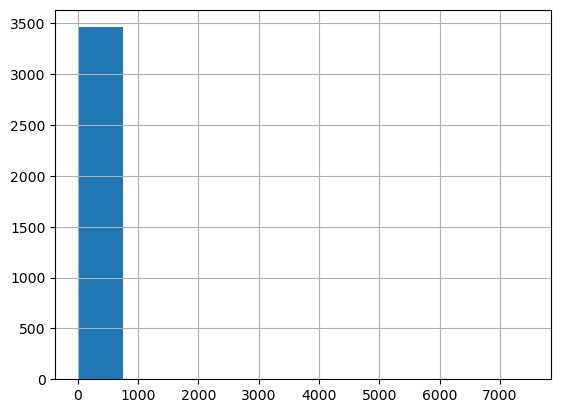

In [32]:
test.life_sq.hist()  ## Визуализация для поиска выбросов

Очевидны выбросы

In [33]:
test[test.life_sq > 100]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area
58,15699,2014-03-04,131,118.00,10.00,1.00,39.00,4.00,2009.00,1.00,3.00,116742,Tverskoe
272,17713,2014-04-22,219,118.00,31.00,1.00,48.00,4.00,2010.00,3.00,4.00,102726,Jakimanka
363,28958,2015-04-07,195,119.00,1.00,1.00,2.00,4.00,2010.00,5.00,10.00,5740,Poselenie Pervomajskoe
908,29436,2015-04-27,103,103.00,15.00,1.00,25.00,6.00,1982.00,4.00,12.00,7341,Poselenie Moskovskij
968,27796,2015-02-09,407,407.00,4.00,1.00,4.00,4.00,2015.00,1.00,10.00,112804,Filevskij Park
1331,6002,2013-02-12,165,165.00,11.00,NaN,NaN,NaN,1982.00,NaN,NaN,90114,Teplyj Stan
1351,28700,2015-03-30,101,101.00,10.00,1.00,10.00,1.00,1982.00,3.00,1.00,13890,Poselenie Sosenskoe
1416,19931,2014-06-21,124,124.00,24.00,1.00,24.00,1.00,2015.00,3.00,19.00,81887,Hovrino
1438,24720,2014-11-13,141,141.00,3.00,1.00,3.00,4.00,2012.00,3.00,10.00,143661,Troickij okrug
1520,26869,2014-12-19,111,111.00,11.00,1.00,15.00,6.00,2016.00,3.00,17.00,7341,Poselenie Moskovskij


Нашелся один такой выброс с life_sq 7478.00, очевидно опечатка, просто поделим это значение на 100, учитывая full_sq 78

In [34]:
test.life_sq = test.life_sq.replace([7478.00], 7478.00/100)

In [35]:
test.iloc[1746].life_sq

74.78

<AxesSubplot:>

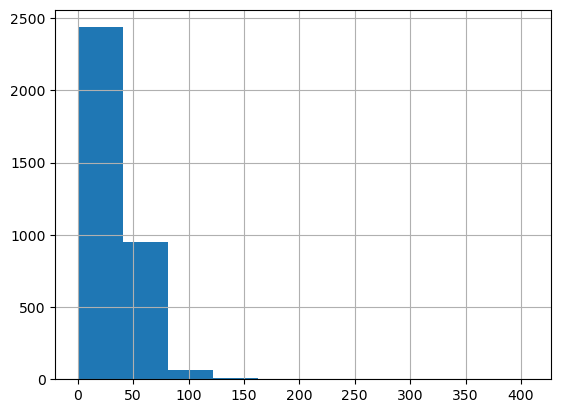

In [36]:
test.life_sq.hist()  ## Визуализация после работы над выбросами

In [37]:
test.life_sq.fillna(test.full_sq * 0.8,inplace=True) # заполняем наны
test.life_sq.isnull().value_counts()

False    3774
Name: life_sq, dtype: int64

### floor

train

In [38]:
train.floor.unique() #Проверяем всевозможные значения в колонке floor

array([ 8.,  4., 15., 19.,  1.,  7.,  6.,  5.,  9., 10., 11., 12.,  3.,
       16., 13., 20., 22.,  2., 14., 18., 23., 17., 37., 26., 24., nan,
       25., 21., 27., 34., 28., 77., 41., 32., 31., 33.,  0., 36., 30.,
       44.])

In [39]:
train[train.floor == 44]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc
13138,30314,2015-06-18,65,39.00,44.00,4.00,48.00,4.00,2000.00,2.00,5.00,102726,Jakimanka,8857680


Учитывая Max_floor не похоже, чтобы это значение было выбросом

In [40]:
train.floor.median()

6.0

In [41]:
train.floor.fillna(train.floor.median(),inplace=True) # заполняем наны медианным значением

test

In [42]:
test.floor.fillna(test.floor.median(),inplace=True) # заполняем наны медианным значением

### state


train

In [43]:
train.state.unique()

array([ 2.,  3., nan,  1.,  4., 33.])

<AxesSubplot:>

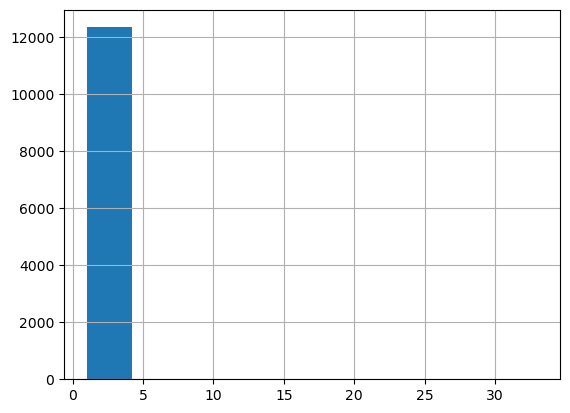

In [44]:
train.state.hist()

Выбросы очевидны

In [45]:
train.state.mode(), train.state.median() 

(0   2.00
 Name: state, dtype: float64,
 2.0)

не прогадаем если заполним nan-ы на 2.0

In [46]:
train.state = train.state.replace([33.00], 2.0)

In [47]:
train.state.fillna(2.0,inplace=True)

<AxesSubplot:>

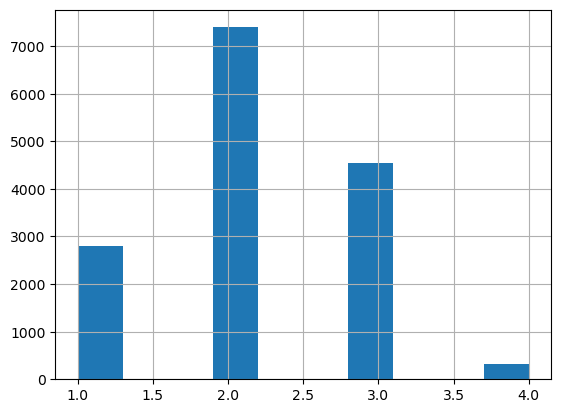

In [48]:
train.state.hist()

test

In [49]:
test.state.unique()

array([nan,  3.,  1.,  2.,  4.])

In [50]:
test.state.mode(), test.state.median() 

(0   3.00
 Name: state, dtype: float64,
 2.0)

In [51]:
test.state.fillna(2.0,inplace=True) # заполним тем же, чем заполняли train

<AxesSubplot:>

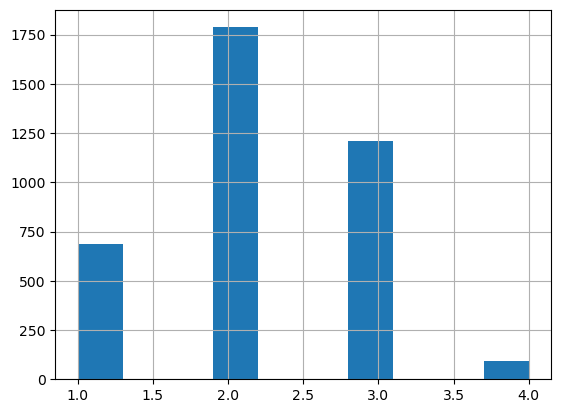

In [52]:
test.state.hist()

### max_floor

train

In [53]:
train.max_floor.unique()

array([ 9.,  5., 22., 24., 23., 17., 16.,  6., 14., 12., 20., nan, 27.,
        0., 13., 25., 40., 18., 10.,  1.,  8.,  2., 19.,  4.,  3., 15.,
       38., 30., 21.,  7., 36., 29., 26., 32., 11., 28., 37., 39., 34.,
       48., 47., 41., 57., 42., 33., 31.])

In [54]:
train[train.max_floor > 40]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc
4073,21609,2014-08-18,74,38.00,41.00,3.00,48.00,4.00,2013.00,2.00,5.00,102726,Jakimanka,14500000
4308,15108,2014-02-17,126,103.00,20.00,1.00,47.00,4.00,2012.00,1.00,14.00,61039,Ramenki,16000000
4317,29712,2015-05-14,116,98.00,11.00,1.00,41.00,4.00,2011.00,1.00,8.00,116742,Tverskoe,3700000
8422,26668,2014-12-17,126,98.00,31.00,1.00,48.00,6.00,2003.00,1.00,17.00,166803,Shhukino,41500000
9552,24023,2014-10-28,135,59.00,9.00,4.00,57.00,4.00,2007.00,3.00,22.00,80791,Horoshevskoe,56500000
11290,19420,2014-06-06,71,38.00,36.00,3.00,48.00,4.00,2010.00,2.00,5.00,102726,Jakimanka,18700000
11691,18865,2014-05-26,94,79.00,18.00,1.00,42.00,4.00,2010.00,1.00,4.00,116742,Tverskoe,5588313
13138,30314,2015-06-18,65,39.00,44.00,4.00,48.00,4.00,2000.00,2.00,5.00,102726,Jakimanka,8857680
13675,20490,2014-07-01,125,74.00,34.00,1.00,48.00,4.00,2011.00,3.00,17.00,155427,Horoshevo-Mnevniki,16200000


Не похоже на выбросы

In [55]:
train.max_floor.median()

12.0

Заполним пропуски медианным значением

In [56]:
train.max_floor.fillna(train.max_floor.median(),inplace=True)

<AxesSubplot:>

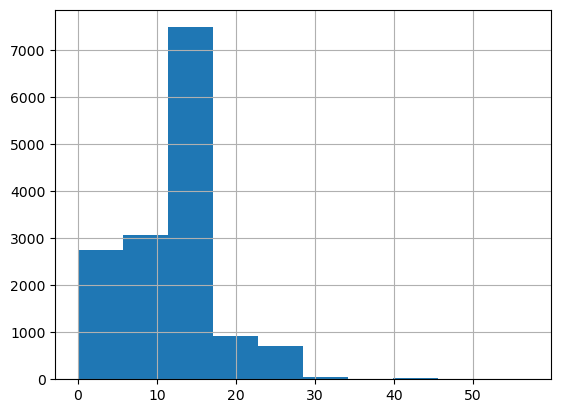

In [57]:
train.max_floor.hist()

test

In [58]:
test.max_floor.median()

12.0

In [59]:
test.max_floor.fillna(test.max_floor.median(),inplace=True)

### material

train

In [60]:
train.material.unique()

array([ 1.,  2.,  6.,  4.,  5., nan,  3.])

In [61]:
train.material.mode(), train.material.median()

(0   1.00
 Name: material, dtype: float64,
 1.0)

In [62]:
train.material.fillna(1.00,inplace=True) #не промахнемся

test

In [63]:
test.material.unique()

array([nan,  1.,  5.,  2.,  4.,  6.])

In [64]:
test.material.mode()

0   1.00
Name: material, dtype: float64

In [65]:
test.material.fillna(1.00,inplace=True)

### num_rum

train

In [66]:
train.num_room.unique()

array([ 2.,  3.,  1., nan,  4., 10.,  6.,  5.,  0., 17., 19.,  9.,  8.])

Средняя площадь комнаты в мск - 17.3 кв.м., применим это значение для замены в выбросах

<AxesSubplot:>

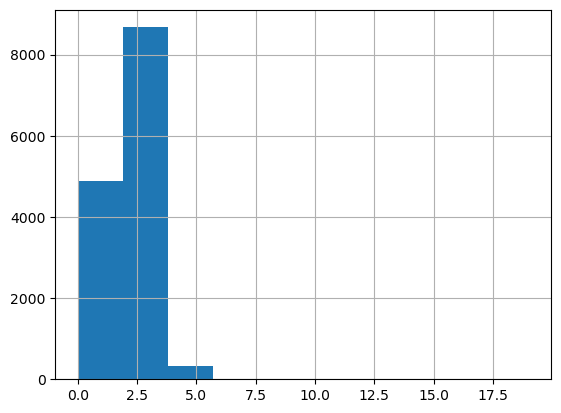

In [67]:
train.num_room.hist()

In [68]:
for i in range(train.num_room.shape[0]):
  if train.num_room.iloc[i] > 10 or pd.isnull(train.num_room.iloc[i]):
    train.at[i, 'num_room'] = int(train.at[i, 'life_sq'] / 17.3)  ## заменяем наны и аномальное количество комнат на число, которое определяется как жилая площадь деленная на ср. площадь комнаты мск.

In [69]:
train.num_room = train.num_room.apply(lambda x : 1 if x == 0 else x) ## заменим нулевые значения на единицу

<AxesSubplot:>

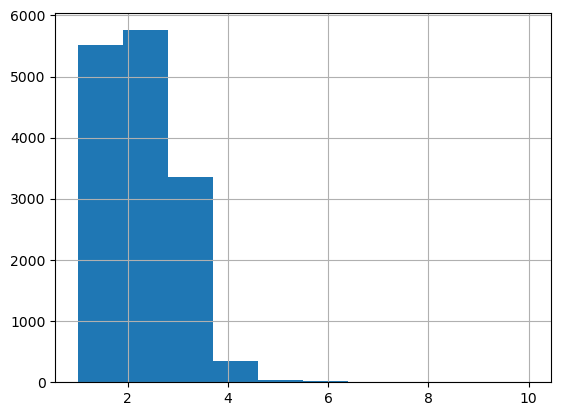

In [70]:
train.num_room.hist()

test

In [71]:
test.num_room.unique()

array([nan,  2.,  1.,  3.,  4.,  0.,  5.,  6.,  8.,  7.])

<AxesSubplot:>

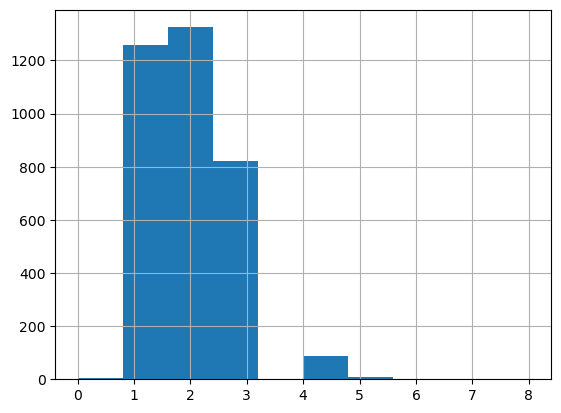

In [72]:
test.num_room.hist()

In [73]:
for i in range(test.num_room.shape[0]):
  if test.num_room.iloc[i] > 8 or pd.isnull(test.num_room.iloc[i]):
    test.at[i, 'num_room'] = int(test.at[i, 'life_sq'] / 17.3)  ## заменяем количество комнат на число, которое определяется как жилая площадь деленная на ср. площадь комнаты мск.

test.num_room = test.num_room.apply(lambda x : 1 if x == 0 else x) ## заменим нулевые значения на единицу

<AxesSubplot:>

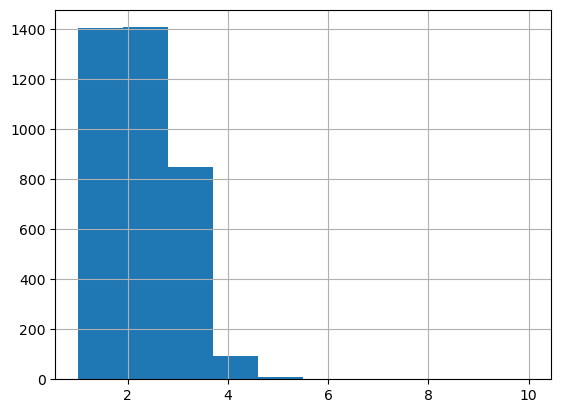

In [74]:
test.num_room.hist()

### kitch_sq

train

In [75]:
train.kitch_sq.unique()

array([6.000e+00, 5.000e+00, 1.000e+01, 1.200e+01, 7.000e+00, 9.000e+00,
       1.000e+00, 1.100e+01, 8.000e+00, 0.000e+00,       nan, 2.500e+01,
       4.000e+00, 1.400e+01, 2.400e+01, 1.600e+01, 1.700e+01, 4.200e+01,
       3.700e+01, 3.200e+01, 1.300e+01, 1.800e+01, 1.900e+01, 3.000e+00,
       2.000e+01, 6.100e+01, 4.000e+01, 1.500e+01, 4.300e+01, 3.300e+01,
       1.120e+02, 2.300e+01, 6.300e+01, 2.800e+01, 2.000e+00, 4.100e+01,
       2.100e+01, 3.000e+01, 2.200e+01, 9.600e+01, 3.900e+01, 2.014e+03,
       4.800e+01, 5.800e+01, 3.600e+01, 5.100e+01, 1.230e+02, 2.600e+01,
       6.200e+02, 8.600e+01, 7.200e+01, 5.300e+01, 3.100e+01, 6.000e+01,
       4.400e+01, 3.400e+01, 8.400e+01, 1.974e+03, 2.900e+01, 6.600e+01,
       6.500e+01, 2.700e+01, 5.700e+01, 2.013e+03])

<AxesSubplot:>

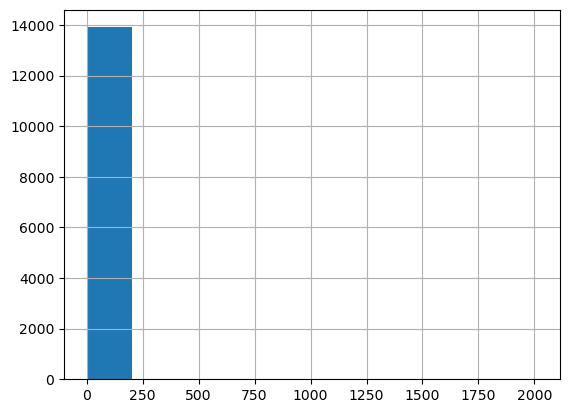

In [76]:
train.kitch_sq.hist()

Очевидны выбросы

In [77]:
temp = ['life_sq','kitch_sq']
temp

['life_sq', 'kitch_sq']

Вычисляем средний процент, который составляет кухня от общей площади

In [78]:
(train[temp].drop(train[(train.kitch_sq > 50) | (train.kitch_sq < 5)].index).kitch_sq / train[temp].drop(train[(train.kitch_sq > 50) | (train.kitch_sq < 5)].index).life_sq).mean()

0.24728113921734787

In [79]:
train.kitch_sq.isnull().value_counts()

False    13915
True      1152
Name: kitch_sq, dtype: int64

In [80]:
for i in range(train.kitch_sq.shape[0]):
  if train.kitch_sq.iloc[i] < 5 or train.kitch_sq.iloc[i] > 50 or np.isnan(train.kitch_sq.iloc[i]):
    train.at[i, 'kitch_sq'] = train.at[i, 'life_sq'] * 0.24728113921734787  #заменяем наны и выбросы на жилая площадь*0.24728113921734787

In [81]:
train.kitch_sq.isnull().value_counts()

False    15067
Name: kitch_sq, dtype: int64

<AxesSubplot:>

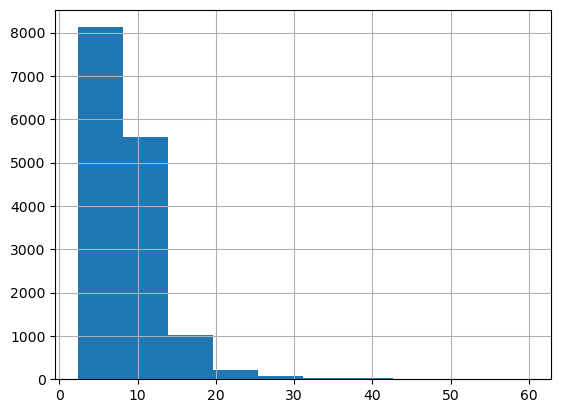

In [82]:
train.kitch_sq.hist()

test

In [83]:
test.kitch_sq.unique()

array([nan,  5.,  6.,  9.,  0.,  8.,  7.,  4., 10., 12.,  1., 13., 62.,
        3., 11., 16., 14., 19., 15., 33., 23.,  2., 20., 18., 24., 35.,
       22., 37., 17., 78., 51., 97., 31., 54., 74., 39., 32., 57., 95.,
       29., 60., 73.])

In [84]:
test.kitch_sq.isnull().value_counts()

False    3507
True      267
Name: kitch_sq, dtype: int64

In [85]:
for i in range(test.kitch_sq.shape[0]):
  if test.kitch_sq.iloc[i] < 5 or test.kitch_sq.iloc[i] > 50 or np.isnan(test.kitch_sq.iloc[i]):
    test.at[i, 'kitch_sq'] = test.at[i, 'life_sq'] * 0.24728113921734787  #заменяем наны и выбросы на жилая площадь*0.24728113921734787

In [86]:
test.kitch_sq.isnull().value_counts()

False    3774
Name: kitch_sq, dtype: int64

<AxesSubplot:>

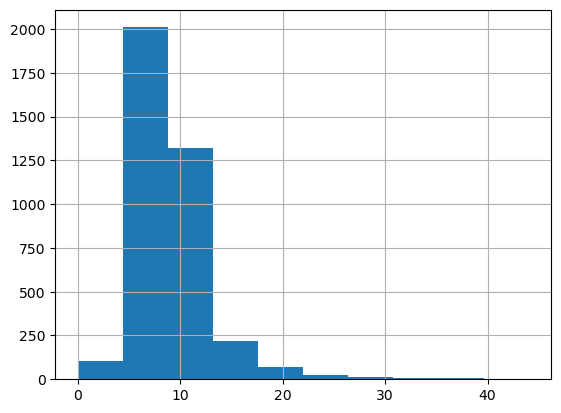

In [87]:
test.kitch_sq.hist()

In [88]:
cm = sns.color_palette("vlag", as_cmap=True)

train.corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,id,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,price_doc
id,1.000000,0.041110,0.040037,-0.012086,-0.039857,0.039598,0.103299,0.101903,0.045792,0.033111,-0.003979,0.085503
full_sq,0.041110,1.000000,0.794075,0.164003,-0.080513,0.166924,0.038116,0.232428,0.760473,0.639322,-0.033344,0.654409
life_sq,0.040037,0.794075,1.000000,0.151196,-0.259076,0.107342,0.016557,0.267136,0.572426,0.698070,-0.075051,0.463326
floor,-0.012086,0.164003,0.151196,1.000000,-0.079432,0.485934,0.011635,0.338669,0.015845,0.247285,-0.021988,0.144158
state,-0.039857,-0.080513,-0.259076,-0.079432,1.000000,-0.033105,-0.050812,-0.288047,0.067687,-0.284499,0.083366,0.106456
max_floor,0.039598,0.166924,0.107342,0.485934,-0.033105,1.000000,0.064374,0.509216,-0.016401,0.247713,-0.004902,0.133500
material,0.103299,0.038116,0.016557,0.011635,-0.050812,0.064374,1.000000,0.022122,-0.024179,0.048320,0.026447,0.065176
build_year,0.101903,0.232428,0.267136,0.338669,-0.288047,0.509216,0.022122,1.000000,-0.054325,0.446079,-0.072586,0.040357
num_room,0.045792,0.760473,0.572426,0.015845,0.067687,-0.016401,-0.024179,-0.054325,1.000000,0.300221,-0.008020,0.485435
kitch_sq,0.033111,0.639322,0.698070,0.247285,-0.284499,0.247713,0.048320,0.446079,0.300221,1.000000,-0.072195,0.335975


### итог

In [ ]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15067 entries, 0 to 15066
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          15067 non-null  int64         
 1   timestamp   15067 non-null  datetime64[ns]
 2   full_sq     15067 non-null  int64         
 3   life_sq     15067 non-null  float64       
 4   floor       15067 non-null  float64       
 5   state       15067 non-null  float64       
 6   max_floor   15067 non-null  float64       
 7   material    15067 non-null  float64       
 8   build_year  15067 non-null  float64       
 9   num_room    15067 non-null  float64       
 10  kitch_sq    15067 non-null  float64       
 11  full_all    15067 non-null  int64         
 12  sub_area    15067 non-null  object        
 13  price_doc   15067 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(4), object(1)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
Rang

(None, None)

с пропусками и выбросами разобрались

## 2)Добавление колонок из таблицы macro в исходные датафреймы

In [89]:
macro.timestamp = macro.timestamp.apply(lambda x: pd.to_datetime(x))
macro

,timestamp,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,2010-01-01,38410.50,11443.63,NaN,NaN,NaN,74.20
1,2010-01-02,38410.50,11443.63,NaN,NaN,NaN,74.20
2,2010-01-03,38410.50,11443.63,NaN,NaN,NaN,74.20
3,2010-01-04,38410.50,11443.63,NaN,NaN,NaN,74.20
4,2010-01-05,38410.50,11443.63,NaN,NaN,NaN,74.20
...,...,...,...,...,...,...,...
2479,2016-10-15,NaN,20354.78,45.71,38.40,29.78,NaN
2480,2016-10-16,NaN,20354.78,45.71,38.40,29.78,NaN
2481,2016-10-17,NaN,20354.78,45.71,38.40,29.78,NaN
2482,2016-10-18,NaN,20354.78,45.71,38.40,29.78,NaN


Принцип следующий: метчим макро показатели по дате с датой транзакции

### salary

train

In [90]:
train['salary'] = train.build_year
for i in range(train.build_year.shape[0]):
  train.at[i, 'salary'] = macro[macro.timestamp == train.timestamp.iloc[i]].salary.iloc[0] ##метчим по дате транзакции и дате, для которой актуальны макро показатели

test


In [91]:
test['salary'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'salary'] = macro[macro.timestamp == test.timestamp.iloc[i]].salary.iloc[0]

### fixed_basket

train

In [92]:
train['fixed_basket'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'fixed_basket'] = macro[macro.timestamp == train.timestamp.iloc[i]].fixed_basket.iloc[0]

test

In [93]:
test['fixed_basket'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'fixed_basket'] = macro[macro.timestamp == test.timestamp.iloc[i]].fixed_basket.iloc[0]

### rent_price_3room_eco

train

In [94]:
train['rent_price_3room_eco'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'rent_price_3room_eco'] = macro[macro.timestamp == train.timestamp.iloc[i]].rent_price_3room_eco.iloc[0]

test

In [95]:
test['rent_price_3room_eco'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'rent_price_3room_eco'] = macro[macro.timestamp == test.timestamp.iloc[i]].rent_price_3room_eco.iloc[0]

### rent_price_2room_eco

train

In [96]:
train['rent_price_2room_eco'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'rent_price_2room_eco'] = macro[macro.timestamp == train.timestamp.iloc[i]].rent_price_2room_eco.iloc[0]

test

In [97]:
test['rent_price_2room_eco'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'rent_price_2room_eco'] = macro[macro.timestamp == test.timestamp.iloc[i]].rent_price_2room_eco.iloc[0]

### rent_price_1room_eco

train

In [98]:
train['rent_price_1room_eco'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'rent_price_1room_eco'] = macro[macro.timestamp == train.timestamp.iloc[i]].rent_price_1room_eco.iloc[0]

test

In [99]:
test['rent_price_1room_eco'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'rent_price_1room_eco'] = macro[macro.timestamp == test.timestamp.iloc[i]].rent_price_1room_eco.iloc[0]

### average_life_exp

train

In [100]:
train['average_life_exp'] = train.build_year

for i in range(train.build_year.shape[0]):
  train.at[i, 'average_life_exp'] = macro[macro.timestamp == train.timestamp.iloc[i]].average_life_exp.iloc[0]

test

In [101]:
test['average_life_exp'] = test.build_year

for i in range(test.build_year.shape[0]):
  test.at[i, 'average_life_exp'] = macro[macro.timestamp == test.timestamp.iloc[i]].average_life_exp.iloc[0]

### Итог

In [102]:
train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,6.00,43795,Pechatniki,7100000,55485.20,15417.34,48.50,42.00,33.97,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,5.00,21040,Dorogomilovo,11500000,55485.20,15241.93,48.22,42.33,33.15,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,5.00,157010,Ivanovskoe,5800000,55485.20,15367.58,49.29,42.02,34.55,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,Jasenevo,11400000,55485.20,15241.93,48.22,42.33,33.15,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,Nagatinskij Zaton,12697154,64310.00,18745.28,50.42,39.16,31.09,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15062,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,7.00,101982,Tekstil'shhiki,9100000,61208.00,16269.79,52.82,43.85,35.37,76.70
15063,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,18.55,247469,Nekrasovka,7722400,61208.00,16269.79,52.82,43.85,35.37,76.70
15064,16165,2014-03-18,38,30.40,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,Juzhnoportovoe,7000000,61208.00,15916.88,49.75,41.91,33.26,76.70
15065,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,Jasenevo,7000000,55485.20,15215.84,49.12,42.10,34.53,76.37


In [103]:
test

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,1417,2012-03-03,51,31.00,16.00,2.00,12.00,1.00,1982.00,1.00,7.67,221709,Krjukovo,48830.40,13243.77,45.31,38.45,31.64,75.74
1,9725,2013-08-08,44,29.00,5.00,3.00,9.00,1.00,1969.00,2.00,5.00,37502,Sviblovo,55485.20,15241.93,48.22,42.33,33.15,76.37
2,30369,2015-06-23,32,18.00,1.00,3.00,9.00,1.00,1970.00,1.00,6.00,125354,Chertanovo Severnoe,64310.00,18720.65,49.01,38.91,30.29,76.77
3,20522,2014-07-02,51,30.00,11.00,1.00,17.00,1.00,2003.00,2.00,9.00,130229,Moskvorech'e-Saburovo,61208.00,16251.41,50.93,41.97,33.67,76.70
4,12891,2013-12-07,44,28.00,4.00,2.00,5.00,1.00,1965.00,2.00,5.00,145576,Caricyno,55485.20,15417.34,48.50,42.00,33.97,76.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,10843,2013-09-30,53,28.00,9.00,3.00,16.00,5.00,1976.00,2.00,11.00,1318695,Vyhino-Zhulebino,55485.20,15215.84,49.12,42.10,34.53,76.37
3770,543,2011-12-06,31,17.00,5.00,2.00,12.00,1.00,1982.00,1.00,4.20,85083,Sokolinaja Gora,44898.70,12992.44,46.44,37.93,30.74,75.79
3771,25332,2014-11-26,38,19.00,8.00,3.00,16.00,1.00,1977.00,1.00,10.00,111023,Ochakovo-Matveevskoe,61208.00,16648.70,53.21,43.23,34.30,76.70
3772,25329,2014-11-26,120,57.00,7.00,3.00,10.00,2.00,1985.00,3.00,11.00,47245,Meshhanskoe,61208.00,16648.70,53.21,43.23,34.30,76.70


Слишком маленькие цифры в колонках про аренду

In [104]:
train.rent_price_3room_eco = train.rent_price_3room_eco * 1000
train.rent_price_2room_eco = train.rent_price_2room_eco * 1000
train.rent_price_1room_eco = train.rent_price_1room_eco * 1000

test.rent_price_3room_eco = test.rent_price_3room_eco * 1000
test.rent_price_2room_eco = test.rent_price_2room_eco * 1000
test.rent_price_1room_eco = test.rent_price_1room_eco * 1000

In [105]:
train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,6.00,43795,Pechatniki,7100000,55485.20,15417.34,48500.00,42000.00,33970.00,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,5.00,21040,Dorogomilovo,11500000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,5.00,157010,Ivanovskoe,5800000,55485.20,15367.58,49290.00,42020.00,34550.00,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,Jasenevo,11400000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,Nagatinskij Zaton,12697154,64310.00,18745.28,50420.00,39160.00,31090.00,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15062,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,7.00,101982,Tekstil'shhiki,9100000,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15063,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,18.55,247469,Nekrasovka,7722400,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15064,16165,2014-03-18,38,30.40,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,Juzhnoportovoe,7000000,61208.00,15916.88,49750.00,41910.00,33260.00,76.70
15065,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,Jasenevo,7000000,55485.20,15215.84,49120.00,42100.00,34530.00,76.37


In [106]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15067 entries, 0 to 15066
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    15067 non-null  int64         
 1   timestamp             15067 non-null  datetime64[ns]
 2   full_sq               15067 non-null  int64         
 3   life_sq               15067 non-null  float64       
 4   floor                 15067 non-null  float64       
 5   state                 15067 non-null  float64       
 6   max_floor             15067 non-null  float64       
 7   material              15067 non-null  float64       
 8   build_year            15067 non-null  float64       
 9   num_room              15067 non-null  float64       
 10  kitch_sq              15067 non-null  float64       
 11  full_all              15067 non-null  int64         
 12  sub_area              15067 non-null  object        
 13  price_doc       

(None, None)

## 3)Предварительная обработка данных

In [ ]:
train.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'state', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq', 'full_all',
       'sub_area', 'price_doc', 'salary', 'fixed_basket',
       'rent_price_3room_eco', 'rent_price_2room_eco', 'rent_price_1room_eco',
       'average_life_exp'],
      dtype='object')

### Визуализируем распределение данных

array([[<AxesSubplot:title={'center':'salary'}>,
        <AxesSubplot:title={'center':'fixed_basket'}>,
        <AxesSubplot:title={'center':'rent_price_3room_eco'}>,
        <AxesSubplot:title={'center':'rent_price_2room_eco'}>,
        <AxesSubplot:title={'center':'rent_price_1room_eco'}>]],
      dtype=object)

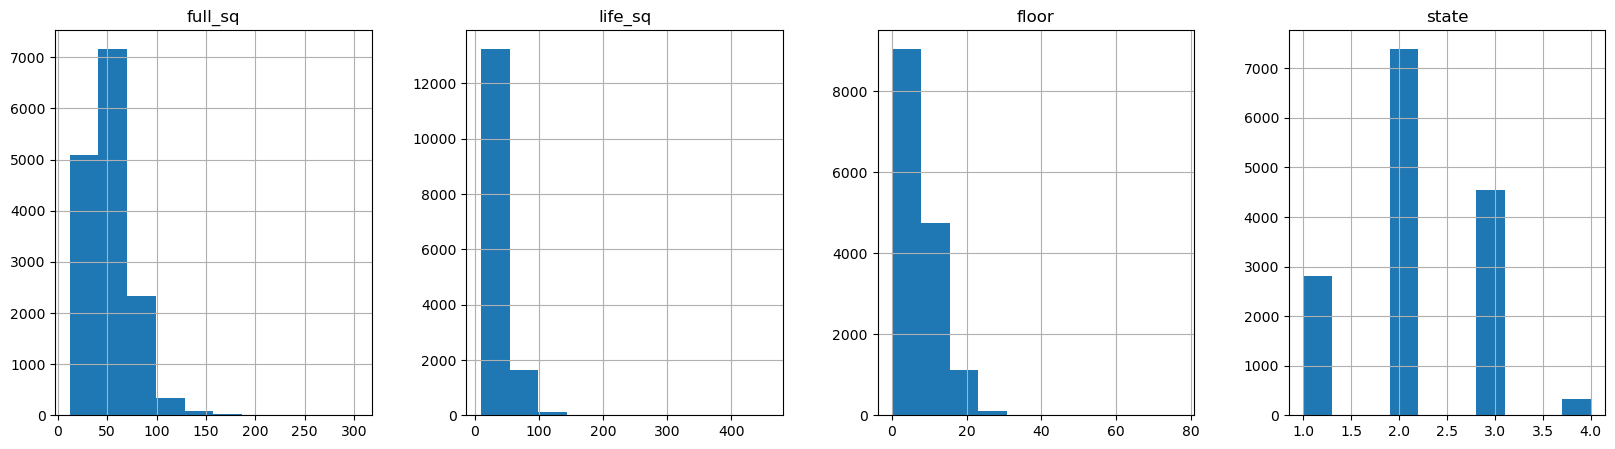

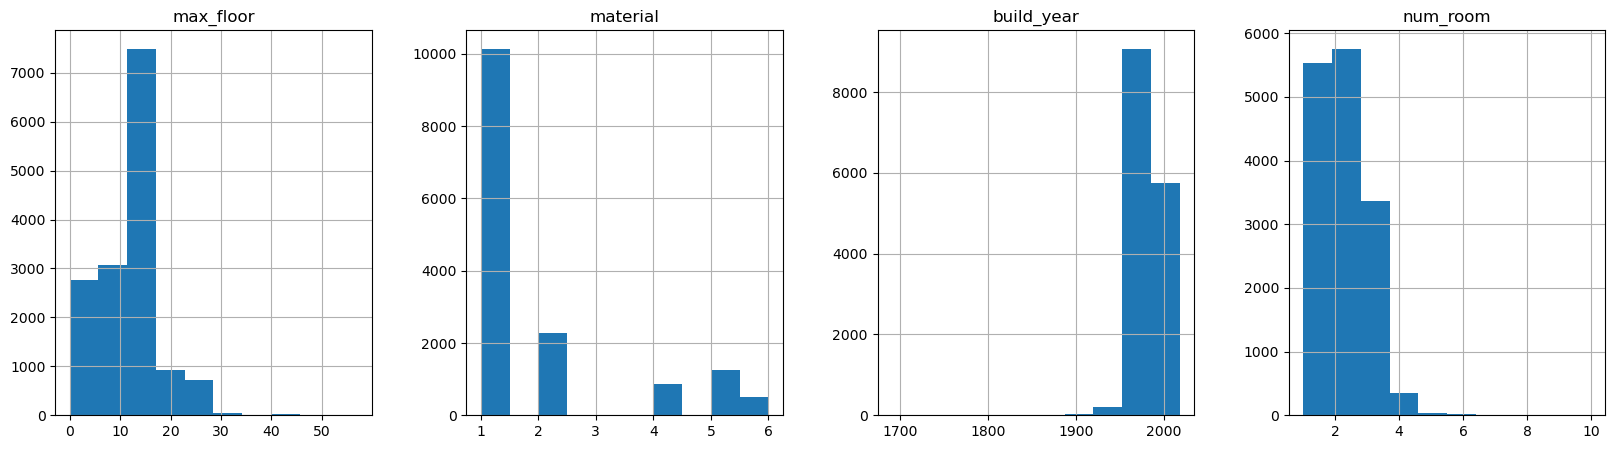

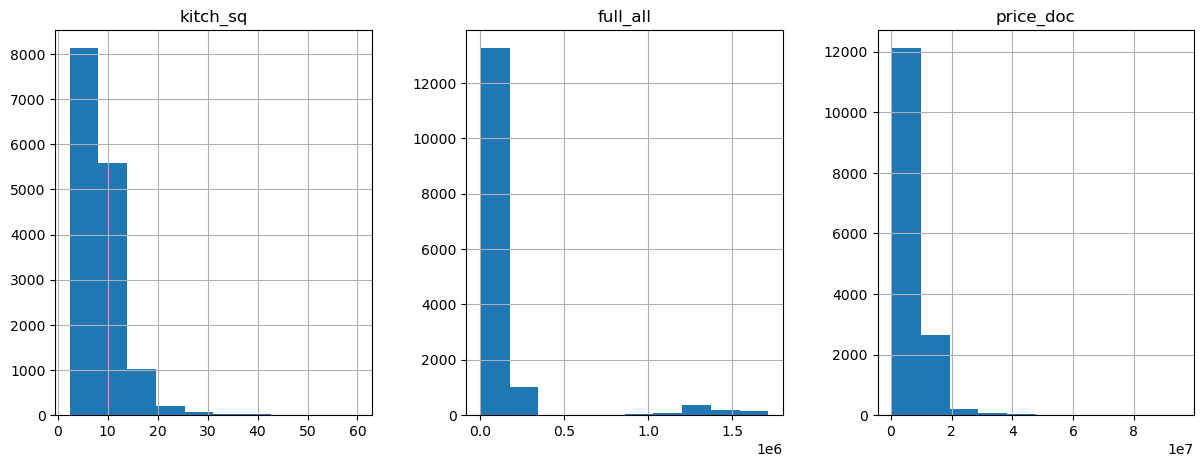

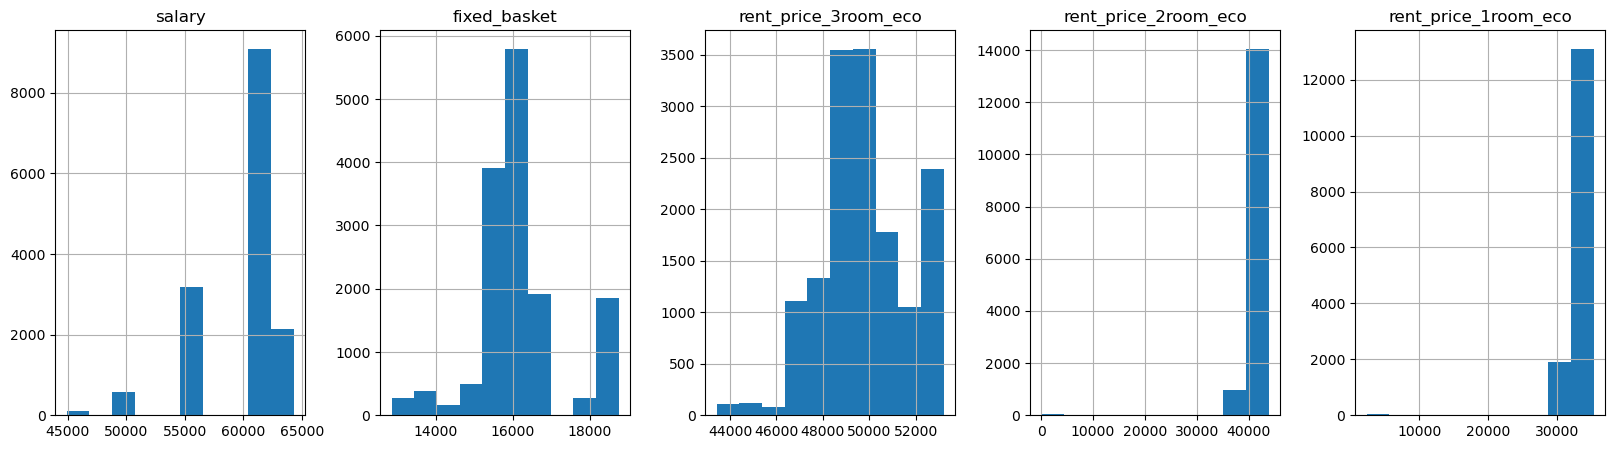

In [ ]:
train.hist(column=train.drop(['timestamp','id'],1).columns[:4], figsize = (20,5), layout= (1,4)),
train.hist(column=train.drop(['timestamp','id'],1).columns[4:8], figsize = (20,5), layout= (1,4)),
train.hist(column=train.drop(['timestamp','id'],1).columns[8:12], figsize = (20,5), layout= (1,4)),
train.hist(column=train.drop(['timestamp','id'],1).columns[12:17], figsize = (20,5), layout= (1,5))

In [ ]:
ost = ['salary','fixed_basket','rent_price_3room_eco','rent_price_2room_eco','rent_price_1room_eco']

Что-то не так с арендой 2 и 1 комнатных квартир

In [ ]:
train.rent_price_2room_eco.mean(), train.rent_price_1room_eco.mean()

(41682.06544103006, 33379.565275104535)

In [107]:
rent_price_2room_eco_mean = round(train.rent_price_2room_eco.mean(),0)
rent_price_1room_eco_mean = round(train.rent_price_1room_eco.mean(),0)

In [108]:
train.rent_price_2room_eco = train.rent_price_2room_eco.apply(lambda x: rent_price_2room_eco_mean if x < 37_000 else x)
train.rent_price_1room_eco = train.rent_price_1room_eco.apply(lambda x: rent_price_1room_eco_mean if x < 30_000 else x)

array([[<AxesSubplot:title={'center':'rent_price_2room_eco'}>,
        <AxesSubplot:title={'center':'rent_price_1room_eco'}>]],
      dtype=object)

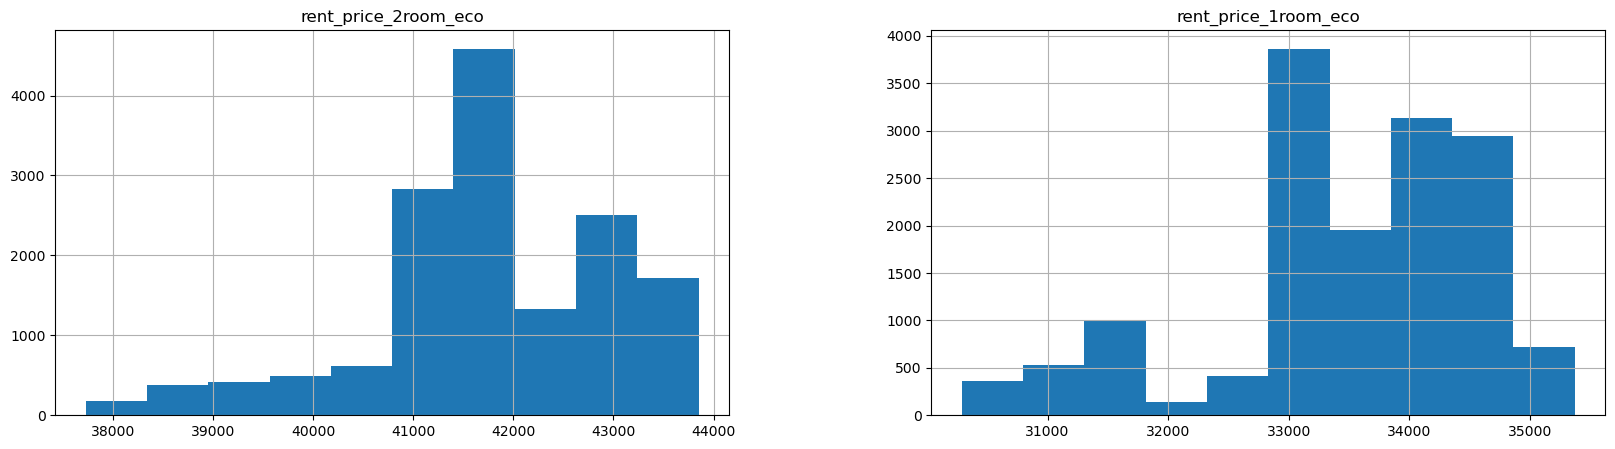

In [ ]:
train.hist(column=train.drop(['timestamp','id'],1).columns[15:17], figsize = (20,5), layout= (1,2))

Выглядит получше

test

array([[<AxesSubplot:title={'center':'fixed_basket'}>,
        <AxesSubplot:title={'center':'rent_price_3room_eco'}>,
        <AxesSubplot:title={'center':'rent_price_2room_eco'}>,
        <AxesSubplot:title={'center':'rent_price_1room_eco'}>,
        <AxesSubplot:title={'center':'average_life_exp'}>]], dtype=object)

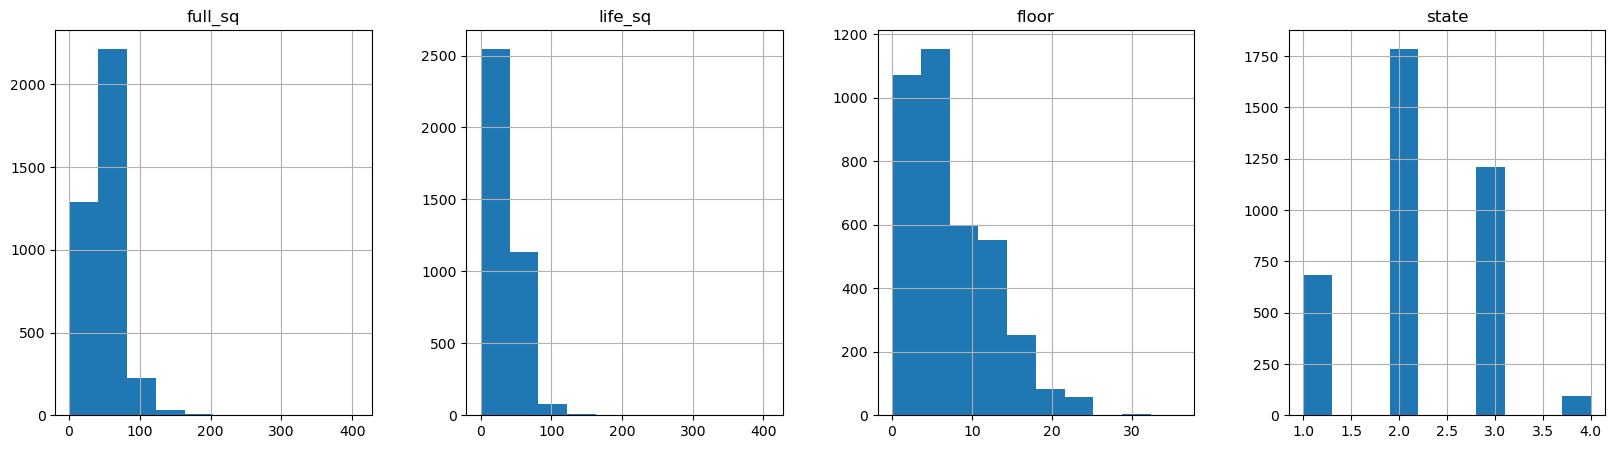

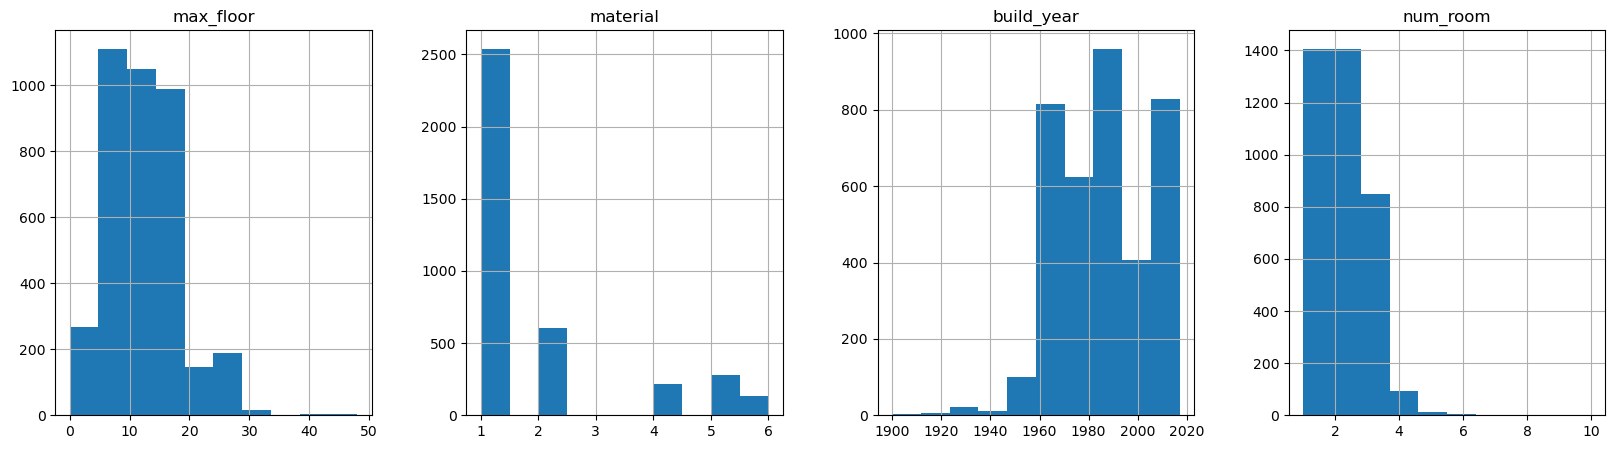

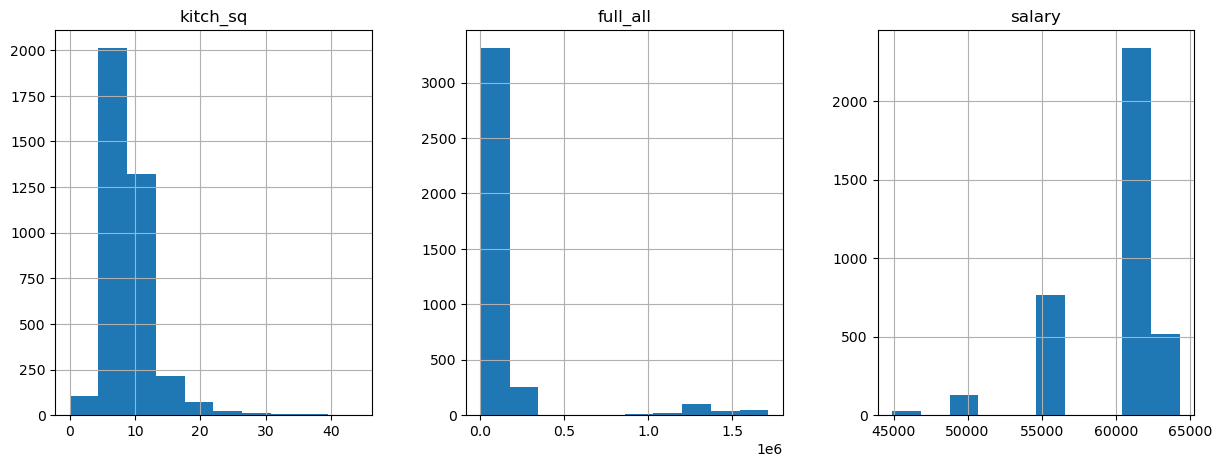

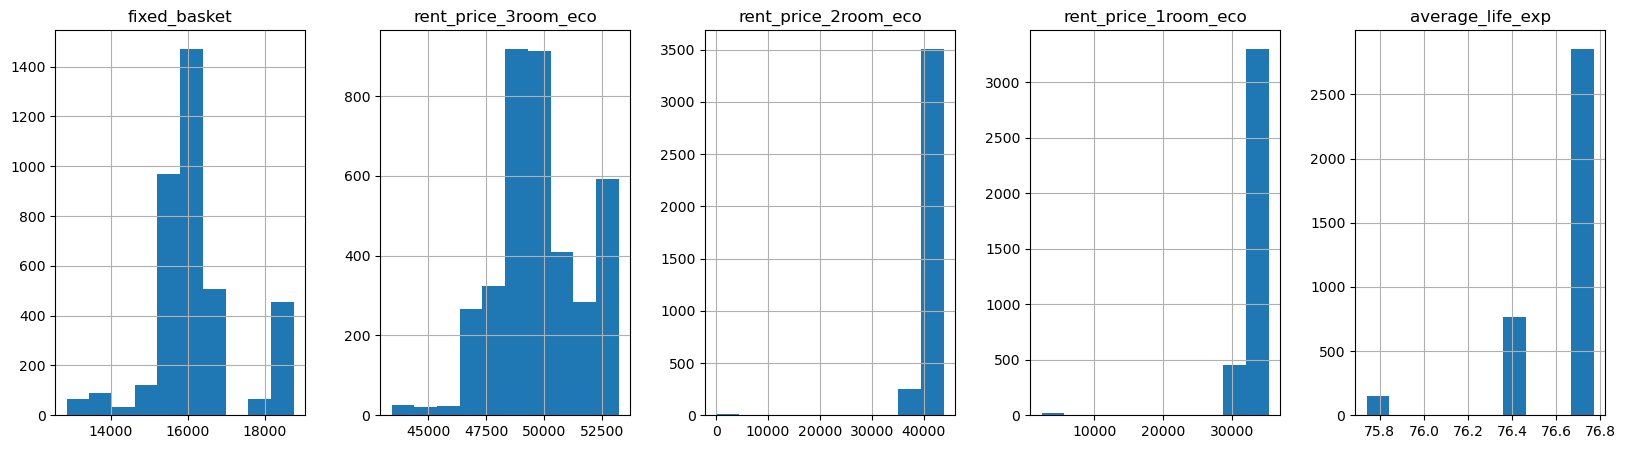

In [ ]:
test.hist(column=test.drop(['timestamp','id'],1).columns[:4], figsize = (20,5), layout= (1,4)),
test.hist(column=test.drop(['timestamp','id'],1).columns[4:8], figsize = (20,5), layout= (1,4)),
test.hist(column=test.drop(['timestamp','id'],1).columns[8:12], figsize = (20,5), layout= (1,4)),
test.hist(column=test.drop(['timestamp','id'],1).columns[12:17], figsize = (20,5), layout= (1,5))

In [109]:
test.rent_price_2room_eco = test.rent_price_2room_eco.apply(lambda x: rent_price_2room_eco_mean if x < 37_000 else x)
test.rent_price_1room_eco = test.rent_price_1room_eco.apply(lambda x: rent_price_1room_eco_mean if x < 30_000 else x)

### Смотрим корреляцию получившихся признаков с целевой переменной

In [ ]:
cm = sns.color_palette("vlag", as_cmap=True)

train.corr().style.background_gradient(cmap=cm, vmin = -1, vmax=1)

,id,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
id,1.000000,0.041110,0.040037,-0.012086,-0.039857,0.039598,0.103299,0.101903,0.045792,0.033111,-0.003979,0.085503,0.870040,0.928162,0.715787,0.184788,-0.001446,0.802858
full_sq,0.041110,1.000000,0.794075,0.164003,-0.080513,0.166924,0.038116,0.232428,0.760473,0.639322,-0.033344,0.654409,0.039623,0.054009,0.018596,-0.023941,-0.037349,0.026347
life_sq,0.040037,0.794075,1.000000,0.151196,-0.259076,0.107342,0.016557,0.267136,0.572426,0.698070,-0.075051,0.463326,0.031441,0.051583,0.019968,-0.023633,-0.043828,0.015751
floor,-0.012086,0.164003,0.151196,1.000000,-0.079432,0.485934,0.011635,0.338669,0.015845,0.247285,-0.021988,0.144158,-0.015976,-0.005421,-0.014599,-0.020870,-0.031056,-0.022009
state,-0.039857,-0.080513,-0.259076,-0.079432,1.000000,-0.033105,-0.050812,-0.288047,0.067687,-0.284499,0.083366,0.106456,-0.016602,-0.052736,0.002714,0.073697,0.088346,0.006200
max_floor,0.039598,0.166924,0.107342,0.485934,-0.033105,1.000000,0.064374,0.509216,-0.016401,0.247713,-0.004902,0.133500,0.033779,0.041712,0.017018,-0.013028,-0.024557,0.028762
material,0.103299,0.038116,0.016557,0.011635,-0.050812,0.064374,1.000000,0.022122,-0.024179,0.048320,0.026447,0.065176,0.108006,0.098283,0.088566,0.052649,0.041739,0.117428
build_year,0.101903,0.232428,0.267136,0.338669,-0.288047,0.509216,0.022122,1.000000,-0.054325,0.446079,-0.072586,0.040357,0.083680,0.103670,0.069148,-0.006824,-0.025132,0.071716
num_room,0.045792,0.760473,0.572426,0.015845,0.067687,-0.016401,-0.024179,-0.054325,1.000000,0.300221,-0.008020,0.485435,0.059047,0.057203,0.036183,0.018861,0.007387,0.056595
kitch_sq,0.033111,0.639322,0.698070,0.247285,-0.284499,0.247713,0.048320,0.446079,0.300221,1.000000,-0.072195,0.335975,0.016871,0.041606,0.013420,-0.026006,-0.046930,-0.001714


С целевой переменной price_doc коррелируют следующие признаки : full_sq, life_sq, num_room, kitch_sq

In [ ]:
train_exp = train.copy(deep=True)
test_exp = test.copy(deep=True)

### Применяем степенное преобразование для данных со скошенным распределением

In [ ]:
skosh_rasp = ['full_sq','life_sq','floor','max_floor','build_year','num_room','kitch_sq','full_all']

In [ ]:
train_exp[skosh_rasp] = np.log1p(train_exp[skosh_rasp])
test_exp[skosh_rasp] = np.log1p(test_exp[skosh_rasp])

### Применяем one-hot encoding для категориальных признаков

In [ ]:
cat_columns = ['sub_area']

In [ ]:
train_exp = train_exp.join(pd.get_dummies(train_exp[cat_columns]))
test_exp = test_exp.join(pd.get_dummies(test_exp[cat_columns]))

In [ ]:
len(train_exp.columns), len(test_exp.columns) #Ищем разницу в колонках для предотвращения ошибки при предсказании

(166, 162)

In [ ]:
li1 = list(train_exp.columns)
li2 = list(test_exp.columns)
 
s = set(li2)
temp3 = [x for x in li1 if x not in s]
print(temp3)

['price_doc', 'sub_area_Poselenie Klenovskoe', 'sub_area_Poselenie Mihajlovo-Jarcevskoe', 'sub_area_Poselenie Shhapovskoe']


In [ ]:
test_exp['sub_area_Poselenie Klenovskoe'] = test_exp.build_year.apply(lambda x: 0)
test_exp['sub_area_Poselenie Mihajlovo-Jarcevskoe'] = test_exp.build_year.apply(lambda x: 0)
test_exp['sub_area_Poselenie Shhapovskoe'] = test_exp.build_year.apply(lambda x: 0)

### Применяем нормализацию для оставшихся признаков

In [ ]:
skosh_rasp.extend(cat_columns)

In [ ]:
skosh_rasp

['full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'build_year',
 'num_room',
 'kitch_sq',
 'full_all',
 'sub_area']

In [ ]:
li2 = skosh_rasp
li1 = list(train.columns)
 
s = set(li2)
lasts = [x for x in li1 if x not in s]
lasts = lasts[2:]
lasts.remove('price_doc')
lasts

['state',
 'material',
 'salary',
 'fixed_basket',
 'rent_price_3room_eco',
 'rent_price_2room_eco',
 'rent_price_1room_eco',
 'average_life_exp']

train

In [ ]:
x = train_exp[lasts].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_exp[lasts] = pd.DataFrame(x_scaled)

test

In [ ]:
x = test_exp[lasts].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test_exp[lasts] = pd.DataFrame(x_scaled)

#2.Играемся с RandomForest

## выявление столбцов для обучения

In [ ]:
cat_columns = []
num_columns = []

for column_name in train_exp.columns:
    if (train_exp[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['sub_area'] 
 Число столблцов =  1
Числовые данные:	  ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'state', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'full_all', 'price_doc', 'salary', 'fixed_basket', 'rent_price_3room_eco', 'rent_price_2room_eco', 'rent_price_1room_eco', 'average_life_exp', 'sub_area_Ajeroport', 'sub_area_Akademicheskoe', 'sub_area_Alekseevskoe', "sub_area_Altuf'evskoe", 'sub_area_Arbat', 'sub_area_Babushkinskoe', 'sub_area_Basmannoe', 'sub_area_Begovoe', 'sub_area_Beskudnikovskoe', 'sub_area_Bibirevo', 'sub_area_Birjulevo Vostochnoe', 'sub_area_Birjulevo Zapadnoe', 'sub_area_Bogorodskoe', 'sub_area_Brateevo', 'sub_area_Butyrskoe', 'sub_area_Caricyno', 'sub_area_Cheremushki', "sub_area_Chertanovo Central'noe", 'sub_area_Chertanovo Juzhnoe', 'sub_area_Chertanovo Severnoe', 'sub_area_Danilovskoe', 'sub_area_Dmitrovskoe', 'sub_area_Donskoe', 'sub_area_Dorogomilovo', 'sub_area_Filevskij Park', 'sub_area_Fili Davydkovo',

In [ ]:
num_columns = num_columns[2:]

Метрики : MAE, RMSE, RMSLE, R2

## кросс-валидация модели

In [ ]:
df_num = train_exp[num_columns].copy()

X,y = df_num.drop(columns = ['price_doc']).values,df_num['price_doc'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=SEED)
 

LR = RandomForestRegressor()

LR.fit(X_train, y_train)

scoring = {'R2': 'r2',
           '-RMSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'MSLE': 'neg_mean_squared_log_error'}


scores = cross_validate(LR, X_train, y_train,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=SEED) )

print('Результаты Кросс-валидации')
DF_cv_linreg = pd.DataFrame(scores)
display(DF_cv_linreg)
print('\n')
print(DF_cv_linreg.mean()[2:])
print('\n')

Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-RMSE,test_-MAE,test_MSLE
0,16.55,0.04,0.63,-8630799354132.50,-1707104.99,-0.26
1,16.10,0.04,0.62,-7849948676511.19,-1663695.79,-0.22
2,16.22,0.04,0.62,-9286681465511.82,-1695905.51,-0.25
3,17.14,0.04,0.60,-10151271728916.16,-1684093.13,-0.25
4,17.09,0.04,0.48,-11648412461113.41,-1891655.69,-0.31




test_R2                   0.59
test_-RMSE   -9513422737237.01
test_-MAE          -1728491.02
test_MSLE                -0.26
dtype: float64




## Подбор гиперпараметров

In [ ]:
def objective(trial):
    # Определение гиперпараметров, которые будут оптимизироваться
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Создание модели
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED
    )

    # Обучение модели на обучающем наборе
    model.fit(X_train, y_train)

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)

    # Вычисление среднеквадратичной ошибки на тестовом наборе
    mae = mean_absolute_error(y_test, y_pred)

    # Оптимизация по минимизации среднеквадратичной ошибки
    return mae

In [ ]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)
print('Параметры, полученные при лучшей оценке:', study.best_trial.params)

[I 2023-04-01 14:41:53,962] A new study created in memory with name: no-name-818ab094-a3e1-476f-b4ba-49bae937f19b
[I 2023-04-01 14:42:31,071] Trial 0 finished with value: 2245290.3430590257 and parameters: {'n_estimators': 900, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 2245290.3430590257.
[I 2023-04-01 14:44:39,909] Trial 1 finished with value: 1794983.2318079385 and parameters: {'n_estimators': 1000, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 1 with value: 1794983.2318079385.
[I 2023-04-01 14:44:58,548] Trial 2 finished with value: 1920402.1783651125 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 1794983.2318079385.
[I 2023-04-01 14:45:09,925] Trial 3 finished with value: 1919311.4038404566 and parameters: {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 

Параметры, полученные при лучшей оценке: {'n_estimators': 700, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [ ]:
import requests
requests.get('https://api.callmebot.com/text.php?user=@mmttry&text=DONE') ## отправить сообщение в телеграм, когда обучение закончится

<Response [200]>

## Оценка модели

In [ ]:
params

{'n_estimators': 700,
 'max_depth': 15,
 'min_samples_split': 6,
 'min_samples_leaf': 1}

In [ ]:
params = study.best_trial.params

rf = RandomForestRegressor(**params)
rf.fit(train_exp[num_columns].values,train_exp['price_doc'].values)

test_exp['price_doc']=rf.predict(test_exp[num_columns].values)
test_exp['id'] = test_exp.index
test_exp[['id', 'price_doc']].to_csv('sub_chernykh_rf.csv', index=None)

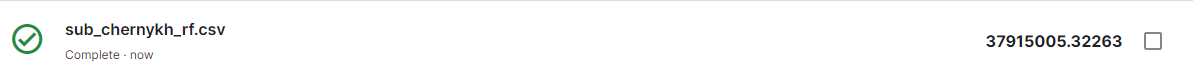

#3.Играемся с catboost

Для catboost возьмем датафрейм после заполнения нанов и обработки выбросов, но до нормализации/степенных преобразований и проч

In [145]:
cat_train = train.copy(deep=True)
cat_test = test.copy(deep=True)

## Добавление новых категориальных признаков

###1) Проверка sub_area на соответствие в тестовой и тренировочкой выборках

In [112]:
len(cat_train.sub_area.unique()), len(cat_test.sub_area.unique())

(146, 143)

In [113]:
li2 = cat_test.sub_area.unique()
li1 = list(cat_train.sub_area.unique())
 
s = set(li2)
sub_diff = [x for x in li1 if x not in s]
sub_diff

['Poselenie Klenovskoe',
 'Poselenie Shhapovskoe',
 'Poselenie Mihajlovo-Jarcevskoe']

In [143]:
cat_train[cat_train.sub_area.isin(sub_diff)]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
4387,10827,2013-09-30,43,27.00,1.00,2.00,5.00,1.00,1976.00,2.00,5.00,4199,Poselenie Klenovskoe,1000000,55485.20,15215.84,49120.00,42100.00,34530.00,76.37
4710,21854,2014-08-25,66,64.00,3.00,1.00,9.00,6.00,2011.00,1.00,15.83,2546,Poselenie Shhapovskoe,2851000,61208.00,16134.39,52810.00,43110.00,34830.00,76.70
12687,18594,2014-05-19,48,33.00,3.00,3.00,5.00,1.00,1977.00,2.00,5.00,8227,Poselenie Mihajlovo-Jarcevskoe,3480000,61208.00,16205.25,50240.00,41170.00,32870.00,76.70


Данных очень мало, можно дропнуть

In [147]:
cat_train = cat_train.drop(cat_train[cat_train.sub_area.isin(sub_diff)].index).reset_index(drop=True)
cat_train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,6.00,43795,Pechatniki,7100000,55485.20,15417.34,48500.00,42000.00,33970.00,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,5.00,21040,Dorogomilovo,11500000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,5.00,157010,Ivanovskoe,5800000,55485.20,15367.58,49290.00,42020.00,34550.00,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,Jasenevo,11400000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,Nagatinskij Zaton,12697154,64310.00,18745.28,50420.00,39160.00,31090.00,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15059,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,7.00,101982,Tekstil'shhiki,9100000,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15060,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,18.55,247469,Nekrasovka,7722400,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15061,16165,2014-03-18,38,30.40,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,Juzhnoportovoe,7000000,61208.00,15916.88,49750.00,41910.00,33260.00,76.70
15062,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,Jasenevo,7000000,55485.20,15215.84,49120.00,42100.00,34530.00,76.37


In [140]:
cat_train

In [124]:
len(cat_train.sub_area.unique()), len(cat_test.sub_area.unique())

(143, 143)

###2)Проверка build_year на соответствие в тестовой и тренировочкой выборках

In [128]:
cat_train.state.unique() , cat_test.state.unique()

(array([2., 3., 1., 4.]), array([2., 3., 1., 4.]))

In [130]:
len(cat_train.build_year.unique()) , len(cat_test.build_year.unique())

(108, 90)

In [131]:
li2 = cat_test.build_year.unique()
li1 = list(cat_train.build_year.unique())
 
s = set(li2)
build_diff = [x for x in li1 if x not in s]
build_diff

[1890.0,
 1927.0,
 1910.0,
 1947.0,
 1931.0,
 1920.0,
 1914.0,
 1943.0,
 1941.0,
 1946.0,
 1860.0,
 2018.0,
 1911.0,
 1925.0,
 1948.0,
 1691.0,
 1876.0,
 1896.0,
 1904.0,
 1895.0]

In [136]:
cat_train[cat_train.build_year.isin(build_diff)].build_year.count()

51

Данных также не очень много, можно дропнуть, дабы уровнять количество будущих категорий

In [148]:
cat_train = cat_train.drop(cat_train[cat_train.build_year.isin(build_diff)].index).reset_index(drop=True)
cat_train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,6.00,43795,Pechatniki,7100000,55485.20,15417.34,48500.00,42000.00,33970.00,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,5.00,21040,Dorogomilovo,11500000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,5.00,157010,Ivanovskoe,5800000,55485.20,15367.58,49290.00,42020.00,34550.00,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,Jasenevo,11400000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,Nagatinskij Zaton,12697154,64310.00,18745.28,50420.00,39160.00,31090.00,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15008,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,7.00,101982,Tekstil'shhiki,9100000,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15009,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,18.55,247469,Nekrasovka,7722400,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15010,16165,2014-03-18,38,30.40,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,Juzhnoportovoe,7000000,61208.00,15916.88,49750.00,41910.00,33260.00,76.70
15011,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,Jasenevo,7000000,55485.20,15215.84,49120.00,42100.00,34530.00,76.37


Дропаем

###3)Проверка material на соответствие в тестовой и тренировочкой выборках

In [149]:
cat_train.material.unique() , cat_test.material.unique()

(array([1., 2., 6., 4., 5., 3.]), array([1., 5., 2., 4., 6.]))

In [150]:
cat_train[cat_train.material == 3]

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
6266,24718,2014-11-13,61,48.80,8.00,2.00,1.00,3.00,1981.00,2.00,10.00,13890,Poselenie Sosenskoe,6931143,61208.00,16648.70,53210.00,43230.00,34300.00,76.70


In [151]:
cat_train = cat_train.drop(cat_train[cat_train.material == 3].index).reset_index(drop=True)
cat_train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2.00,9.00,1.00,1969.00,2.00,6.00,43795,Pechatniki,7100000,55485.20,15417.34,48500.00,42000.00,33970.00,76.37
1,10064,2013-08-26,55,41.00,4.00,3.00,5.00,2.00,1960.00,3.00,5.00,21040,Dorogomilovo,11500000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
2,12022,2013-11-11,43,29.00,4.00,2.00,5.00,2.00,1960.00,2.00,5.00,157010,Ivanovskoe,5800000,55485.20,15367.58,49290.00,42020.00,34550.00,76.37
3,10186,2013-08-30,62,35.00,15.00,2.00,22.00,1.00,1985.00,2.00,10.00,178264,Jasenevo,11400000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
4,30052,2015-05-29,80,55.00,15.00,1.00,24.00,6.00,2017.00,3.00,12.00,76284,Nagatinskij Zaton,12697154,64310.00,18745.28,50420.00,39160.00,31090.00,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15007,23382,2014-10-08,69,48.00,2.00,2.00,4.00,2.00,1950.00,3.00,7.00,101982,Tekstil'shhiki,9100000,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15008,24264,2014-10-31,78,75.00,4.00,1.00,17.00,1.00,2014.00,3.00,18.55,247469,Nekrasovka,7722400,61208.00,16269.79,52820.00,43850.00,35370.00,76.70
15009,16165,2014-03-18,38,30.40,15.00,3.00,17.00,1.00,1990.00,1.00,8.00,101708,Juzhnoportovoe,7000000,61208.00,15916.88,49750.00,41910.00,33260.00,76.70
15010,10635,2013-09-20,54,32.00,11.00,3.00,16.00,1.00,1979.00,2.00,9.00,178264,Jasenevo,7000000,55485.20,15215.84,49120.00,42100.00,34530.00,76.37


In [152]:
cat_train.material.unique() , cat_test.material.unique()

(array([1., 2., 6., 4., 5.]), array([1., 5., 2., 4., 6.]))

###4) Создание новых категориальных признаков

In [159]:
cat_train.build_year.astype('int32').astype('str')

0        1969
1        1960
2        1960
3        1985
4        2017
         ... 
15007    1950
15008    2014
15009    1990
15010    1979
15011    2006
Name: build_year, Length: 15012, dtype: object

In [160]:
cat_train.material = cat_train.material.astype('int32').astype('str')
cat_train.state = cat_train.state.astype('int32').astype('str')
cat_train.build_year = cat_train.build_year.astype('int32').astype('str')

cat_train.material = cat_train.material.astype('int32').astype('str')
cat_train.state = cat_train.state.astype('int32').astype('str')
cat_train.build_year = cat_train.build_year.astype('int32').astype('str')

cat_train.head(5)

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.00,8.00,2,9.00,1,1969,2.00,6.00,43795,Pechatniki,7100000,55485.20,15417.34,48500.00,42000.00,33970.00,76.37
1,10064,2013-08-26,55,41.00,4.00,3,5.00,2,1960,3.00,5.00,21040,Dorogomilovo,11500000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
2,12022,2013-11-11,43,29.00,4.00,2,5.00,2,1960,2.00,5.00,157010,Ivanovskoe,5800000,55485.20,15367.58,49290.00,42020.00,34550.00,76.37
3,10186,2013-08-30,62,35.00,15.00,2,22.00,1,1985,2.00,10.00,178264,Jasenevo,11400000,55485.20,15241.93,48220.00,42330.00,33150.00,76.37
4,30052,2015-05-29,80,55.00,15.00,1,24.00,6,2017,3.00,12.00,76284,Nagatinskij Zaton,12697154,64310.00,18745.28,50420.00,39160.00,31090.00,76.77


In [163]:
cat_train.info(), cat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    15012 non-null  int64         
 1   timestamp             15012 non-null  datetime64[ns]
 2   full_sq               15012 non-null  int64         
 3   life_sq               15012 non-null  float64       
 4   floor                 15012 non-null  float64       
 5   state                 15012 non-null  object        
 6   max_floor             15012 non-null  float64       
 7   material              15012 non-null  object        
 8   build_year            15012 non-null  object        
 9   num_room              15012 non-null  float64       
 10  kitch_sq              15012 non-null  float64       
 11  full_all              15012 non-null  int64         
 12  sub_area              15012 non-null  object        
 13  price_doc       

(None, None)

###5) Извлечем что-нибудь полезное из timestamp

In [167]:
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

print(get_season(date.today()))

spring


In [169]:
cat_train['season'] = cat_train.timestamp.apply(lambda x: get_season(x))
cat_test['season'] = cat_test.timestamp.apply(lambda x: get_season(x))

In [171]:
len(cat_train.season.unique()), len(cat_test.season.unique())

(4, 4)

In [172]:
cat_columns = []
num_columns = []

for column_name in cat_test.columns:
    if (cat_test[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  ['state', 'material', 'build_year', 'sub_area', 'season'] 
 Число столблцов =  5
Числовые данные:	  ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor', 'num_room', 'kitch_sq', 'full_all', 'salary', 'fixed_basket', 'rent_price_3room_eco', 'rent_price_2room_eco', 'rent_price_1room_eco', 'average_life_exp'] 
 Число столблцов =  15


In [173]:
num_columns = num_columns[2:]
num_columns

['full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'num_room',
 'kitch_sq',
 'full_all',
 'salary',
 'fixed_basket',
 'rent_price_3room_eco',
 'rent_price_2room_eco',
 'rent_price_1room_eco',
 'average_life_exp']

##Приминение catboost

###1)Проверка на датафрейме с новыми категориальными признаками

In [180]:
X_train, X_test, y_train, y_test = train_test_split(cat_train.drop(['price_doc'],1), cat_train.price_doc, random_state = SEED, test_size=0.18)
 

cat_reg = CatBoostRegressor(cat_features=cat_columns,verbose=250,random_state=SEED)

cat_reg.fit(X_train, y_train)

scoring = {'R2': 'r2',
           '-RMSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'MSLE': 'neg_mean_squared_log_error'}


scores = cross_validate(cat_reg, X_train, y_train,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=SEED) )

print('Результаты Кросс-валидации')
DF_cv_linreg = pd.DataFrame(scores)
display(DF_cv_linreg)
print('\n')
print(DF_cv_linreg.mean()[2:])
print('\n')

Learning rate set to 0.060874
0:	learn: 4802128.0065675	total: 25.6ms	remaining: 25.6s
250:	learn: 2593673.2967563	total: 6.24s	remaining: 18.6s
500:	learn: 2367645.5860887	total: 12.4s	remaining: 12.3s
750:	learn: 2221521.7307342	total: 18.5s	remaining: 6.14s
999:	learn: 2112513.5452691	total: 24.6s	remaining: 0us
Learning rate set to 0.059869
0:	learn: 4788651.4494955	total: 23.3ms	remaining: 23.3s
250:	learn: 2572289.8362269	total: 5.87s	remaining: 17.5s
500:	learn: 2336597.0884657	total: 11.9s	remaining: 11.8s
750:	learn: 2178508.7348634	total: 17.9s	remaining: 5.93s
999:	learn: 2059778.4505928	total: 24s	remaining: 0us
Learning rate set to 0.059869
0:	learn: 4799028.9895830	total: 22.1ms	remaining: 22.1s
250:	learn: 2537938.4260184	total: 5.92s	remaining: 17.7s
500:	learn: 2312982.0996378	total: 11.9s	remaining: 11.9s
750:	learn: 2184176.3536437	total: 17.9s	remaining: 5.93s
999:	learn: 2075595.5251016	total: 23.8s	remaining: 0us
Learning rate set to 0.059869
0:	learn: 4859242.578

,fit_time,score_time,test_R2,test_-RMSE,test_-MAE,test_MSLE
0,24.19,0.01,0.62,-9559933986326.08,-1765114.93,-0.29
1,23.99,0.01,0.65,-8452742904176.04,-1662046.79,-0.25
2,23.56,0.01,0.65,-6393296761710.73,-1554158.88,-0.23
3,23.42,0.01,0.55,-9482603428607.79,-1664947.63,-0.26
4,23.94,0.01,0.66,-8351855500706.75,-1622585.24,-0.27




test_R2                   0.63
test_-RMSE   -8448086516305.48
test_-MAE          -1653770.69
test_MSLE                -0.26
dtype: float64




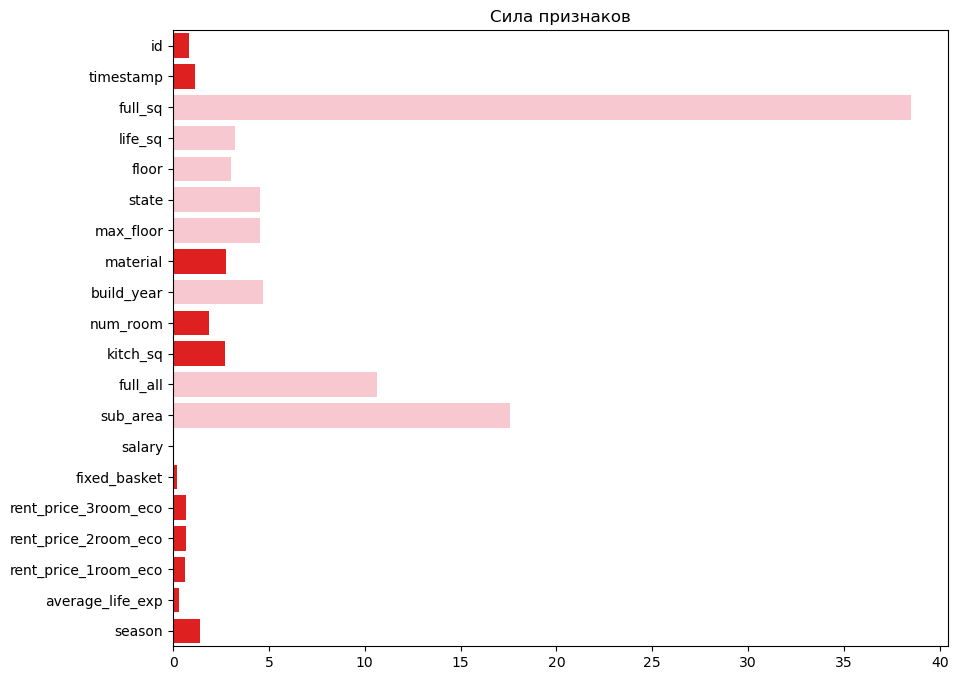

In [182]:
values = cat_reg.feature_importances_ 
idx = cat_train.drop(['price_doc'],1).columns
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [188]:
strong_features_new = [key for key,value in dict(zip(cat_train.drop(['price_doc'],1).columns, cat_reg.feature_importances_ )).items() if value > 3]
strong_features_new

['full_sq',
 'life_sq',
 'floor',
 'state',
 'max_floor',
 'build_year',
 'full_all',
 'sub_area']

###2)Проверка на исходном датафрейме(обработанном)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price_doc'],1), train.price_doc, random_state = SEED, test_size=0.18)
 

cat_reg = CatBoostRegressor(cat_features = ['sub_area'],verbose=250,random_state=SEED)

cat_reg.fit(X_train, y_train)

scoring = {'R2': 'r2',
           '-RMSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'MSLE': 'neg_mean_squared_log_error'}


scores = cross_validate(cat_reg, X_train, y_train,
                      scoring=scoring, cv=ShuffleSplit(n_splits=5, random_state=SEED) )

print('Результаты Кросс-валидации')
DF_cv_linreg = pd.DataFrame(scores)
display(DF_cv_linreg)
print('\n')
print(DF_cv_linreg.mean()[2:])
print('\n')

Learning rate set to 0.06091
0:	learn: 4800497.5423158	total: 20.8ms	remaining: 20.8s
250:	learn: 2495770.5920029	total: 5.16s	remaining: 15.4s
500:	learn: 2249510.6199278	total: 10.2s	remaining: 10.1s
750:	learn: 2106890.5486957	total: 15.2s	remaining: 5.05s
999:	learn: 1999474.4701343	total: 20.2s	remaining: 0us
Learning rate set to 0.059903
0:	learn: 4817034.7111894	total: 18.3ms	remaining: 18.3s
250:	learn: 2495171.6418197	total: 5.05s	remaining: 15.1s
500:	learn: 2233473.9182052	total: 10.2s	remaining: 10.2s
750:	learn: 2075521.1035367	total: 15.5s	remaining: 5.13s
999:	learn: 1965402.8213713	total: 20.7s	remaining: 0us
Learning rate set to 0.059903
0:	learn: 4846066.0067922	total: 22.6ms	remaining: 22.6s
250:	learn: 2492863.6166982	total: 5.11s	remaining: 15.2s
500:	learn: 2251908.0777432	total: 10.5s	remaining: 10.5s
750:	learn: 2093262.5486619	total: 15.4s	remaining: 5.11s
999:	learn: 1975454.0680693	total: 20.3s	remaining: 0us
Learning rate set to 0.059903
0:	learn: 4806784.19

,fit_time,score_time,test_R2,test_-RMSE,test_-MAE,test_MSLE
0,20.94,0.00,0.68,-7316286245764.41,-1639382.01,-0.25
1,20.50,0.01,0.67,-6714854768842.44,-1557668.95,-0.21
2,20.85,0.00,0.65,-8582827231455.82,-1609238.23,-0.24
3,20.60,0.01,0.66,-8742537717433.56,-1619533.60,-0.23
4,20.15,0.00,0.60,-8998379775441.76,-1706922.97,-0.29




test_R2                   0.65
test_-RMSE   -8070977147787.60
test_-MAE          -1626549.15
test_MSLE                -0.24
dtype: float64




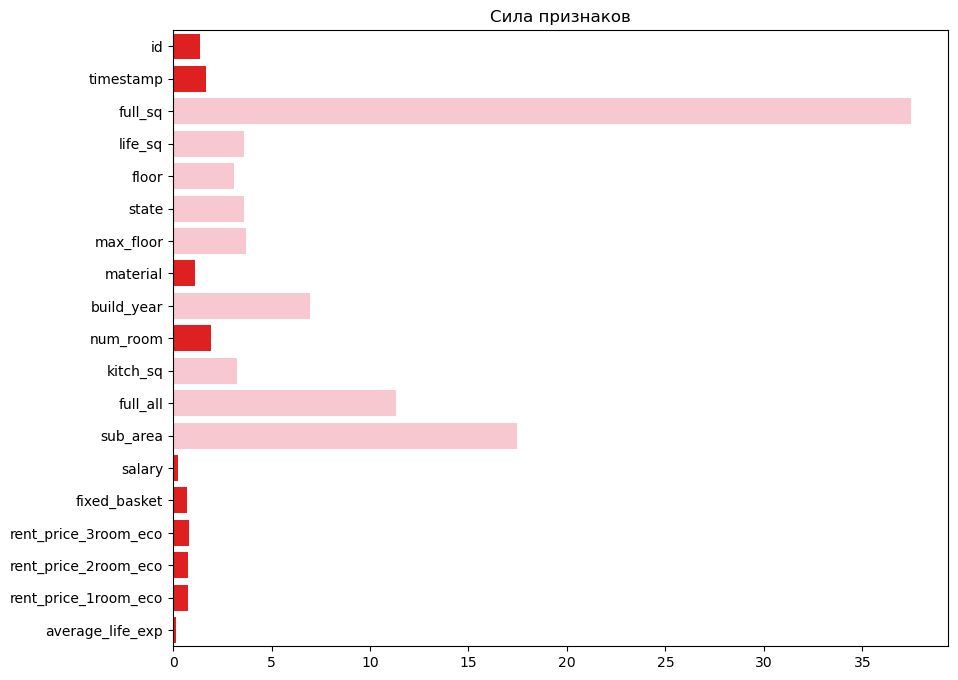

In [193]:
values = cat_reg.feature_importances_ 
idx = train.drop(['price_doc'],1).columns
plt.figure(figsize=(10,8))
clrs = ['pink' if x > 3 else 'red' for x in values]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Сила признаков')
plt.show()

In [197]:
strong_features_old = [key for key,value in dict(zip(train.drop(['price_doc'],1).columns, cat_reg.feature_importances_ )).items() if value >= 3]
strong_features_old

['full_sq',
 'life_sq',
 'floor',
 'state',
 'max_floor',
 'build_year',
 'kitch_sq',
 'full_all',
 'sub_area']

#4.Подбор гиперпараметров и сабмиты с различными наборами признаков

###Подбор и сабмит с исходными признаками + все признаки

In [229]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['price_doc'],1), train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [900, 1000, 1100, 1200, 1300]),
        'verbose': 500, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'eval_metric': 'MAE',
        'cat_features': ['sub_area'],
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=100)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-04-02 13:22:24,677] A new study created in memory with name: no-name-e8887ad2-095f-4d86-bf9f-39675496fe4c


0:	learn: 2796127.1162165	total: 15.6ms	remaining: 20.2s
500:	learn: 1322633.8958348	total: 8.75s	remaining: 14s
1000:	learn: 1240304.0437053	total: 17.5s	remaining: 5.23s


[I 2023-04-02 13:22:47,793] Trial 0 finished with value: 1473615.5228955573 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1473615.5228955573.


1299:	learn: 1205951.5005347	total: 22.9s	remaining: 0us
0:	learn: 2702807.5213608	total: 24.4ms	remaining: 22s
500:	learn: 1074423.3164846	total: 12.4s	remaining: 9.85s


[I 2023-04-02 13:23:10,259] Trial 1 finished with value: 1532120.684705233 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1473615.5228955573.


899:	learn: 986328.8597065	total: 22.3s	remaining: 0us
0:	learn: 2831889.7768661	total: 22.8ms	remaining: 20.5s
500:	learn: 1194523.9688990	total: 11.9s	remaining: 9.51s


[I 2023-04-02 13:23:31,707] Trial 2 finished with value: 1491758.6717939638 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 0 with value: 1473615.5228955573.


899:	learn: 1091968.7075090	total: 21.3s	remaining: 0us
0:	learn: 2766379.6031405	total: 24.6ms	remaining: 27.1s
500:	learn: 1122168.6873274	total: 12.6s	remaining: 15s
1000:	learn: 1015007.6345481	total: 24.3s	remaining: 2.4s


[I 2023-04-02 13:23:58,669] Trial 3 finished with value: 1516451.1493447511 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7}. Best is trial 0 with value: 1473615.5228955573.


1099:	learn: 1002583.0961917	total: 26.7s	remaining: 0us
0:	learn: 2826949.0620275	total: 30.7ms	remaining: 30.7s
500:	learn: 1083556.5971551	total: 14.9s	remaining: 14.9s


[I 2023-04-02 13:24:28,629] Trial 4 finished with value: 1486353.274653026 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.723207289855774, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 1473615.5228955573.


999:	learn: 943845.0346614	total: 29.7s	remaining: 0us
0:	learn: 2796853.0273767	total: 18.1ms	remaining: 21.7s
500:	learn: 1229576.9647777	total: 10.3s	remaining: 14.4s
1000:	learn: 1128440.7847123	total: 20.7s	remaining: 4.11s


[I 2023-04-02 13:24:53,585] Trial 5 finished with value: 1487230.7110032425 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.858359856877987, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 0 with value: 1473615.5228955573.


1199:	learn: 1107430.0629006	total: 24.7s	remaining: 0us
0:	learn: 2702807.5213608	total: 26.4ms	remaining: 34.2s
500:	learn: 1095663.9640742	total: 11.8s	remaining: 18.8s
1000:	learn: 983905.4628615	total: 25.1s	remaining: 7.49s


[I 2023-04-02 13:25:26,734] Trial 6 finished with value: 1511340.4271662184 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.590005956569925, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1473615.5228955573.


1299:	learn: 946904.8836490	total: 32.9s	remaining: 0us
0:	learn: 2953311.3693996	total: 23ms	remaining: 25.2s
500:	learn: 1647447.2919194	total: 12.8s	remaining: 15.3s
1000:	learn: 1518926.3273316	total: 27.6s	remaining: 2.73s


[I 2023-04-02 13:25:57,118] Trial 7 finished with value: 1561109.7178683456 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.490253299323136, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 0 with value: 1473615.5228955573.


1099:	learn: 1499358.5618964	total: 30.1s	remaining: 0us
0:	learn: 2826949.0620275	total: 31.2ms	remaining: 37.4s
500:	learn: 1068950.9168864	total: 16s	remaining: 22.3s
1000:	learn: 930979.2472767	total: 30.7s	remaining: 6.11s


[I 2023-04-02 13:26:33,758] Trial 8 finished with value: 1481004.7326731621 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.0157775970825895, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 1473615.5228955573.


1199:	learn: 900737.0189576	total: 36.4s	remaining: 0us
0:	learn: 2693290.0780883	total: 27.6ms	remaining: 24.8s
500:	learn: 946400.7190473	total: 14.4s	remaining: 11.5s


[I 2023-04-02 13:26:59,761] Trial 9 finished with value: 1543280.6191634526 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.356008305729379, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 0 with value: 1473615.5228955573.


899:	learn: 839239.9455572	total: 25.8s	remaining: 0us
0:	learn: 2908255.9529299	total: 15.1ms	remaining: 19.6s
500:	learn: 1478440.6880910	total: 8.24s	remaining: 13.1s
1000:	learn: 1367731.0172844	total: 16.3s	remaining: 4.87s


[I 2023-04-02 13:27:21,117] Trial 10 finished with value: 1464630.6216710794 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.81995855121286, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1327307.7017595	total: 21.1s	remaining: 0us
0:	learn: 2908255.9529299	total: 14.8ms	remaining: 19.3s
500:	learn: 1477572.0111998	total: 7.93s	remaining: 12.6s
1000:	learn: 1372548.6193514	total: 15.7s	remaining: 4.7s


[I 2023-04-02 13:27:41,747] Trial 11 finished with value: 1471342.999052652 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.8424826929818, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1332030.0501894	total: 20.4s	remaining: 0us
0:	learn: 2908255.9529299	total: 15ms	remaining: 19.4s
500:	learn: 1478440.6880910	total: 7.84s	remaining: 12.5s
1000:	learn: 1367625.1097002	total: 15.8s	remaining: 4.71s


[I 2023-04-02 13:28:02,468] Trial 12 finished with value: 1468397.313241009 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.829248714363659, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1329226.8828238	total: 20.5s	remaining: 0us
0:	learn: 2908255.9529299	total: 16.4ms	remaining: 21.3s
500:	learn: 1478263.6661211	total: 7.8s	remaining: 12.4s
1000:	learn: 1370588.0552360	total: 15.7s	remaining: 4.67s


[I 2023-04-02 13:28:23,176] Trial 13 finished with value: 1472730.0596057717 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.038442843883351, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1331169.0386043	total: 20.5s	remaining: 0us
0:	learn: 2908255.9529299	total: 14.8ms	remaining: 19.2s
500:	learn: 1476956.8127392	total: 7.89s	remaining: 12.6s
1000:	learn: 1368079.6970275	total: 15.6s	remaining: 4.66s


[I 2023-04-02 13:28:43,679] Trial 14 finished with value: 1472183.6862531255 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.896905095206857, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1328032.3792316	total: 20.3s	remaining: 0us
0:	learn: 2908255.9529299	total: 14.8ms	remaining: 14.8s
500:	learn: 1483642.3971323	total: 7.75s	remaining: 7.72s


[I 2023-04-02 13:28:59,450] Trial 15 finished with value: 1472722.5957016833 and parameters: {'iterations': 1000, 'l2_leaf_reg': 7.979659947086715, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


999:	learn: 1371294.2294266	total: 15.6s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.1ms	remaining: 23.5s
500:	learn: 1408452.3415248	total: 9.32s	remaining: 14.9s
1000:	learn: 1292012.7750193	total: 18.7s	remaining: 5.58s


[I 2023-04-02 13:29:24,056] Trial 16 finished with value: 1470792.0105128733 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.194688071778483, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1252189.8170728	total: 24.4s	remaining: 0us
0:	learn: 2955143.2672741	total: 16.9ms	remaining: 22s
500:	learn: 1729866.8899953	total: 7.66s	remaining: 12.2s
1000:	learn: 1624642.0605727	total: 15.4s	remaining: 4.6s


[I 2023-04-02 13:29:44,322] Trial 17 finished with value: 1584894.440041711 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.4686487821021705, 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1581340.2489908	total: 20s	remaining: 0us
0:	learn: 2908255.9529299	total: 14.7ms	remaining: 19.2s
500:	learn: 1475216.1955665	total: 7.73s	remaining: 12.3s
1000:	learn: 1371406.1162650	total: 15.7s	remaining: 4.68s


[I 2023-04-02 13:30:04,921] Trial 18 finished with value: 1471467.0134432677 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.338954810823624, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


1299:	learn: 1331373.1943901	total: 20.4s	remaining: 0us
0:	learn: 2908255.9529299	total: 14.7ms	remaining: 14.7s
500:	learn: 1479777.0945276	total: 8.07s	remaining: 8.04s


[I 2023-04-02 13:30:21,904] Trial 19 finished with value: 1483309.197619881 and parameters: {'iterations': 1000, 'l2_leaf_reg': 4.585798879038521, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 10 with value: 1464630.6216710794.


999:	learn: 1372612.3957869	total: 16.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.4ms	remaining: 23.3s
500:	learn: 1406652.7433711	total: 10.4s	remaining: 14.6s
1000:	learn: 1280595.0280236	total: 20.4s	remaining: 4.05s


[I 2023-04-02 13:30:46,591] Trial 20 finished with value: 1454974.6897918545 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.352167140519084, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 20 with value: 1454974.6897918545.


1199:	learn: 1251669.9944536	total: 24.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.1ms	remaining: 22.9s
500:	learn: 1410406.8918292	total: 10s	remaining: 14s
1000:	learn: 1276880.6495314	total: 20.1s	remaining: 4s


[I 2023-04-02 13:31:10,955] Trial 21 finished with value: 1457003.4905668632 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.431517820254856, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 20 with value: 1454974.6897918545.


1199:	learn: 1246310.9811012	total: 24.1s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.9ms	remaining: 22.7s
500:	learn: 1401285.4477502	total: 10.3s	remaining: 14.4s
1000:	learn: 1279435.7744503	total: 20.5s	remaining: 4.07s


[I 2023-04-02 13:31:35,657] Trial 22 finished with value: 1456851.635912917 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.304685269468156, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 20 with value: 1454974.6897918545.


1199:	learn: 1252685.7914791	total: 24.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.1ms	remaining: 22.9s
500:	learn: 1401285.4477502	total: 10.4s	remaining: 14.5s
1000:	learn: 1278202.5140459	total: 20.4s	remaining: 4.05s


[I 2023-04-02 13:32:00,196] Trial 23 finished with value: 1454746.438642605 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.319783951407881, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1251532.7470872	total: 24.3s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.6ms	remaining: 22.3s
500:	learn: 1407550.9947890	total: 9.81s	remaining: 13.7s
1000:	learn: 1291767.8661184	total: 19.5s	remaining: 3.88s


[I 2023-04-02 13:32:23,956] Trial 24 finished with value: 1472575.7851132017 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.897352192418101, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1259884.3253155	total: 23.5s	remaining: 0us
0:	learn: 2955192.7827465	total: 21.5ms	remaining: 25.8s
500:	learn: 1688298.1607510	total: 10.2s	remaining: 14.3s
1000:	learn: 1575404.0816402	total: 20s	remaining: 3.98s


[I 2023-04-02 13:32:48,035] Trial 25 finished with value: 1565752.2871795148 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.284319075032077, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1539319.5598906	total: 23.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.8ms	remaining: 22.5s
500:	learn: 1411490.3093087	total: 9.68s	remaining: 13.5s
1000:	learn: 1286240.0211492	total: 19.5s	remaining: 3.88s


[I 2023-04-02 13:33:11,655] Trial 26 finished with value: 1463821.8578903922 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.069540682683039, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1257140.8351469	total: 23.4s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.4ms	remaining: 22.1s
500:	learn: 1408255.7512056	total: 9.6s	remaining: 13.4s
1000:	learn: 1280901.0678157	total: 19.2s	remaining: 3.83s


[I 2023-04-02 13:33:34,960] Trial 27 finished with value: 1473173.0268047373 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.1843033365092435, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1251493.0234711	total: 23.1s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.5ms	remaining: 22.2s
500:	learn: 1408119.3938473	total: 9.62s	remaining: 13.4s
1000:	learn: 1284483.3312979	total: 19.2s	remaining: 3.82s


[I 2023-04-02 13:33:58,264] Trial 28 finished with value: 1465850.4400892244 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.648067653654596, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1258237.1953350	total: 23.1s	remaining: 0us
0:	learn: 2796853.0273767	total: 18.9ms	remaining: 22.7s
500:	learn: 1231951.3352987	total: 9.73s	remaining: 13.6s
1000:	learn: 1135964.6561173	total: 19.4s	remaining: 3.85s


[I 2023-04-02 13:34:21,656] Trial 29 finished with value: 1508256.8481205895 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.17786081102433, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1114492.6967570	total: 23.2s	remaining: 0us
0:	learn: 2851550.7238129	total: 18.5ms	remaining: 22.2s
500:	learn: 1288604.8830571	total: 9.68s	remaining: 13.5s
1000:	learn: 1180551.7048208	total: 19.3s	remaining: 3.83s


[I 2023-04-02 13:34:45,072] Trial 30 finished with value: 1479611.479390681 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.485250896649723, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1155453.2098480	total: 23.2s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.3ms	remaining: 22s
500:	learn: 1410597.6189845	total: 9.58s	remaining: 13.4s
1000:	learn: 1282593.6388586	total: 19.2s	remaining: 3.81s


[I 2023-04-02 13:35:08,299] Trial 31 finished with value: 1464558.2214295254 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.390827634911378, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1252403.1524942	total: 23s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.6ms	remaining: 23.5s
500:	learn: 1403879.1106869	total: 9.61s	remaining: 13.4s
1000:	learn: 1278399.6260218	total: 19.2s	remaining: 3.82s


[I 2023-04-02 13:35:31,567] Trial 32 finished with value: 1461212.3016191912 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.730802047548406, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1250965.9372817	total: 23s	remaining: 0us
0:	learn: 2744347.2380005	total: 18.6ms	remaining: 22.2s
500:	learn: 1189029.2576478	total: 9.64s	remaining: 13.4s
1000:	learn: 1096615.7450434	total: 19.4s	remaining: 3.85s


[I 2023-04-02 13:35:55,033] Trial 33 finished with value: 1511159.743234429 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.438747751152734, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1075516.8064849	total: 23.2s	remaining: 0us
0:	learn: 2908498.7554341	total: 22.1ms	remaining: 24.2s
500:	learn: 1407550.9947890	total: 9.76s	remaining: 11.7s
1000:	learn: 1286162.0369499	total: 19.6s	remaining: 1.93s


[I 2023-04-02 13:36:16,880] Trial 34 finished with value: 1469716.6148132088 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.87995327573373, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1271411.0676411	total: 21.6s	remaining: 0us
0:	learn: 2796853.0273767	total: 19.2ms	remaining: 17.2s
500:	learn: 1238223.6558492	total: 10.1s	remaining: 8.03s


[I 2023-04-02 13:36:35,000] Trial 35 finished with value: 1498563.797637962 and parameters: {'iterations': 900, 'l2_leaf_reg': 5.120497846262978, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


899:	learn: 1160693.3728529	total: 17.9s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.7ms	remaining: 22.4s
500:	learn: 1404565.4446695	total: 9.94s	remaining: 13.9s
1000:	learn: 1278892.6054332	total: 20.8s	remaining: 4.13s


[I 2023-04-02 13:36:59,974] Trial 36 finished with value: 1465636.25671234 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.535378273785245, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1251990.5674099	total: 24.7s	remaining: 0us
0:	learn: 2826949.0620275	total: 28.2ms	remaining: 33.8s
500:	learn: 1072609.9312609	total: 14.9s	remaining: 20.7s
1000:	learn: 934838.2297990	total: 29.7s	remaining: 5.9s


[I 2023-04-02 13:37:35,672] Trial 37 finished with value: 1516371.716845131 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.118258334913682, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 903175.6952703	total: 35.4s	remaining: 0us
0:	learn: 2953311.3693996	total: 23.6ms	remaining: 25.9s
500:	learn: 1647282.7942841	total: 11.5s	remaining: 13.8s
1000:	learn: 1512911.5606027	total: 23.1s	remaining: 2.29s


[I 2023-04-02 13:38:01,347] Trial 38 finished with value: 1557048.971171332 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.7354193112512935, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1494224.7823501	total: 25.4s	remaining: 0us
0:	learn: 2796853.0273767	total: 18.9ms	remaining: 22.7s
500:	learn: 1234320.7899283	total: 9.75s	remaining: 13.6s
1000:	learn: 1137328.5073995	total: 19.5s	remaining: 3.88s


[I 2023-04-02 13:38:25,073] Trial 39 finished with value: 1482144.3482029086 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.273881082546872, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1113036.8105075	total: 23.5s	remaining: 0us
0:	learn: 2744347.2380005	total: 18.6ms	remaining: 18.6s
500:	learn: 1190298.6588771	total: 12.4s	remaining: 12.3s


[I 2023-04-02 13:38:48,545] Trial 40 finished with value: 1525645.4590489357 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.557312193705436, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


999:	learn: 1096028.8595030	total: 23.3s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.9ms	remaining: 22.7s
500:	learn: 1407550.9947890	total: 10.1s	remaining: 14s
1000:	learn: 1284225.3222627	total: 20s	remaining: 3.98s


[I 2023-04-02 13:39:12,814] Trial 41 finished with value: 1465882.6595599002 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.847551806397622, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1252192.7202896	total: 24s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.8ms	remaining: 22.5s
500:	learn: 1403551.4819459	total: 10s	remaining: 14s
1000:	learn: 1276457.0976398	total: 19.9s	remaining: 3.96s


[I 2023-04-02 13:39:36,982] Trial 42 finished with value: 1463135.8075535847 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.710401502399136, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1244568.1373820	total: 23.9s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.8ms	remaining: 16.9s
500:	learn: 1402188.3563418	total: 9.81s	remaining: 7.81s


[I 2023-04-02 13:39:54,779] Trial 43 finished with value: 1466609.9214687697 and parameters: {'iterations': 900, 'l2_leaf_reg': 5.334001448586551, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


899:	learn: 1298929.9639071	total: 17.6s	remaining: 0us
0:	learn: 2898914.3542869	total: 23.3ms	remaining: 27.9s
500:	learn: 1327274.6954613	total: 11.8s	remaining: 16.4s
1000:	learn: 1180293.2735936	total: 23.5s	remaining: 4.67s


[I 2023-04-02 13:40:23,236] Trial 44 finished with value: 1470163.7880232842 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.051296010327659, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1145474.8427498	total: 28.2s	remaining: 0us
0:	learn: 2896417.6034003	total: 29.5ms	remaining: 35.3s
500:	learn: 1229242.2933179	total: 14.2s	remaining: 19.8s
1000:	learn: 1064253.8242635	total: 28.3s	remaining: 5.63s


[I 2023-04-02 13:40:57,434] Trial 45 finished with value: 1463666.0028414049 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.659870079975826, 'learning_rate': 0.05, 'max_depth': 8}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1029443.4399125	total: 33.9s	remaining: 0us
0:	learn: 2851550.7238129	total: 18.6ms	remaining: 22.3s
500:	learn: 1289798.8425558	total: 9.86s	remaining: 13.8s
1000:	learn: 1180898.1752754	total: 19.6s	remaining: 3.9s


[I 2023-04-02 13:41:21,164] Trial 46 finished with value: 1478126.3626424356 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.417736055533609, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1157116.0233420	total: 23.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 19ms	remaining: 22.8s
500:	learn: 1409362.3456250	total: 9.76s	remaining: 13.6s
1000:	learn: 1285356.8138220	total: 19.7s	remaining: 3.91s


[I 2023-04-02 13:41:44,913] Trial 47 finished with value: 1466760.3329789615 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.254649878018051, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1253804.8718558	total: 23.5s	remaining: 0us
0:	learn: 2898914.3542869	total: 22.8ms	remaining: 25.1s
500:	learn: 1321040.8258972	total: 11.6s	remaining: 13.9s
1000:	learn: 1183117.1291156	total: 23.2s	remaining: 2.3s


[I 2023-04-02 13:42:10,712] Trial 48 finished with value: 1459918.3567075962 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.971470406302086, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1165873.6358696	total: 25.6s	remaining: 0us
0:	learn: 2702807.5213608	total: 23ms	remaining: 25.3s
500:	learn: 1088248.2242515	total: 11.6s	remaining: 13.9s
1000:	learn: 981940.1613130	total: 23.3s	remaining: 2.3s


[I 2023-04-02 13:42:36,529] Trial 49 finished with value: 1508367.2750516299 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.979089130191129, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 966376.7420347	total: 25.6s	remaining: 0us
0:	learn: 2898914.3542869	total: 23.3ms	remaining: 25.7s
500:	learn: 1321876.8682487	total: 11.6s	remaining: 13.9s
1000:	learn: 1179752.4233004	total: 23.3s	remaining: 2.31s


[I 2023-04-02 13:43:02,394] Trial 50 finished with value: 1470774.8503093782 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.998588264835294, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1159161.3839956	total: 25.6s	remaining: 0us
0:	learn: 2898914.3542869	total: 22.6ms	remaining: 24.9s
500:	learn: 1322864.2698721	total: 11.8s	remaining: 14.1s
1000:	learn: 1185607.5927323	total: 23.8s	remaining: 2.35s


[I 2023-04-02 13:43:28,752] Trial 51 finished with value: 1475369.330098006 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.470177571453833, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1168476.5204221	total: 26.1s	remaining: 0us
0:	learn: 2898914.3542869	total: 23.6ms	remaining: 26s
500:	learn: 1323827.0511700	total: 11.8s	remaining: 14.1s
1000:	learn: 1182721.3052639	total: 23.6s	remaining: 2.34s


[I 2023-04-02 13:43:54,994] Trial 52 finished with value: 1468282.0256750707 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.762245680527157, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1165087.5931612	total: 26s	remaining: 0us
0:	learn: 2896417.6034003	total: 28ms	remaining: 25.2s
500:	learn: 1225494.8343749	total: 14.2s	remaining: 11.3s


[I 2023-04-02 13:44:20,749] Trial 53 finished with value: 1471235.335026169 and parameters: {'iterations': 900, 'l2_leaf_reg': 5.997246308128864, 'learning_rate': 0.05, 'max_depth': 8}. Best is trial 23 with value: 1454746.438642605.


899:	learn: 1091616.8240356	total: 25.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.9ms	remaining: 18.9s
500:	learn: 1412253.5491346	total: 9.81s	remaining: 9.78s


[I 2023-04-02 13:44:40,600] Trial 54 finished with value: 1479332.7916381913 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.618700419032091, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


999:	learn: 1293294.6953041	total: 19.6s	remaining: 0us
0:	learn: 2955192.7827465	total: 19.2ms	remaining: 23s
500:	learn: 1688298.1607510	total: 9.85s	remaining: 13.7s
1000:	learn: 1575209.9500429	total: 19.6s	remaining: 3.9s


[I 2023-04-02 13:45:04,308] Trial 55 finished with value: 1567259.7792818146 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.353176322565026, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1540778.2707753	total: 23.5s	remaining: 0us
0:	learn: 2898914.3542869	total: 22.8ms	remaining: 27.4s
500:	learn: 1317978.2876763	total: 11.8s	remaining: 16.4s
1000:	learn: 1179996.9538063	total: 23.5s	remaining: 4.66s


[I 2023-04-02 13:45:32,965] Trial 56 finished with value: 1467747.710838407 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.814665777163262, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1146472.3383063	total: 28.4s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.7ms	remaining: 20.5s
500:	learn: 1404737.5052491	total: 9.74s	remaining: 11.6s
1000:	learn: 1281054.8825996	total: 19.8s	remaining: 1.96s


[I 2023-04-02 13:45:54,993] Trial 57 finished with value: 1464779.4076412872 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.922260683443765, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1099:	learn: 1267313.8122018	total: 21.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.2ms	remaining: 23.1s
500:	learn: 1408255.7512056	total: 10s	remaining: 14s
1000:	learn: 1280697.4874169	total: 20s	remaining: 3.98s


[I 2023-04-02 13:46:19,374] Trial 58 finished with value: 1471437.8439526563 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.209396695848967, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1248322.0718684	total: 24.1s	remaining: 0us
0:	learn: 2796853.0273767	total: 18.7ms	remaining: 22.5s
500:	learn: 1232393.1676018	total: 10.1s	remaining: 14.1s
1000:	learn: 1136807.8102159	total: 20.1s	remaining: 4s


[I 2023-04-02 13:46:43,719] Trial 59 finished with value: 1467060.841498403 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.559032961674893, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1115055.9284311	total: 24.1s	remaining: 0us
0:	learn: 2896417.6034003	total: 27.4ms	remaining: 32.9s
500:	learn: 1222948.3506866	total: 14.4s	remaining: 20.1s
1000:	learn: 1056822.1099025	total: 28.9s	remaining: 5.74s


[I 2023-04-02 13:47:18,604] Trial 60 finished with value: 1477197.5409704922 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.976372019716638, 'learning_rate': 0.05, 'max_depth': 8}. Best is trial 23 with value: 1454746.438642605.


1199:	learn: 1018611.5857839	total: 34.6s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.4ms	remaining: 23.3s
500:	learn: 1410406.8918292	total: 10.5s	remaining: 14.6s
1000:	learn: 1282034.2053168	total: 21.1s	remaining: 4.19s


[I 2023-04-02 13:47:43,959] Trial 61 finished with value: 1453392.0449097229 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.4235579642337655, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252467.1142510	total: 25.1s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.4ms	remaining: 23.3s
500:	learn: 1410597.6189845	total: 9.96s	remaining: 13.9s
1000:	learn: 1282593.6388586	total: 19.8s	remaining: 3.94s


[I 2023-04-02 13:48:08,018] Trial 62 finished with value: 1464558.2214295254 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.386912085949017, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252403.1524942	total: 23.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.6ms	remaining: 22.3s
500:	learn: 1406688.9678394	total: 9.8s	remaining: 13.7s
1000:	learn: 1281241.8386756	total: 19.7s	remaining: 3.92s


[I 2023-04-02 13:48:31,910] Trial 63 finished with value: 1457486.7804507334 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.142891409210176, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1251043.9321187	total: 23.7s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.5ms	remaining: 22.1s
500:	learn: 1398678.0932992	total: 9.94s	remaining: 13.9s
1000:	learn: 1277622.4736938	total: 19.9s	remaining: 3.96s


[I 2023-04-02 13:48:56,087] Trial 64 finished with value: 1464102.5414326594 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.703836218677017, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1247564.2199305	total: 23.9s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.9ms	remaining: 18.9s
500:	learn: 1407019.9383365	total: 9.87s	remaining: 9.83s


[I 2023-04-02 13:49:16,005] Trial 65 finished with value: 1462490.3286581847 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.092139125691725, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


999:	learn: 1279038.1181097	total: 19.7s	remaining: 0us
0:	learn: 2851550.7238129	total: 19ms	remaining: 22.8s
500:	learn: 1283936.6277262	total: 9.93s	remaining: 13.8s
1000:	learn: 1180213.3165941	total: 19.8s	remaining: 3.94s


[I 2023-04-02 13:49:39,995] Trial 66 finished with value: 1492665.1507360435 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.888124334435998, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1157056.2114575	total: 23.7s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.1ms	remaining: 17.2s
500:	learn: 1408255.7512056	total: 9.84s	remaining: 7.83s


[I 2023-04-02 13:49:57,991] Trial 67 finished with value: 1478412.6485099695 and parameters: {'iterations': 900, 'l2_leaf_reg': 5.175560786550927, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


899:	learn: 1299928.3493583	total: 17.8s	remaining: 0us
0:	learn: 2953311.3693996	total: 24ms	remaining: 28.8s
500:	learn: 1647862.2303990	total: 11.8s	remaining: 16.5s
1000:	learn: 1518372.4753116	total: 23.5s	remaining: 4.68s


[I 2023-04-02 13:50:26,494] Trial 68 finished with value: 1543241.8131335825 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.46215966302884, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1476922.7145632	total: 28.2s	remaining: 0us
0:	learn: 2743363.1765728	total: 15.6ms	remaining: 20.3s
500:	learn: 1275691.8400323	total: 8.22s	remaining: 13.1s
1000:	learn: 1192089.3416313	total: 16.4s	remaining: 4.89s


[I 2023-04-02 13:50:48,075] Trial 69 finished with value: 1488817.572382774 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.300239647849303, 'learning_rate': 0.2, 'max_depth': 5}. Best is trial 61 with value: 1453392.0449097229.


1299:	learn: 1162244.0913467	total: 21.3s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.4ms	remaining: 23.2s
500:	learn: 1411089.1759779	total: 9.87s	remaining: 13.8s
1000:	learn: 1283461.3402225	total: 19.8s	remaining: 3.93s


[I 2023-04-02 13:51:11,983] Trial 70 finished with value: 1463698.4636938642 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.027543105288891, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252736.6451733	total: 23.7s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.5ms	remaining: 22.2s
500:	learn: 1404565.4446695	total: 9.85s	remaining: 13.7s
1000:	learn: 1278892.5621534	total: 19.8s	remaining: 3.95s


[I 2023-04-02 13:51:36,035] Trial 71 finished with value: 1461521.1441458133 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.549055640978905, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1248032.1073625	total: 23.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.2ms	remaining: 23s
500:	learn: 1408119.3938473	total: 9.89s	remaining: 13.8s
1000:	learn: 1283256.0803736	total: 19.9s	remaining: 3.95s


[I 2023-04-02 13:52:00,087] Trial 72 finished with value: 1464621.6182019736 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.660038827299425, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1254669.5221809	total: 23.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.6ms	remaining: 22.3s
500:	learn: 1410406.8918292	total: 9.93s	remaining: 13.8s
1000:	learn: 1280142.7666119	total: 19.9s	remaining: 3.96s


[I 2023-04-02 13:52:24,191] Trial 73 finished with value: 1454771.0416372747 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.4104584731977745, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1247794.8055729	total: 23.9s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.7ms	remaining: 22.5s
500:	learn: 1409362.3456250	total: 9.87s	remaining: 13.8s
1000:	learn: 1285335.7860838	total: 19.8s	remaining: 3.93s


[I 2023-04-02 13:52:48,159] Trial 74 finished with value: 1463057.2429822905 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.245317461160163, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252138.3319289	total: 23.7s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.8ms	remaining: 22.6s
500:	learn: 1410406.8918292	total: 9.89s	remaining: 13.8s
1000:	learn: 1276880.6495314	total: 19.9s	remaining: 3.96s


[I 2023-04-02 13:53:12,222] Trial 75 finished with value: 1457003.4905668632 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.433005405544506, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1246310.9811012	total: 23.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.6ms	remaining: 22.3s
500:	learn: 1410597.6189845	total: 9.8s	remaining: 13.7s
1000:	learn: 1282593.6388586	total: 19.7s	remaining: 3.91s


[I 2023-04-02 13:53:36,055] Trial 76 finished with value: 1464558.2214295254 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.37581392026563, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252403.1524942	total: 23.6s	remaining: 0us
0:	learn: 2796853.0273767	total: 18.7ms	remaining: 22.5s
500:	learn: 1229666.3567948	total: 9.88s	remaining: 13.8s
1000:	learn: 1131155.2859945	total: 19.8s	remaining: 3.93s


[I 2023-04-02 13:53:59,934] Trial 77 finished with value: 1491627.232631186 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.085614631430593, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1106208.1790373	total: 23.6s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.4ms	remaining: 22s
500:	learn: 1408255.7512056	total: 9.88s	remaining: 13.8s
1000:	learn: 1280901.0678157	total: 19.7s	remaining: 3.92s


[I 2023-04-02 13:54:23,822] Trial 78 finished with value: 1473173.0268047373 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.169474191356462, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1251493.0234711	total: 23.6s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.1ms	remaining: 21.7s
500:	learn: 1403521.8865656	total: 9.83s	remaining: 13.7s
1000:	learn: 1283303.3124631	total: 19.8s	remaining: 3.94s


[I 2023-04-02 13:54:47,769] Trial 79 finished with value: 1463977.4502988646 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.472291164503162, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1256256.0171988	total: 23.7s	remaining: 0us
0:	learn: 2851550.7238129	total: 18.8ms	remaining: 22.5s
500:	learn: 1282420.3154532	total: 9.89s	remaining: 13.8s
1000:	learn: 1172526.4050463	total: 19.7s	remaining: 3.92s


[I 2023-04-02 13:55:11,716] Trial 80 finished with value: 1476846.0265823246 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.254089135133846, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1147379.0709259	total: 23.7s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.9ms	remaining: 20.8s
500:	learn: 1407728.7701316	total: 9.81s	remaining: 11.7s
1000:	learn: 1279788.9399801	total: 19.7s	remaining: 1.95s


[I 2023-04-02 13:55:33,556] Trial 81 finished with value: 1468349.5930454324 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.572513845634412, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1099:	learn: 1264893.4020170	total: 21.6s	remaining: 0us
0:	learn: 2908498.7554341	total: 20.1ms	remaining: 24s
500:	learn: 1406652.7433711	total: 9.8s	remaining: 13.7s
1000:	learn: 1280595.0280236	total: 19.7s	remaining: 3.92s


[I 2023-04-02 13:55:57,534] Trial 82 finished with value: 1454745.6200937503 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.370721987032184, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1250764.0617980	total: 23.7s	remaining: 0us
0:	learn: 2908498.7554341	total: 20.3ms	remaining: 24.4s
500:	learn: 1410406.8918292	total: 9.92s	remaining: 13.8s
1000:	learn: 1280142.7666119	total: 20s	remaining: 3.98s


[I 2023-04-02 13:56:21,751] Trial 83 finished with value: 1454771.0416372747 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.418227535417861, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1247794.8055729	total: 24s	remaining: 0us
0:	learn: 2908498.7554341	total: 19ms	remaining: 22.8s
500:	learn: 1401285.4477502	total: 9.98s	remaining: 13.9s
1000:	learn: 1278202.5140459	total: 19.9s	remaining: 3.96s


[I 2023-04-02 13:56:45,939] Trial 84 finished with value: 1454746.438642605 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.31903500117286, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1251532.7470872	total: 23.9s	remaining: 0us
0:	learn: 2908498.7554341	total: 19ms	remaining: 22.8s
500:	learn: 1401285.4477502	total: 9.98s	remaining: 13.9s
1000:	learn: 1279435.7744503	total: 19.9s	remaining: 3.96s


[I 2023-04-02 13:57:10,027] Trial 85 finished with value: 1455800.9823183224 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.3127531880102605, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1251743.9202337	total: 23.8s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.5ms	remaining: 22.2s
500:	learn: 1401285.4477502	total: 9.83s	remaining: 13.7s
1000:	learn: 1281594.2103304	total: 19.6s	remaining: 3.9s


[I 2023-04-02 13:57:33,777] Trial 86 finished with value: 1457656.6107277372 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.313856731795079, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252022.2726104	total: 23.5s	remaining: 0us
0:	learn: 2908255.9529299	total: 15ms	remaining: 18s
500:	learn: 1479531.8849382	total: 7.96s	remaining: 11.1s
1000:	learn: 1367807.2709501	total: 16.1s	remaining: 3.19s


[I 2023-04-02 13:57:53,313] Trial 87 finished with value: 1471756.0263203748 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.963545439528214, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1342345.4161905	total: 19.3s	remaining: 0us
0:	learn: 2744347.2380005	total: 19.6ms	remaining: 23.4s
500:	learn: 1183157.5081173	total: 9.75s	remaining: 13.6s
1000:	learn: 1089508.2927174	total: 19.5s	remaining: 3.87s


[I 2023-04-02 13:58:16,857] Trial 88 finished with value: 1492023.2806134664 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.62838671439202, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1067791.4539177	total: 23.3s	remaining: 0us
0:	learn: 2955192.7827465	total: 19.1ms	remaining: 22.9s
500:	learn: 1688298.1607510	total: 9.61s	remaining: 13.4s
1000:	learn: 1576166.1083669	total: 19.2s	remaining: 3.82s


[I 2023-04-02 13:58:40,135] Trial 89 finished with value: 1569438.5767183737 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.308042680032617, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1542467.6408293	total: 23s	remaining: 0us
0:	learn: 2896417.6034003	total: 27.2ms	remaining: 35.3s
500:	learn: 1220571.5113891	total: 13.8s	remaining: 22s
1000:	learn: 1059388.4368880	total: 27.7s	remaining: 8.26s


[I 2023-04-02 13:59:16,355] Trial 90 finished with value: 1466119.9579610587 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.510675268411104, 'learning_rate': 0.05, 'max_depth': 8}. Best is trial 61 with value: 1453392.0449097229.


1299:	learn: 1002550.4049001	total: 35.9s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.6ms	remaining: 22.3s
500:	learn: 1405642.1492992	total: 9.72s	remaining: 13.6s
1000:	learn: 1282227.0209695	total: 19.3s	remaining: 3.84s


[I 2023-04-02 13:59:39,722] Trial 91 finished with value: 1463214.1379556803 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.436882028072678, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1251222.5270602	total: 23.1s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.7ms	remaining: 22.4s
500:	learn: 1409362.3456250	total: 9.56s	remaining: 13.3s
1000:	learn: 1285335.7860838	total: 19.2s	remaining: 3.82s


[I 2023-04-02 14:00:02,984] Trial 92 finished with value: 1463057.2429822905 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.248649329873043, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252138.3319289	total: 23s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.1ms	remaining: 21.6s
500:	learn: 1400739.8220738	total: 9.61s	remaining: 13.4s
1000:	learn: 1278555.6483621	total: 19.2s	remaining: 3.82s


[I 2023-04-02 14:00:26,271] Trial 93 finished with value: 1456982.5736229138 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.094734494151384, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1250104.3247067	total: 23s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.6ms	remaining: 22.3s
500:	learn: 1407353.2171556	total: 9.82s	remaining: 13.7s
1000:	learn: 1282508.5571401	total: 19.5s	remaining: 3.88s


[I 2023-04-02 14:00:49,910] Trial 94 finished with value: 1468026.2876417872 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.023726805222459, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1250940.0809002	total: 23.4s	remaining: 0us
0:	learn: 2908498.7554341	total: 19.7ms	remaining: 23.6s
500:	learn: 1407761.4385476	total: 9.84s	remaining: 13.7s
1000:	learn: 1281747.6882657	total: 19.6s	remaining: 3.89s


[I 2023-04-02 14:01:13,626] Trial 95 finished with value: 1466880.512659471 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.122272868701038, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1252076.6587707	total: 23.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.8ms	remaining: 18.8s
500:	learn: 1404737.5052491	total: 9.69s	remaining: 9.65s


[I 2023-04-02 14:01:33,312] Trial 96 finished with value: 1474463.3017517473 and parameters: {'iterations': 1000, 'l2_leaf_reg': 4.941415653548478, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


999:	learn: 1282424.5519110	total: 19.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.9ms	remaining: 17s
500:	learn: 1406652.7433711	total: 9.74s	remaining: 7.76s


[I 2023-04-02 14:01:51,042] Trial 97 finished with value: 1462497.2543453733 and parameters: {'iterations': 900, 'l2_leaf_reg': 5.36878174626445, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


899:	learn: 1299106.4191445	total: 17.5s	remaining: 0us
0:	learn: 2796853.0273767	total: 18.6ms	remaining: 22.3s
500:	learn: 1228211.5874140	total: 9.84s	remaining: 13.7s
1000:	learn: 1126649.8888455	total: 19.6s	remaining: 3.89s


[I 2023-04-02 14:02:14,774] Trial 98 finished with value: 1482454.8427668347 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.797201707390697, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1105332.8442557	total: 23.5s	remaining: 0us
0:	learn: 2908498.7554341	total: 18.5ms	remaining: 22.1s
500:	learn: 1408255.7512056	total: 9.84s	remaining: 13.7s
1000:	learn: 1280697.4874169	total: 20.2s	remaining: 4.01s


[I 2023-04-02 14:02:39,092] Trial 99 finished with value: 1471437.8439526563 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.207703174895905, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 61 with value: 1453392.0449097229.


1199:	learn: 1248322.0718684	total: 24.1s	remaining: 0us
Параметры, полученные при лучшей оценке: {'iterations': 1200, 'l2_leaf_reg': 5.4235579642337655, 'learning_rate': 0.05, 'max_depth': 6}


In [230]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=False,cat_features=['sub_area'])
cat_clf.fit(train.drop(['price_doc'],axis = 1),train['price_doc'])
test['price_doc']=cat_clf.predict(test)
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_cat_train_all.csv', index=None)

### Подбор и сабмит с исходными признаками + сильные признаки

In [231]:
X_train, X_test, y_train, y_test = train_test_split(train[strong_features_old], train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [900, 1000, 1100, 1200, 1300]), 
        'verbose': 500, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'eval_metric': 'MAE',
        'cat_features': ['sub_area'],
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=100)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-04-02 14:03:04,325] A new study created in memory with name: no-name-c05cd027-4260-4542-a13c-bf4f61db9751


0:	learn: 2800426.5317192	total: 15.2ms	remaining: 19.7s
500:	learn: 1349302.4133996	total: 7.99s	remaining: 12.7s
1000:	learn: 1278580.1273617	total: 15.9s	remaining: 4.75s


[I 2023-04-02 14:03:25,230] Trial 0 finished with value: 1502770.2295995143 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1502770.2295995143.


1299:	learn: 1253631.6350334	total: 20.7s	remaining: 0us
0:	learn: 2689375.2006103	total: 22.9ms	remaining: 20.6s
500:	learn: 1148441.8202536	total: 11.2s	remaining: 8.92s


[I 2023-04-02 14:03:45,599] Trial 1 finished with value: 1540707.3032495943 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1502770.2295995143.


899:	learn: 1069741.5655444	total: 20.2s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.2ms	remaining: 19.9s
500:	learn: 1232175.1859580	total: 11.2s	remaining: 8.94s


[I 2023-04-02 14:04:05,838] Trial 2 finished with value: 1476484.4445261993 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 2 with value: 1476484.4445261993.


899:	learn: 1142434.1151325	total: 20.1s	remaining: 0us
0:	learn: 2756440.8225439	total: 24ms	remaining: 26.4s
500:	learn: 1180501.7874676	total: 11.3s	remaining: 13.5s
1000:	learn: 1089778.6044130	total: 22.4s	remaining: 2.22s


[I 2023-04-02 14:04:30,690] Trial 3 finished with value: 1493512.6536387561 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7}. Best is trial 2 with value: 1476484.4445261993.


1099:	learn: 1079066.8175559	total: 24.6s	remaining: 0us
0:	learn: 2822832.6538001	total: 27.2ms	remaining: 27.2s
500:	learn: 1122659.9067031	total: 13.2s	remaining: 13.1s


[I 2023-04-02 14:04:57,170] Trial 4 finished with value: 1484509.07897987 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.723207289855774, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 2 with value: 1476484.4445261993.


999:	learn: 1014218.3576010	total: 26.3s	remaining: 0us
0:	learn: 2795213.3210747	total: 18.8ms	remaining: 22.5s
500:	learn: 1266550.4915469	total: 9.38s	remaining: 13.1s
1000:	learn: 1183540.5766240	total: 18.8s	remaining: 3.74s


[I 2023-04-02 14:05:19,999] Trial 5 finished with value: 1514151.5269353138 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.858359856877987, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 2 with value: 1476484.4445261993.


1199:	learn: 1163814.8623013	total: 22.6s	remaining: 0us
0:	learn: 2689375.2006103	total: 22.3ms	remaining: 28.9s
500:	learn: 1141946.5635727	total: 11.1s	remaining: 17.8s
1000:	learn: 1051952.2678974	total: 22.3s	remaining: 6.65s


[I 2023-04-02 14:05:49,200] Trial 6 finished with value: 1542652.3748336209 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.590005956569925, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 2 with value: 1476484.4445261993.


1299:	learn: 1022711.4731806	total: 28.9s	remaining: 0us
0:	learn: 2952566.2295917	total: 24.9ms	remaining: 27.3s
500:	learn: 1654571.7504204	total: 11.1s	remaining: 13.3s
1000:	learn: 1529448.9627285	total: 22.3s	remaining: 2.2s


[I 2023-04-02 14:06:13,948] Trial 7 finished with value: 1566567.8202377756 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.490253299323136, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 2 with value: 1476484.4445261993.


1099:	learn: 1510898.9471789	total: 24.5s	remaining: 0us
0:	learn: 2822832.6538001	total: 27ms	remaining: 32.4s
500:	learn: 1143269.4067018	total: 13.4s	remaining: 18.7s
1000:	learn: 1026393.1305622	total: 26.7s	remaining: 5.3s


[I 2023-04-02 14:06:46,195] Trial 8 finished with value: 1499402.6623045246 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.0157775970825895, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 2 with value: 1476484.4445261993.


1199:	learn: 1001679.5684189	total: 32s	remaining: 0us
0:	learn: 2685075.7481928	total: 27.7ms	remaining: 24.9s
500:	learn: 1003635.9318033	total: 13.4s	remaining: 10.7s


[I 2023-04-02 14:07:10,444] Trial 9 finished with value: 1555481.3318624704 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.356008305729379, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 2 with value: 1476484.4445261993.


899:	learn: 920062.7603953	total: 24s	remaining: 0us
0:	learn: 2909621.1293675	total: 16ms	remaining: 14.4s
500:	learn: 1492598.0438982	total: 8.11s	remaining: 6.46s


[I 2023-04-02 14:07:25,150] Trial 10 finished with value: 1499985.575457324 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.994757805077363, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 2 with value: 1476484.4445261993.


899:	learn: 1407281.6312099	total: 14.5s	remaining: 0us
0:	learn: 2822832.6538001	total: 29.7ms	remaining: 29.7s
500:	learn: 1127988.0295403	total: 13.3s	remaining: 13.2s


[I 2023-04-02 14:07:51,710] Trial 11 finished with value: 1488754.7606703013 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.824626292107787, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 2 with value: 1476484.4445261993.


999:	learn: 1020306.1853750	total: 26.3s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.2ms	remaining: 18.1s
500:	learn: 1316375.6891787	total: 9.39s	remaining: 9.35s


[I 2023-04-02 14:08:10,645] Trial 12 finished with value: 1480345.550234523 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.292926295895997, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 2 with value: 1476484.4445261993.


999:	learn: 1228608.6475718	total: 18.7s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.7ms	remaining: 18.7s
500:	learn: 1321107.7647976	total: 9.4s	remaining: 9.36s


[I 2023-04-02 14:08:29,676] Trial 13 finished with value: 1493389.374490164 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.495991796197005, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 2 with value: 1476484.4445261993.


999:	learn: 1234171.4504323	total: 18.8s	remaining: 0us
0:	learn: 2850578.9363723	total: 20.3ms	remaining: 20.3s
500:	learn: 1321135.7553824	total: 9.37s	remaining: 9.34s


[I 2023-04-02 14:08:48,652] Trial 14 finished with value: 1472432.5506369087 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.2658109940069435, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 14 with value: 1472432.5506369087.


999:	learn: 1236591.3515879	total: 18.8s	remaining: 0us
0:	learn: 2955036.7772503	total: 19.5ms	remaining: 17.5s
500:	learn: 1697050.6561299	total: 9.38s	remaining: 7.47s


[I 2023-04-02 14:09:05,629] Trial 15 finished with value: 1616713.4865094016 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.97383638893716, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 14 with value: 1472432.5506369087.


899:	learn: 1604052.0422349	total: 16.8s	remaining: 0us
0:	learn: 2907900.8812869	total: 19.7ms	remaining: 19.7s
500:	learn: 1429600.3334551	total: 9.37s	remaining: 9.33s


[I 2023-04-02 14:09:24,722] Trial 16 finished with value: 1487463.3032279885 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.21031166499876, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 14 with value: 1472432.5506369087.


999:	learn: 1313245.5783094	total: 18.9s	remaining: 0us
0:	learn: 2825017.6533975	total: 21.5ms	remaining: 19.3s
500:	learn: 1237754.9392554	total: 11.1s	remaining: 8.87s


[I 2023-04-02 14:09:44,875] Trial 17 finished with value: 1490799.1854181145 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.20904062811788, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 14 with value: 1472432.5506369087.


899:	learn: 1147307.0005015	total: 20s	remaining: 0us
0:	learn: 2853949.6258289	total: 16.7ms	remaining: 21.8s
500:	learn: 1394595.2096737	total: 7.82s	remaining: 12.5s
1000:	learn: 1309035.2233124	total: 15.7s	remaining: 4.68s


[I 2023-04-02 14:10:05,442] Trial 18 finished with value: 1486496.0927217093 and parameters: {'iterations': 1300, 'l2_leaf_reg': 7.008409434227034, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 14 with value: 1472432.5506369087.


1299:	learn: 1280355.9684778	total: 20.3s	remaining: 0us
0:	learn: 2825017.6533975	total: 23.4ms	remaining: 28.1s
500:	learn: 1222983.6973311	total: 11.1s	remaining: 15.6s
1000:	learn: 1128280.1399015	total: 22.4s	remaining: 4.45s


[I 2023-04-02 14:10:32,550] Trial 19 finished with value: 1478359.4324531835 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.066763823527202, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 14 with value: 1472432.5506369087.


1199:	learn: 1105723.5260319	total: 26.9s	remaining: 0us
0:	learn: 2907900.8812869	total: 17.8ms	remaining: 19.5s
500:	learn: 1428875.9692520	total: 9.7s	remaining: 11.6s
1000:	learn: 1317268.1398877	total: 19.2s	remaining: 1.9s


[I 2023-04-02 14:10:53,818] Trial 20 finished with value: 1485890.8479564912 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.637801655715231, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 14 with value: 1472432.5506369087.


1099:	learn: 1304215.1654968	total: 21.1s	remaining: 0us
0:	learn: 2825017.6533975	total: 21.7ms	remaining: 26s
500:	learn: 1228626.8728039	total: 11.2s	remaining: 15.6s
1000:	learn: 1128744.0942344	total: 22.4s	remaining: 4.45s


[I 2023-04-02 14:11:20,903] Trial 21 finished with value: 1485530.718833292 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.099082580880085, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 14 with value: 1472432.5506369087.


1199:	learn: 1105405.7541735	total: 26.8s	remaining: 0us
0:	learn: 2825017.6533975	total: 23ms	remaining: 27.6s
500:	learn: 1232810.8333398	total: 11.3s	remaining: 15.7s
1000:	learn: 1128883.9479765	total: 22.5s	remaining: 4.47s


[I 2023-04-02 14:11:48,081] Trial 22 finished with value: 1471827.7139995391 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.0341858121768785, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 22 with value: 1471827.7139995391.


1199:	learn: 1106326.1285610	total: 26.9s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.1ms	remaining: 26.5s
500:	learn: 1232494.6200563	total: 11.3s	remaining: 15.7s
1000:	learn: 1136091.7121973	total: 22.6s	remaining: 4.5s


[I 2023-04-02 14:12:15,434] Trial 23 finished with value: 1487002.7630666292 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.405320339869327, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 22 with value: 1471827.7139995391.


1199:	learn: 1113048.2381345	total: 27.1s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.6ms	remaining: 22.5s
500:	learn: 1227447.8348609	total: 11.3s	remaining: 11.3s


[I 2023-04-02 14:12:38,187] Trial 24 finished with value: 1491334.722866619 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.393393814367081, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 22 with value: 1471827.7139995391.


999:	learn: 1122935.5301463	total: 22.5s	remaining: 0us
0:	learn: 2952566.2295917	total: 23.8ms	remaining: 21.4s
500:	learn: 1655342.0872505	total: 11.1s	remaining: 8.84s


[I 2023-04-02 14:12:58,332] Trial 25 finished with value: 1592897.2946733045 and parameters: {'iterations': 900, 'l2_leaf_reg': 5.944481275629768, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 22 with value: 1471827.7139995391.


899:	learn: 1550684.9652797	total: 20s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.4ms	remaining: 22.1s
500:	learn: 1326825.9107971	total: 9.54s	remaining: 13.3s
1000:	learn: 1239737.0301028	total: 19s	remaining: 3.78s


[I 2023-04-02 14:13:21,355] Trial 26 finished with value: 1475888.6224861864 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.743094311610354, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 22 with value: 1471827.7139995391.


1199:	learn: 1216679.7692505	total: 22.8s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.6ms	remaining: 22.3s
500:	learn: 1309193.0433300	total: 9.5s	remaining: 13.3s
1000:	learn: 1224144.0091884	total: 19.1s	remaining: 3.8s


[I 2023-04-02 14:13:44,474] Trial 27 finished with value: 1482813.516878244 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.174320788217898, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 22 with value: 1471827.7139995391.


1199:	learn: 1206736.9761341	total: 22.9s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.6ms	remaining: 22.3s
500:	learn: 1320274.2426479	total: 9.47s	remaining: 13.2s
1000:	learn: 1232690.7059497	total: 18.9s	remaining: 3.77s


[I 2023-04-02 14:14:07,408] Trial 28 finished with value: 1457687.313544809 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.305961587118131, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1211888.2384598	total: 22.7s	remaining: 0us
0:	learn: 2800426.5317192	total: 15.2ms	remaining: 18.2s
500:	learn: 1354542.3919696	total: 7.95s	remaining: 11.1s
1000:	learn: 1280198.1948517	total: 15.9s	remaining: 3.16s


[I 2023-04-02 14:14:26,690] Trial 29 finished with value: 1502131.2414227624 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.363879156914268, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1260430.5463768	total: 19.1s	remaining: 0us
0:	learn: 2955036.7772503	total: 19.5ms	remaining: 25.3s
500:	learn: 1697757.7470409	total: 9.37s	remaining: 14.9s
1000:	learn: 1587628.4783839	total: 18.9s	remaining: 5.64s


[I 2023-04-02 14:14:51,516] Trial 30 finished with value: 1565728.2970579064 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.93035519433932, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1299:	learn: 1537181.8584654	total: 24.6s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.8ms	remaining: 22.5s
500:	learn: 1328645.5517655	total: 9.51s	remaining: 13.3s
1000:	learn: 1235507.8371677	total: 19.1s	remaining: 3.8s


[I 2023-04-02 14:15:14,638] Trial 31 finished with value: 1483468.0369206977 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.608718595210041, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1213811.4426879	total: 22.9s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.2ms	remaining: 21.8s
500:	learn: 1322592.6566964	total: 9.9s	remaining: 13.8s
1000:	learn: 1232647.1120621	total: 20.4s	remaining: 4.05s


[I 2023-04-02 14:15:39,248] Trial 32 finished with value: 1481958.9672150614 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.182680104284468, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1210139.7846946	total: 24.4s	remaining: 0us
0:	learn: 2741942.8307048	total: 18.4ms	remaining: 22s
500:	learn: 1237594.9315536	total: 9.77s	remaining: 13.6s
1000:	learn: 1162974.0311448	total: 19.4s	remaining: 3.86s


[I 2023-04-02 14:16:02,748] Trial 33 finished with value: 1493877.0591949709 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.7036768315038975, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1141130.0993036	total: 23.3s	remaining: 0us
0:	learn: 2850578.9363723	total: 19ms	remaining: 22.8s
500:	learn: 1323692.2433558	total: 9.65s	remaining: 13.5s
1000:	learn: 1237582.8189999	total: 19.4s	remaining: 3.86s


[I 2023-04-02 14:16:26,268] Trial 34 finished with value: 1478450.9781288442 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.722046016907296, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1216536.0777955	total: 23.3s	remaining: 0us
0:	learn: 2795213.3210747	total: 19.1ms	remaining: 22.9s
500:	learn: 1272486.0166387	total: 9.67s	remaining: 13.5s
1000:	learn: 1193888.3034064	total: 19.3s	remaining: 3.84s


[I 2023-04-02 14:16:49,626] Trial 35 finished with value: 1486246.850507459 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.311365218195833, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1175005.8324259	total: 23.1s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.5ms	remaining: 20.4s
500:	learn: 1323229.8101787	total: 9.61s	remaining: 11.5s
1000:	learn: 1236377.8435065	total: 19.2s	remaining: 1.9s


[I 2023-04-02 14:17:10,960] Trial 36 finished with value: 1483693.088663794 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.0284143985013845, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1225334.4820500	total: 21.1s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.4ms	remaining: 19.4s
500:	learn: 1310732.8970147	total: 9.61s	remaining: 9.57s


[I 2023-04-02 14:17:30,857] Trial 37 finished with value: 1481723.3726750943 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.526673073932185, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1226468.2623482	total: 19.7s	remaining: 0us
0:	learn: 2748847.5355198	total: 17.1ms	remaining: 20.5s
500:	learn: 1325292.7054879	total: 8.66s	remaining: 12.1s
1000:	learn: 1249020.6573830	total: 16.8s	remaining: 3.33s


[I 2023-04-02 14:17:51,056] Trial 38 finished with value: 1501371.0850845594 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.851074848545614, 'learning_rate': 0.2, 'max_depth': 5}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1233260.5667164	total: 20s	remaining: 0us
0:	learn: 2753181.8531368	total: 25.9ms	remaining: 33.7s
500:	learn: 1064971.0330301	total: 13.3s	remaining: 21.2s
1000:	learn: 953196.1331771	total: 26.5s	remaining: 7.91s


[I 2023-04-02 14:18:25,750] Trial 39 finished with value: 1502945.7955458357 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.505299819562275, 'learning_rate': 0.15, 'max_depth': 8}. Best is trial 28 with value: 1457687.313544809.


1299:	learn: 922537.8349207	total: 34.4s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.1ms	remaining: 21.7s
500:	learn: 1316566.1604938	total: 9.48s	remaining: 13.2s
1000:	learn: 1230617.0874140	total: 18.9s	remaining: 3.76s


[I 2023-04-02 14:18:48,697] Trial 40 finished with value: 1480305.3871932914 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.823988557492613, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1207016.1453615	total: 22.7s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.5ms	remaining: 20.2s
500:	learn: 1233840.5756472	total: 11.3s	remaining: 8.97s


[I 2023-04-02 14:19:09,038] Trial 41 finished with value: 1476888.5972720429 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.030429319817121, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1146219.1317526	total: 20.1s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.4ms	remaining: 20.2s
500:	learn: 1240536.6691386	total: 11.3s	remaining: 9.01s


[I 2023-04-02 14:19:29,502] Trial 42 finished with value: 1488471.7144729167 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.753977276629867, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1150598.5577366	total: 20.3s	remaining: 0us
0:	learn: 2895415.3690135	total: 22.6ms	remaining: 24.8s
500:	learn: 1348379.7249771	total: 11.2s	remaining: 13.4s
1000:	learn: 1226757.5237913	total: 22.9s	remaining: 2.26s


[I 2023-04-02 14:19:54,902] Trial 43 finished with value: 1480332.076483448 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.306981326617949, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1213862.4987479	total: 25.2s	remaining: 0us
0:	learn: 2822832.6538001	total: 26.9ms	remaining: 26.9s
500:	learn: 1125897.7000561	total: 13.4s	remaining: 13.4s


[I 2023-04-02 14:20:21,978] Trial 44 finished with value: 1490451.9579687652 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.457741168386228, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1012448.4748242	total: 26.8s	remaining: 0us
0:	learn: 2825017.6533975	total: 22ms	remaining: 26.4s
500:	learn: 1239141.0222126	total: 11.4s	remaining: 15.9s
1000:	learn: 1134886.6687246	total: 23s	remaining: 4.57s


[I 2023-04-02 14:20:49,713] Trial 45 finished with value: 1483351.6866116603 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.194771774922296, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1108233.0964721	total: 27.5s	remaining: 0us
0:	learn: 2741942.8307048	total: 19.8ms	remaining: 17.8s
500:	learn: 1241220.4819549	total: 9.84s	remaining: 7.84s


[I 2023-04-02 14:21:07,364] Trial 46 finished with value: 1495813.0646917822 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.685192069404512, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1174789.9906729	total: 17.5s	remaining: 0us
0:	learn: 2825017.6533975	total: 24.4ms	remaining: 24.4s
500:	learn: 1241280.8788293	total: 11.4s	remaining: 11.3s


[I 2023-04-02 14:21:30,280] Trial 47 finished with value: 1485179.9643716577 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.232763331181313, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1145311.2548724	total: 22.7s	remaining: 0us
0:	learn: 2955367.6873952	total: 15.2ms	remaining: 18.2s
500:	learn: 1738797.7061120	total: 7.84s	remaining: 10.9s
1000:	learn: 1640758.7515672	total: 15.8s	remaining: 3.14s


[I 2023-04-02 14:21:49,474] Trial 48 finished with value: 1607840.2010760498 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.5432937991947515, 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1607590.0369574	total: 19s	remaining: 0us
0:	learn: 2822832.6538001	total: 26.3ms	remaining: 23.6s
500:	learn: 1134008.0661603	total: 13.6s	remaining: 10.9s


[I 2023-04-02 14:22:14,120] Trial 49 finished with value: 1488774.6133920995 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.838740529313629, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1031265.9984844	total: 24.4s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.6ms	remaining: 25.4s
500:	learn: 1328645.5517655	total: 9.59s	remaining: 15.3s
1000:	learn: 1239895.1309690	total: 19.3s	remaining: 5.76s


[I 2023-04-02 14:22:39,365] Trial 50 finished with value: 1489022.3257557587 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.596722146646032, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1299:	learn: 1209587.6926949	total: 25s	remaining: 0us
0:	learn: 2825017.6533975	total: 21.8ms	remaining: 19.6s
500:	learn: 1233773.8747202	total: 11.3s	remaining: 9s


[I 2023-04-02 14:22:59,899] Trial 51 finished with value: 1490624.9460598547 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.036684839432952, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1160272.1446584	total: 20.3s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.5ms	remaining: 20.2s
500:	learn: 1232013.5174667	total: 11.4s	remaining: 9.05s


[I 2023-04-02 14:23:20,438] Trial 52 finished with value: 1485763.2685506407 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.948095522696381, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1146098.2121840	total: 20.3s	remaining: 0us
0:	learn: 2825017.6533975	total: 23.4ms	remaining: 21.1s
500:	learn: 1243598.4270004	total: 11.3s	remaining: 8.99s


[I 2023-04-02 14:23:40,956] Trial 53 finished with value: 1489098.4842951556 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.427611554227267, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1156318.9666518	total: 20.3s	remaining: 0us
0:	learn: 2895415.3690135	total: 22.6ms	remaining: 20.3s
500:	learn: 1351932.4627865	total: 11.3s	remaining: 8.98s


[I 2023-04-02 14:24:01,465] Trial 54 finished with value: 1491554.3972530412 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.126644430517505, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1244239.9723750	total: 20.3s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.4ms	remaining: 22.4s
500:	learn: 1236553.1113603	total: 11.5s	remaining: 11.5s


[I 2023-04-02 14:24:24,505] Trial 55 finished with value: 1496176.5512745408 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.818853336113121, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1131056.5276068	total: 22.8s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.4ms	remaining: 20.1s
500:	learn: 1236308.2988941	total: 11.4s	remaining: 9.04s


[I 2023-04-02 14:24:45,080] Trial 56 finished with value: 1487961.5001899442 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.526155628879035, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1152633.4945562	total: 20.4s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.8ms	remaining: 20.6s
500:	learn: 1323157.1697102	total: 9.56s	remaining: 11.4s
1000:	learn: 1234718.8439200	total: 19.1s	remaining: 1.89s


[I 2023-04-02 14:25:06,336] Trial 57 finished with value: 1469331.8356574292 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.22544109017076, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1225553.6587737	total: 21s	remaining: 0us
0:	learn: 2795213.3210747	total: 19.3ms	remaining: 21.2s
500:	learn: 1280665.7903872	total: 9.59s	remaining: 11.5s
1000:	learn: 1193267.7757680	total: 19.2s	remaining: 1.9s


[I 2023-04-02 14:25:27,696] Trial 58 finished with value: 1500241.8245801693 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.153460981394565, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1181604.4357877	total: 21.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.5ms	remaining: 20.3s
500:	learn: 1316375.6891787	total: 9.67s	remaining: 11.6s
1000:	learn: 1228595.9057275	total: 19.4s	remaining: 1.91s


[I 2023-04-02 14:25:49,233] Trial 59 finished with value: 1477695.769629806 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.28651892261174, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1217087.5796307	total: 21.3s	remaining: 0us
0:	learn: 2955036.7772503	total: 19.3ms	remaining: 21.2s
500:	learn: 1697757.7470409	total: 9.75s	remaining: 11.7s
1000:	learn: 1589319.8214948	total: 19.6s	remaining: 1.94s


[I 2023-04-02 14:26:11,114] Trial 60 finished with value: 1590857.3338054554 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.029565765593642, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1571451.0304553	total: 21.7s	remaining: 0us
0:	learn: 2850578.9363723	total: 19ms	remaining: 20.9s
500:	learn: 1326710.7515261	total: 10.3s	remaining: 12.3s
1000:	learn: 1239388.4444899	total: 20.2s	remaining: 2s


[I 2023-04-02 14:26:33,470] Trial 61 finished with value: 1483940.641819732 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.3792101353256525, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1227554.0566411	total: 22.1s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.8ms	remaining: 22.5s
500:	learn: 1329031.2519277	total: 10.1s	remaining: 14.1s
1000:	learn: 1237595.8183035	total: 20s	remaining: 3.98s


[I 2023-04-02 14:26:57,673] Trial 62 finished with value: 1486721.9413112702 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.667492408131606, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1219224.3563084	total: 24s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.8ms	remaining: 22.7s
500:	learn: 1235879.2034703	total: 11.9s	remaining: 11.8s


[I 2023-04-02 14:27:21,638] Trial 63 finished with value: 1500932.343111407 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.140730006854224, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1138532.9710105	total: 23.8s	remaining: 0us
0:	learn: 2853949.6258289	total: 15.5ms	remaining: 18.6s
500:	learn: 1391506.1719052	total: 8.23s	remaining: 11.5s
1000:	learn: 1308303.8325107	total: 16.4s	remaining: 3.26s


[I 2023-04-02 14:27:41,550] Trial 64 finished with value: 1495876.8553479854 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.535800997598252, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1286083.2876769	total: 19.7s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.1ms	remaining: 17.1s
500:	learn: 1331420.5893736	total: 9.72s	remaining: 7.74s


[I 2023-04-02 14:27:59,163] Trial 65 finished with value: 1495348.0402794397 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.913562138879207, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


899:	learn: 1248500.6788832	total: 17.4s	remaining: 0us
0:	learn: 2825017.6533975	total: 23.1ms	remaining: 25.4s
500:	learn: 1232605.9424531	total: 11.5s	remaining: 13.7s
1000:	learn: 1131640.7820219	total: 23s	remaining: 2.27s


[I 2023-04-02 14:28:24,667] Trial 66 finished with value: 1492595.9102129503 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.352336581268815, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1120397.3798321	total: 25.3s	remaining: 0us
0:	learn: 2741942.8307048	total: 18.6ms	remaining: 22.3s
500:	learn: 1232633.6061241	total: 9.68s	remaining: 13.5s
1000:	learn: 1156495.8459503	total: 19.3s	remaining: 3.84s


[I 2023-04-02 14:28:48,164] Trial 67 finished with value: 1509050.8916774595 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.776316401473215, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1138657.1827154	total: 23.3s	remaining: 0us
0:	learn: 2907900.8812869	total: 19ms	remaining: 24.7s
500:	learn: 1428035.5705871	total: 9.87s	remaining: 15.7s
1000:	learn: 1314422.1824324	total: 19.4s	remaining: 5.81s


[I 2023-04-02 14:29:13,588] Trial 68 finished with value: 1481817.1207998402 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.8752928659495405, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1299:	learn: 1278645.7230603	total: 25.2s	remaining: 0us
0:	learn: 2822832.6538001	total: 26.2ms	remaining: 31.4s
500:	learn: 1131451.5463158	total: 13.5s	remaining: 18.9s
1000:	learn: 1012847.4617367	total: 26.9s	remaining: 5.35s


[I 2023-04-02 14:29:46,118] Trial 69 finished with value: 1485675.5544273613 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.018424171517906, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 980263.4927524	total: 32.3s	remaining: 0us
0:	learn: 2825017.6533975	total: 22.8ms	remaining: 22.7s
500:	learn: 1240534.8989487	total: 11.4s	remaining: 11.3s


[I 2023-04-02 14:30:08,967] Trial 70 finished with value: 1491451.4776521742 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.212477875364294, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1137433.1159220	total: 22.6s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.3ms	remaining: 21.2s
500:	learn: 1321807.1877563	total: 9.64s	remaining: 11.5s
1000:	learn: 1234637.5708156	total: 19.3s	remaining: 1.91s


[I 2023-04-02 14:30:30,392] Trial 71 finished with value: 1476137.9290867648 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.232880918170014, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1223251.7065173	total: 21.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.2ms	remaining: 21.1s
500:	learn: 1319395.9157470	total: 9.56s	remaining: 11.4s
1000:	learn: 1230299.4344983	total: 19.2s	remaining: 1.9s


[I 2023-04-02 14:30:51,755] Trial 72 finished with value: 1483368.8384837518 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.104486434854397, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1222552.4611368	total: 21.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.7ms	remaining: 20.5s
500:	learn: 1316375.6891787	total: 9.69s	remaining: 11.6s
1000:	learn: 1228595.9057275	total: 19.3s	remaining: 1.91s


[I 2023-04-02 14:31:13,210] Trial 73 finished with value: 1477695.769629806 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.295124959156117, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1217087.5796307	total: 21.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.8ms	remaining: 20.7s
500:	learn: 1313998.7444270	total: 9.69s	remaining: 11.6s
1000:	learn: 1222552.0518121	total: 19.4s	remaining: 1.92s


[I 2023-04-02 14:31:34,722] Trial 74 finished with value: 1471584.2703059586 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.469731077373467, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1209320.4640152	total: 21.3s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.9ms	remaining: 20.8s
500:	learn: 1313357.2141410	total: 9.68s	remaining: 11.6s
1000:	learn: 1226407.2534481	total: 19.4s	remaining: 1.92s


[I 2023-04-02 14:31:56,243] Trial 75 finished with value: 1484809.9686833106 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.442845579774071, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1214953.5106033	total: 21.3s	remaining: 0us
0:	learn: 2795213.3210747	total: 59.4ms	remaining: 1m 5s
500:	learn: 1270987.2630936	total: 9.85s	remaining: 11.8s
1000:	learn: 1189856.2075342	total: 19.4s	remaining: 1.92s


[I 2023-04-02 14:32:17,803] Trial 76 finished with value: 1506599.37369137 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.634406808373637, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1179405.6888426	total: 21.3s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.6ms	remaining: 20.5s
500:	learn: 1323752.2721045	total: 9.99s	remaining: 11.9s
1000:	learn: 1230352.5770055	total: 20s	remaining: 1.98s


[I 2023-04-02 14:32:39,934] Trial 77 finished with value: 1485216.9106803066 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.553858488354663, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1219925.7316077	total: 21.9s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.7ms	remaining: 20.5s
500:	learn: 1321858.8839522	total: 9.47s	remaining: 11.3s
1000:	learn: 1235761.2781829	total: 19s	remaining: 1.88s


[I 2023-04-02 14:33:01,043] Trial 78 finished with value: 1475799.0007620705 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.943798362485397, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1227088.3354214	total: 20.9s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.2ms	remaining: 20s
500:	learn: 1326175.4132216	total: 9.61s	remaining: 11.5s
1000:	learn: 1234167.0282306	total: 19.1s	remaining: 1.89s


[I 2023-04-02 14:33:22,245] Trial 79 finished with value: 1489177.5078842288 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.95286546444624, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1225221.5493568	total: 21s	remaining: 0us
0:	learn: 2955036.7772503	total: 18.6ms	remaining: 20.5s
500:	learn: 1697757.7470409	total: 9.41s	remaining: 11.3s
1000:	learn: 1586676.6617763	total: 18.8s	remaining: 1.86s


[I 2023-04-02 14:33:43,148] Trial 80 finished with value: 1591975.6081786088 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.77945650983507, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1570467.0766082	total: 20.7s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.2ms	remaining: 20s
500:	learn: 1323157.1697102	total: 9.53s	remaining: 11.4s
1000:	learn: 1234718.8439200	total: 19s	remaining: 1.88s


[I 2023-04-02 14:34:04,292] Trial 81 finished with value: 1469331.8356574292 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.219595201162589, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1225553.6587737	total: 20.9s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.6ms	remaining: 20.5s
500:	learn: 1323157.1697102	total: 9.51s	remaining: 11.4s
1000:	learn: 1234718.8439200	total: 19s	remaining: 1.88s


[I 2023-04-02 14:34:25,439] Trial 82 finished with value: 1469331.8356574292 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.219888038885258, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1225553.6587737	total: 20.9s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.5ms	remaining: 20.3s
500:	learn: 1314906.8560112	total: 9.74s	remaining: 11.6s
1000:	learn: 1230865.3780351	total: 19.3s	remaining: 1.91s


[I 2023-04-02 14:34:46,830] Trial 83 finished with value: 1477859.916905306 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.0917627593981445, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1223349.0202826	total: 21.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.7ms	remaining: 20.5s
500:	learn: 1321858.8839522	total: 9.58s	remaining: 11.5s
1000:	learn: 1236340.4325975	total: 19.1s	remaining: 1.89s


[I 2023-04-02 14:35:08,091] Trial 84 finished with value: 1477578.3048463846 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.949656323475674, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1225782.0568714	total: 21s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.6ms	remaining: 20.4s
500:	learn: 1329299.4450393	total: 9.55s	remaining: 11.4s
1000:	learn: 1240094.0721546	total: 19.2s	remaining: 1.9s


[I 2023-04-02 14:35:29,421] Trial 85 finished with value: 1485444.021817838 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.367411687021094, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1230627.3866298	total: 21.1s	remaining: 0us
0:	learn: 2741942.8307048	total: 19ms	remaining: 20.8s
500:	learn: 1235295.9081108	total: 9.86s	remaining: 11.8s
1000:	learn: 1160035.1390725	total: 19.4s	remaining: 1.92s


[I 2023-04-02 14:35:50,997] Trial 86 finished with value: 1495914.1233118477 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.681267738522117, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1149133.3940857	total: 21.4s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.8ms	remaining: 22.5s
500:	learn: 1316566.1604938	total: 9.66s	remaining: 13.5s
1000:	learn: 1227016.4484550	total: 19.4s	remaining: 3.85s


[I 2023-04-02 14:36:14,437] Trial 87 finished with value: 1478246.33514909 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.863929547809113, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1209165.9777057	total: 23.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 20.9ms	remaining: 23s
500:	learn: 1322592.6566964	total: 9.64s	remaining: 11.5s
1000:	learn: 1232647.1120621	total: 19.4s	remaining: 1.91s


[I 2023-04-02 14:36:35,911] Trial 88 finished with value: 1482469.0343635064 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.175780227675325, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1221511.3531124	total: 21.3s	remaining: 0us
0:	learn: 2907900.8812869	total: 18.6ms	remaining: 22.3s
500:	learn: 1423373.2411826	total: 9.65s	remaining: 13.5s
1000:	learn: 1308727.6275233	total: 19.3s	remaining: 3.83s


[I 2023-04-02 14:36:59,260] Trial 89 finished with value: 1488049.1705551355 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.2746529513846525, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1283406.3754738	total: 23.1s	remaining: 0us
0:	learn: 2853949.6258289	total: 14.8ms	remaining: 16.3s
500:	learn: 1394640.8872970	total: 8.06s	remaining: 9.64s
1000:	learn: 1314829.4890584	total: 16.2s	remaining: 1.6s


[I 2023-04-02 14:37:17,277] Trial 90 finished with value: 1480799.2700986573 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.478607105924274, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1304598.6639261	total: 17.8s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.8ms	remaining: 21.8s
500:	learn: 1321807.1877563	total: 9.71s	remaining: 11.6s
1000:	learn: 1234637.5708156	total: 19.5s	remaining: 1.93s


[I 2023-04-02 14:37:39,011] Trial 91 finished with value: 1476137.9290867648 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.234783304792545, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1223251.7065173	total: 21.5s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.9ms	remaining: 20.8s
500:	learn: 1314906.8560112	total: 9.96s	remaining: 11.9s
1000:	learn: 1224004.5543974	total: 19.6s	remaining: 1.94s


[I 2023-04-02 14:38:00,731] Trial 92 finished with value: 1478460.677534577 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.0943776678778905, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1213611.0713079	total: 21.5s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.8ms	remaining: 20.7s
500:	learn: 1321932.1915476	total: 9.58s	remaining: 11.5s
1000:	learn: 1236826.6768570	total: 19.2s	remaining: 1.9s


[I 2023-04-02 14:38:22,021] Trial 93 finished with value: 1474912.3076056107 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.99944748657337, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1227206.0089762	total: 21.1s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.2ms	remaining: 18.2s
500:	learn: 1321932.1915476	total: 9.62s	remaining: 9.58s


[I 2023-04-02 14:38:41,457] Trial 94 finished with value: 1477010.9358943992 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.991883774435258, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


999:	learn: 1237095.0975902	total: 19.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 25.6ms	remaining: 28.1s
500:	learn: 1326710.7515261	total: 9.76s	remaining: 11.7s
1000:	learn: 1237971.2715434	total: 19.3s	remaining: 1.91s


[I 2023-04-02 14:39:02,912] Trial 95 finished with value: 1483251.9766018072 and parameters: {'iterations': 1100, 'l2_leaf_reg': 6.390840821826935, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1227161.2532782	total: 21.2s	remaining: 0us
0:	learn: 2850578.9363723	total: 19.1ms	remaining: 22.9s
500:	learn: 1323229.8101787	total: 9.51s	remaining: 13.3s
1000:	learn: 1236377.8435065	total: 19.2s	remaining: 3.82s


[I 2023-04-02 14:39:26,155] Trial 96 finished with value: 1482766.0549094446 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.033365444230087, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 1216427.1968700	total: 23s	remaining: 0us
0:	learn: 2795213.3210747	total: 18.8ms	remaining: 20.6s
500:	learn: 1274835.9903743	total: 9.58s	remaining: 11.5s
1000:	learn: 1191952.8257416	total: 19.2s	remaining: 1.89s


[I 2023-04-02 14:39:47,430] Trial 97 finished with value: 1497103.3013753213 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.911706487693277, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1099:	learn: 1181444.3435461	total: 21.1s	remaining: 0us
0:	learn: 2850578.9363723	total: 18.4ms	remaining: 24s
500:	learn: 1317127.0894282	total: 9.67s	remaining: 15.4s
1000:	learn: 1232523.7844721	total: 19.2s	remaining: 5.74s


[I 2023-04-02 14:40:12,556] Trial 98 finished with value: 1481258.0207272496 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.152828229718682, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 28 with value: 1457687.313544809.


1299:	learn: 1199775.0399951	total: 24.9s	remaining: 0us
0:	learn: 2822832.6538001	total: 26.7ms	remaining: 32.1s
500:	learn: 1119744.0549074	total: 13.5s	remaining: 18.8s
1000:	learn: 1006775.1007028	total: 26.8s	remaining: 5.33s


[I 2023-04-02 14:40:44,999] Trial 99 finished with value: 1499851.3865067135 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.768144174983676, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 28 with value: 1457687.313544809.


1199:	learn: 975707.0898341	total: 32.2s	remaining: 0us
Параметры, полученные при лучшей оценке: {'iterations': 1200, 'l2_leaf_reg': 6.305961587118131, 'learning_rate': 0.1, 'max_depth': 6}


In [232]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=200,cat_features=['sub_area'])
cat_clf.fit(train[strong_features_old],train['price_doc'])
test['price_doc']=cat_clf.predict(test[strong_features_old])
test['id'] = test.index
test[['id', 'price_doc']].to_csv('sub_chernykh_cat_train_strong.csv', index=None)

0:	learn: 4766649.3089009	total: 21.7ms	remaining: 26.1s
200:	learn: 2585201.7961311	total: 4.01s	remaining: 19.9s
400:	learn: 2337625.2489261	total: 8.18s	remaining: 16.3s
600:	learn: 2207586.0409873	total: 12.3s	remaining: 12.3s
800:	learn: 2108312.1468288	total: 16.4s	remaining: 8.18s
1000:	learn: 2024082.7943501	total: 20.5s	remaining: 4.08s
1199:	learn: 1955625.1503110	total: 24.6s	remaining: 0us


### Подбор и сабмит с новыми категориальными признаками + все признаки

In [233]:
X_train, X_test, y_train, y_test = train_test_split(cat_train.drop(['price_doc'],1), cat_train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [900, 1000, 1100, 1200, 1300]), 
        'verbose': 500, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'eval_metric': 'MAE',
        'cat_features': cat_columns,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=50)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-04-02 14:41:09,862] A new study created in memory with name: no-name-d74debfe-33e5-45a7-93a3-ecb7f1634119


0:	learn: 2829713.9524739	total: 19.6ms	remaining: 25.4s
500:	learn: 1374725.9041077	total: 10s	remaining: 15.9s
1000:	learn: 1291170.2931728	total: 20s	remaining: 5.97s


[I 2023-04-02 14:41:36,087] Trial 0 finished with value: 1466026.9022410784 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1466026.9022410784.


1299:	learn: 1257034.4301579	total: 25.9s	remaining: 0us
0:	learn: 2724710.4287870	total: 30.8ms	remaining: 27.7s
500:	learn: 1120206.9742213	total: 14.8s	remaining: 11.8s


[I 2023-04-02 14:42:02,817] Trial 1 finished with value: 1506456.5444849972 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1466026.9022410784.


899:	learn: 1020566.2146241	total: 26.5s	remaining: 0us
0:	learn: 2846798.9786195	total: 29.3ms	remaining: 26.3s
500:	learn: 1229435.1163022	total: 14.7s	remaining: 11.7s


[I 2023-04-02 14:42:29,543] Trial 2 finished with value: 1481960.2503675502 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 0 with value: 1466026.9022410784.


899:	learn: 1117728.7551574	total: 26.5s	remaining: 0us
0:	learn: 2784356.7415112	total: 30.1ms	remaining: 33.1s
500:	learn: 1162152.4504714	total: 14.8s	remaining: 17.6s
1000:	learn: 1030761.5839723	total: 29.6s	remaining: 2.92s


[I 2023-04-02 14:43:02,330] Trial 3 finished with value: 1492868.2759632543 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7}. Best is trial 0 with value: 1466026.9022410784.


1099:	learn: 1014487.4753992	total: 32.5s	remaining: 0us
0:	learn: 2840427.2764928	total: 34.7ms	remaining: 34.6s
500:	learn: 1110610.7058555	total: 18s	remaining: 17.9s


[I 2023-04-02 14:43:38,753] Trial 4 finished with value: 1494106.988210903 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.723207289855774, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 1466026.9022410784.


999:	learn: 959892.4961352	total: 36.1s	remaining: 0us
0:	learn: 2787958.9798610	total: 25.7ms	remaining: 30.8s
500:	learn: 1298822.5639584	total: 12.3s	remaining: 17.1s
1000:	learn: 1184835.9524465	total: 24.5s	remaining: 4.87s


[I 2023-04-02 14:44:08,331] Trial 5 finished with value: 1459058.8864845042 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.858359856877987, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 5 with value: 1459058.8864845042.


1199:	learn: 1159913.3142949	total: 29.3s	remaining: 0us
0:	learn: 2724710.4287870	total: 27.3ms	remaining: 35.5s
500:	learn: 1123037.9679583	total: 14.7s	remaining: 23.5s
1000:	learn: 998440.8579655	total: 29.5s	remaining: 8.8s


[I 2023-04-02 14:44:46,860] Trial 6 finished with value: 1511985.6034668067 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.590005956569925, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 5 with value: 1459058.8864845042.


1299:	learn: 954079.7569484	total: 38.2s	remaining: 0us
0:	learn: 2963869.9702731	total: 27.5ms	remaining: 30.2s
500:	learn: 1644019.0269893	total: 14.5s	remaining: 17.3s
1000:	learn: 1531632.0612809	total: 28.9s	remaining: 2.86s


[I 2023-04-02 14:45:18,990] Trial 7 finished with value: 1521169.9919783273 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.490253299323136, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 5 with value: 1459058.8864845042.


1099:	learn: 1514251.0422269	total: 31.8s	remaining: 0us
0:	learn: 2840427.2764928	total: 35.5ms	remaining: 42.6s
500:	learn: 1094764.6086401	total: 18.3s	remaining: 25.5s
1000:	learn: 953731.9225861	total: 36.7s	remaining: 7.3s


[I 2023-04-02 14:46:03,437] Trial 8 finished with value: 1475210.0123370765 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.0157775970825895, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 5 with value: 1459058.8864845042.


1199:	learn: 917064.7871030	total: 44.1s	remaining: 0us
0:	learn: 2710657.5945118	total: 36.5ms	remaining: 32.8s
500:	learn: 965935.4513707	total: 18.4s	remaining: 14.7s


[I 2023-04-02 14:46:36,917] Trial 9 finished with value: 1548729.2892742718 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.356008305729379, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 5 with value: 1459058.8864845042.


899:	learn: 834202.6070305	total: 33.2s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.5ms	remaining: 28.1s
500:	learn: 1446374.0278357	total: 12.5s	remaining: 17.4s
1000:	learn: 1336608.9644907	total: 25.1s	remaining: 4.99s


[I 2023-04-02 14:47:07,291] Trial 10 finished with value: 1453864.1927190907 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.994757805077363, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 10 with value: 1453864.1927190907.


1199:	learn: 1309256.8465539	total: 30.1s	remaining: 0us
0:	learn: 2912551.8329383	total: 24.2ms	remaining: 29s
500:	learn: 1447399.8703673	total: 12.7s	remaining: 17.7s
1000:	learn: 1339626.6343033	total: 25.9s	remaining: 5.16s


[I 2023-04-02 14:47:38,846] Trial 11 finished with value: 1466464.7088005077 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.893003026697537, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 10 with value: 1453864.1927190907.


1199:	learn: 1311111.4518744	total: 31.2s	remaining: 0us
0:	learn: 2912551.8329383	total: 25ms	remaining: 30s
500:	learn: 1433230.6506103	total: 12.5s	remaining: 17.5s
1000:	learn: 1330795.3403268	total: 24.8s	remaining: 4.93s


[I 2023-04-02 14:48:08,889] Trial 12 finished with value: 1452042.2572734824 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.9114057532254325, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1303239.7256003	total: 29.7s	remaining: 0us
0:	learn: 2912551.8329383	total: 26.5ms	remaining: 31.8s
500:	learn: 1447443.6976513	total: 12s	remaining: 16.7s
1000:	learn: 1341123.2702893	total: 23.9s	remaining: 4.76s


[I 2023-04-02 14:48:37,813] Trial 13 finished with value: 1453748.4705426914 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.9023290559944375, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1311541.2574199	total: 28.6s	remaining: 0us
0:	learn: 2912551.8329383	total: 24.2ms	remaining: 29.1s
500:	learn: 1446374.0278357	total: 11.8s	remaining: 16.5s
1000:	learn: 1336608.9644907	total: 23.7s	remaining: 4.71s


[I 2023-04-02 14:49:06,552] Trial 14 finished with value: 1456306.4301244149 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.996630611929992, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1311682.2517534	total: 28.4s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.4ms	remaining: 23.4s
500:	learn: 1442013.0197291	total: 11.8s	remaining: 11.8s


[I 2023-04-02 14:49:30,470] Trial 15 finished with value: 1455085.0814904976 and parameters: {'iterations': 1000, 'l2_leaf_reg': 7.343604491652311, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


999:	learn: 1331160.6514096	total: 23.7s	remaining: 0us
0:	learn: 2925737.9217275	total: 18.7ms	remaining: 22.5s
500:	learn: 1509976.9002288	total: 9.62s	remaining: 13.4s
1000:	learn: 1420549.4041503	total: 19.3s	remaining: 3.84s


[I 2023-04-02 14:49:53,927] Trial 16 finished with value: 1457288.0054768196 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.24001837254039, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1398826.8626976	total: 23.2s	remaining: 0us
0:	learn: 2964119.1281544	total: 24.9ms	remaining: 29.8s
500:	learn: 1690546.5229030	total: 11.7s	remaining: 16.3s
1000:	learn: 1588858.5371544	total: 23.5s	remaining: 4.67s


[I 2023-04-02 14:50:22,510] Trial 17 finished with value: 1534653.7512519949 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.551682747433237, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1555190.3560135	total: 28.3s	remaining: 0us
0:	learn: 2912551.8329383	total: 22.6ms	remaining: 27s
500:	learn: 1448198.8145321	total: 12s	remaining: 16.8s
1000:	learn: 1344572.3017909	total: 24s	remaining: 4.78s


[I 2023-04-02 14:50:51,487] Trial 18 finished with value: 1465085.343485027 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.069833955842689, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1318009.5873928	total: 28.7s	remaining: 0us
0:	learn: 2912551.8329383	total: 24.3ms	remaining: 24.2s
500:	learn: 1444052.1656945	total: 11.9s	remaining: 11.9s


[I 2023-04-02 14:51:15,510] Trial 19 finished with value: 1460665.3811606306 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.595686639822611, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


999:	learn: 1339983.7894876	total: 23.8s	remaining: 0us
0:	learn: 2925737.9217275	total: 20.3ms	remaining: 22.3s
500:	learn: 1511700.1480027	total: 9.87s	remaining: 11.8s
1000:	learn: 1422586.2687529	total: 19.6s	remaining: 1.94s


[I 2023-04-02 14:51:37,313] Trial 20 finished with value: 1462814.0872418191 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.646767659141179, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 12 with value: 1452042.2572734824.


1099:	learn: 1410245.9736142	total: 21.5s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.8ms	remaining: 28.6s
500:	learn: 1449211.3347937	total: 11.9s	remaining: 16.6s
1000:	learn: 1343254.8415366	total: 24.1s	remaining: 4.79s


[I 2023-04-02 14:52:06,414] Trial 21 finished with value: 1455255.3278397084 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.987975630934106, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 12 with value: 1452042.2572734824.


1199:	learn: 1314787.4020872	total: 28.8s	remaining: 0us
0:	learn: 2912551.8329383	total: 22.6ms	remaining: 27.1s
500:	learn: 1446560.5211464	total: 11.9s	remaining: 16.7s
1000:	learn: 1342447.0057408	total: 23.8s	remaining: 4.74s


[I 2023-04-02 14:52:35,247] Trial 22 finished with value: 1446189.4844235335 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.762559170138253, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1313798.7378055	total: 28.5s	remaining: 0us
0:	learn: 2912551.8329383	total: 22.8ms	remaining: 27.3s
500:	learn: 1445875.3973626	total: 11.8s	remaining: 16.4s
1000:	learn: 1336128.6872457	total: 23.7s	remaining: 4.71s


[I 2023-04-02 14:53:04,013] Trial 23 finished with value: 1448793.2343077206 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.636899117719485, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1307101.4372099	total: 28.5s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.6ms	remaining: 28.3s
500:	learn: 1442292.6607483	total: 11.9s	remaining: 16.6s
1000:	learn: 1334538.2642249	total: 23.8s	remaining: 4.72s


[I 2023-04-02 14:53:32,957] Trial 24 finished with value: 1454184.0346742382 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.618134406999709, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1306081.4234548	total: 28.7s	remaining: 0us
0:	learn: 2964119.1281544	total: 23ms	remaining: 29.9s
500:	learn: 1689941.1929521	total: 11.7s	remaining: 18.6s
1000:	learn: 1588733.0465417	total: 23.6s	remaining: 7.04s


[I 2023-04-02 14:54:03,944] Trial 25 finished with value: 1527854.979149923 and parameters: {'iterations': 1300, 'l2_leaf_reg': 7.2550784101196255, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1299:	learn: 1544069.4428662	total: 30.7s	remaining: 0us
0:	learn: 2912551.8329383	total: 23ms	remaining: 27.5s
500:	learn: 1450883.3974466	total: 11.8s	remaining: 16.5s
1000:	learn: 1345377.5921023	total: 23.7s	remaining: 4.72s


[I 2023-04-02 14:54:32,730] Trial 26 finished with value: 1451289.0268064935 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.196052367836314, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1316237.1998419	total: 28.5s	remaining: 0us
0:	learn: 2912551.8329383	total: 26ms	remaining: 31.2s
500:	learn: 1450203.7979929	total: 11.9s	remaining: 16.6s
1000:	learn: 1345860.0144959	total: 23.8s	remaining: 4.72s


[I 2023-04-02 14:55:01,509] Trial 27 finished with value: 1450574.3107244037 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.232089477435953, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1316551.2540673	total: 28.5s	remaining: 0us
0:	learn: 2908185.5178158	total: 33.4ms	remaining: 40s
500:	learn: 1257441.2551160	total: 17.8s	remaining: 24.8s
1000:	learn: 1104244.2808722	total: 35.6s	remaining: 7.08s


[I 2023-04-02 14:55:44,518] Trial 28 finished with value: 1471169.1356391127 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.572177890783624, 'learning_rate': 0.05, 'max_depth': 8}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1071064.9903878	total: 42.7s	remaining: 0us
0:	learn: 2829713.9524739	total: 17.7ms	remaining: 23s
500:	learn: 1376098.7362210	total: 9.83s	remaining: 15.7s
1000:	learn: 1284675.8532108	total: 19.7s	remaining: 5.88s


[I 2023-04-02 14:56:10,540] Trial 29 finished with value: 1456966.681544804 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.909458949474205, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 22 with value: 1446189.4844235335.


1299:	learn: 1252523.0102195	total: 25.7s	remaining: 0us
0:	learn: 2876546.7600417	total: 18.4ms	remaining: 16.6s
500:	learn: 1423614.2396232	total: 10.1s	remaining: 8.01s


[I 2023-04-02 14:56:28,804] Trial 30 finished with value: 1453870.338687876 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.678485765936414, 'learning_rate': 0.1, 'max_depth': 5}. Best is trial 22 with value: 1446189.4844235335.


899:	learn: 1346381.1586399	total: 18s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.4ms	remaining: 28.1s
500:	learn: 1450203.7979929	total: 12.1s	remaining: 16.8s
1000:	learn: 1339347.9038452	total: 24.1s	remaining: 4.8s


[I 2023-04-02 14:56:58,018] Trial 31 finished with value: 1449297.1155774463 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.2112527835914495, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1312646.6454155	total: 28.9s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.2ms	remaining: 27.9s
500:	learn: 1450203.7979929	total: 12.1s	remaining: 16.9s
1000:	learn: 1345860.0144959	total: 24.1s	remaining: 4.79s


[I 2023-04-02 14:57:27,218] Trial 32 finished with value: 1450574.3107244037 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.239380799152354, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1316551.2540673	total: 28.9s	remaining: 0us
0:	learn: 2729494.9557057	total: 22.8ms	remaining: 27.3s
500:	learn: 1245869.5964473	total: 11.9s	remaining: 16.7s
1000:	learn: 1143931.3142771	total: 24.1s	remaining: 4.79s


[I 2023-04-02 14:57:56,367] Trial 33 finished with value: 1488166.2199140573 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.407163472676846, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1116365.9703042	total: 28.8s	remaining: 0us
0:	learn: 2912551.8329383	total: 22.5ms	remaining: 24.7s
500:	learn: 1448198.8145321	total: 11.8s	remaining: 14.2s
1000:	learn: 1344572.3017909	total: 23.8s	remaining: 2.35s


[I 2023-04-02 14:58:22,755] Trial 34 finished with value: 1468458.5331665885 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.069530306662318, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1099:	learn: 1331602.7687977	total: 26.1s	remaining: 0us
0:	learn: 2787958.9798610	total: 24.7ms	remaining: 22.2s
500:	learn: 1285802.7853452	total: 11.9s	remaining: 9.5s


[I 2023-04-02 14:58:44,385] Trial 35 finished with value: 1459417.172213276 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.729618343975038, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


899:	learn: 1204569.3868881	total: 21.4s	remaining: 0us
0:	learn: 2911321.4019071	total: 28.6ms	remaining: 28.6s
500:	learn: 1369952.0059432	total: 14.4s	remaining: 14.4s


[I 2023-04-02 14:59:13,492] Trial 36 finished with value: 1473804.0903025763 and parameters: {'iterations': 1000, 'l2_leaf_reg': 6.711080264496279, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 22 with value: 1446189.4844235335.


999:	learn: 1245740.5886620	total: 28.8s	remaining: 0us
0:	learn: 2849200.1167441	total: 26.4ms	remaining: 31.6s
500:	learn: 1336330.4737674	total: 12.2s	remaining: 17s
1000:	learn: 1231210.3380464	total: 24s	remaining: 4.77s


[I 2023-04-02 14:59:42,483] Trial 37 finished with value: 1473421.5100612682 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.079522106503141, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1205217.6880404	total: 28.7s	remaining: 0us
0:	learn: 2963869.9702731	total: 26.9ms	remaining: 35s
500:	learn: 1650340.2360416	total: 14.3s	remaining: 22.8s
1000:	learn: 1535155.8085983	total: 28.4s	remaining: 8.49s


[I 2023-04-02 15:00:19,832] Trial 38 finished with value: 1506241.1916193857 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.818263247903445, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 22 with value: 1446189.4844235335.


1299:	learn: 1482853.7353995	total: 37s	remaining: 0us
0:	learn: 2774205.4567266	total: 35.1ms	remaining: 42.1s
500:	learn: 1026733.7946160	total: 17.8s	remaining: 24.8s
1000:	learn: 884817.1665408	total: 35.6s	remaining: 7.08s


[I 2023-04-02 15:01:02,905] Trial 39 finished with value: 1504083.6622770699 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.442266368273658, 'learning_rate': 0.15, 'max_depth': 8}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 853577.9876684	total: 42.7s	remaining: 0us
0:	learn: 2729494.9557057	total: 23.1ms	remaining: 25.3s
500:	learn: 1245869.5964473	total: 11.9s	remaining: 14.2s
1000:	learn: 1139935.4022216	total: 24.1s	remaining: 2.38s


[I 2023-04-02 15:01:29,678] Trial 40 finished with value: 1481561.8465758676 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.378517884848611, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1099:	learn: 1126205.3549689	total: 26.5s	remaining: 0us
0:	learn: 2912551.8329383	total: 23.1ms	remaining: 27.7s
500:	learn: 1449308.6029708	total: 12s	remaining: 16.7s
1000:	learn: 1336711.5995656	total: 24s	remaining: 4.78s


[I 2023-04-02 15:01:58,810] Trial 41 finished with value: 1448382.5367405382 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.167163423649981, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1309741.8589376	total: 28.8s	remaining: 0us
0:	learn: 2912551.8329383	total: 22.4ms	remaining: 26.9s
500:	learn: 1448259.8368496	total: 11.9s	remaining: 16.7s
1000:	learn: 1339619.8267281	total: 24.1s	remaining: 4.79s


[I 2023-04-02 15:02:28,381] Trial 42 finished with value: 1461641.3859896841 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.983982255077935, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1311284.6701932	total: 29.3s	remaining: 0us
0:	learn: 2912551.8329383	total: 25.3ms	remaining: 30.3s
500:	learn: 1446560.5211464	total: 12.6s	remaining: 17.6s
1000:	learn: 1342447.0057408	total: 24.6s	remaining: 4.89s


[I 2023-04-02 15:02:58,098] Trial 43 finished with value: 1446189.4844235335 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.755673114216424, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1313798.7378055	total: 29.4s	remaining: 0us
0:	learn: 2912551.8329383	total: 22.7ms	remaining: 27.2s
500:	learn: 1443180.6585586	total: 11.8s	remaining: 16.5s
1000:	learn: 1336214.8210457	total: 23.7s	remaining: 4.71s


[I 2023-04-02 15:03:26,822] Trial 44 finished with value: 1452159.012459146 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.707111595422743, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1307908.2699474	total: 28.4s	remaining: 0us
0:	learn: 2911321.4019071	total: 27.4ms	remaining: 32.8s
500:	learn: 1369118.0073289	total: 14.6s	remaining: 20.3s
1000:	learn: 1236981.4136601	total: 28.9s	remaining: 5.75s


[I 2023-04-02 15:04:01,772] Trial 45 finished with value: 1456746.0021860613 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.473432443620528, 'learning_rate': 0.05, 'max_depth': 7}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1203326.4074194	total: 34.6s	remaining: 0us
0:	learn: 2849200.1167441	total: 23ms	remaining: 20.6s
500:	learn: 1335844.7733701	total: 11.8s	remaining: 9.42s


[I 2023-04-02 15:04:23,344] Trial 46 finished with value: 1455508.5448932347 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.740005190335549, 'learning_rate': 0.1, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


899:	learn: 1246636.1782408	total: 21.3s	remaining: 0us
0:	learn: 2908185.5178158	total: 33.3ms	remaining: 39.9s
500:	learn: 1256715.6428440	total: 17.7s	remaining: 24.8s
1000:	learn: 1106942.9735959	total: 35.5s	remaining: 7.06s


[I 2023-04-02 15:05:06,395] Trial 47 finished with value: 1466365.461672068 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.805529559377346, 'learning_rate': 0.05, 'max_depth': 8}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1066719.7994298	total: 42.7s	remaining: 0us
0:	learn: 2912551.8329383	total: 24.2ms	remaining: 29s
500:	learn: 1450275.8494270	total: 11.8s	remaining: 16.4s
1000:	learn: 1348536.0028781	total: 23.6s	remaining: 4.69s


[I 2023-04-02 15:05:35,071] Trial 48 finished with value: 1451550.2795410054 and parameters: {'iterations': 1200, 'l2_leaf_reg': 7.457761216383029, 'learning_rate': 0.05, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


1199:	learn: 1319218.0180144	total: 28.4s	remaining: 0us
0:	learn: 2729494.9557057	total: 22.4ms	remaining: 22.4s
500:	learn: 1237791.6220205	total: 12.1s	remaining: 12.1s


[I 2023-04-02 15:05:59,427] Trial 49 finished with value: 1471744.7539304448 and parameters: {'iterations': 1000, 'l2_leaf_reg': 7.813923106570816, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 22 with value: 1446189.4844235335.


999:	learn: 1134737.6402284	total: 24.1s	remaining: 0us
Параметры, полученные при лучшей оценке: {'iterations': 1200, 'l2_leaf_reg': 7.762559170138253, 'learning_rate': 0.05, 'max_depth': 6}


In [234]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=False,cat_features=cat_columns)
cat_clf.fit(cat_train.drop(['price_doc'],1),cat_train['price_doc'])
cat_test['price_doc']=cat_clf.predict(cat_test)
cat_test['id'] = cat_test.index
cat_test[['id', 'price_doc']].to_csv('sub_chernykh_cat_new_categ_all.csv', index=None)

### Подбор и сабмит с новыми категориальными признаками + сильные признаки

In [235]:
X_train, X_test, y_train, y_test = train_test_split(cat_train[strong_features_new], cat_train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [900, 1000, 1100, 1200, 1300]), 
        'verbose': 500, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'eval_metric': 'MAE',
        'cat_features': ['state','build_year','sub_area'],
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=50)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-04-02 15:06:29,524] A new study created in memory with name: no-name-23d0bc18-109b-43fe-830c-b57103a2b2fe


0:	learn: 2810610.4333471	total: 18.2ms	remaining: 23.6s
500:	learn: 1391343.2108648	total: 8.69s	remaining: 13.9s
1000:	learn: 1312206.1391313	total: 17.4s	remaining: 5.2s


[I 2023-04-02 15:06:52,373] Trial 0 finished with value: 1459256.705909301 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.050812788139071, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1284753.9237671	total: 22.6s	remaining: 0us
0:	learn: 2748420.8926591	total: 27ms	remaining: 24.3s
500:	learn: 1149908.8703608	total: 12.3s	remaining: 9.82s


[I 2023-04-02 15:07:14,775] Trial 1 finished with value: 1492777.4407388147 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.092945196955616, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1459256.705909301.


899:	learn: 1059180.9212053	total: 22.2s	remaining: 0us
0:	learn: 2859386.6146988	total: 25.3ms	remaining: 22.7s
500:	learn: 1256656.4135583	total: 12.3s	remaining: 9.78s


[I 2023-04-02 15:07:37,096] Trial 2 finished with value: 1480305.0231610779 and parameters: {'iterations': 900, 'l2_leaf_reg': 6.9721887669825415, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 0 with value: 1459256.705909301.


899:	learn: 1152490.4918190	total: 22.1s	remaining: 0us
0:	learn: 2803024.8491253	total: 25ms	remaining: 27.5s
500:	learn: 1186811.2382295	total: 12.7s	remaining: 15.1s
1000:	learn: 1063753.4536838	total: 24.9s	remaining: 2.47s


[I 2023-04-02 15:08:04,727] Trial 3 finished with value: 1500228.1932387615 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.573905074335195, 'learning_rate': 0.15, 'max_depth': 7}. Best is trial 0 with value: 1459256.705909301.


1099:	learn: 1046998.6112501	total: 27.4s	remaining: 0us
0:	learn: 2857948.4392817	total: 30ms	remaining: 30s
500:	learn: 1141236.1623954	total: 14.4s	remaining: 14.3s


[I 2023-04-02 15:08:33,770] Trial 4 finished with value: 1500727.477950852 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.723207289855774, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 1459256.705909301.


999:	learn: 1005321.4368654	total: 28.8s	remaining: 0us
0:	learn: 2804990.3535400	total: 19.7ms	remaining: 23.7s
500:	learn: 1318261.3073835	total: 10.3s	remaining: 14.4s
1000:	learn: 1217302.5527402	total: 20.6s	remaining: 4.11s


[I 2023-04-02 15:08:58,769] Trial 5 finished with value: 1484449.8111689657 and parameters: {'iterations': 1200, 'l2_leaf_reg': 6.858359856877987, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 0 with value: 1459256.705909301.


1199:	learn: 1195121.6337910	total: 24.7s	remaining: 0us
0:	learn: 2748420.8926591	total: 24.4ms	remaining: 31.7s
500:	learn: 1152612.0261048	total: 12.1s	remaining: 19.3s
1000:	learn: 1033686.4162525	total: 24.4s	remaining: 7.28s


[I 2023-04-02 15:09:30,774] Trial 6 finished with value: 1494405.9623899348 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.590005956569925, 'learning_rate': 0.2, 'max_depth': 7}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 997569.0931451	total: 31.7s	remaining: 0us
0:	learn: 2964981.8916531	total: 23.8ms	remaining: 26.2s
500:	learn: 1666197.8151356	total: 11.9s	remaining: 14.2s
1000:	learn: 1553766.7561889	total: 24.1s	remaining: 2.38s


[I 2023-04-02 15:09:57,554] Trial 7 finished with value: 1541327.6302126655 and parameters: {'iterations': 1100, 'l2_leaf_reg': 7.490253299323136, 'learning_rate': 0.01, 'max_depth': 7}. Best is trial 0 with value: 1459256.705909301.


1099:	learn: 1536245.0236165	total: 26.5s	remaining: 0us
0:	learn: 2857948.4392817	total: 28.5ms	remaining: 34.2s
500:	learn: 1137704.9656580	total: 14.3s	remaining: 20s
1000:	learn: 997283.8056420	total: 29s	remaining: 5.76s


[I 2023-04-02 15:10:32,537] Trial 8 finished with value: 1508797.5484357432 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.0157775970825895, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 1459256.705909301.


1199:	learn: 967242.4097807	total: 34.7s	remaining: 0us
0:	learn: 2745743.6631149	total: 27.7ms	remaining: 24.9s
500:	learn: 996395.8108288	total: 14.5s	remaining: 11.6s


[I 2023-04-02 15:10:58,967] Trial 9 finished with value: 1551246.555813896 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.356008305729379, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 0 with value: 1459256.705909301.


899:	learn: 890945.5933118	total: 26.2s	remaining: 0us
0:	learn: 2919479.1163794	total: 30.2ms	remaining: 39.2s
500:	learn: 1522212.2626203	total: 8.59s	remaining: 13.7s
1000:	learn: 1434707.5784751	total: 17.2s	remaining: 5.13s


[I 2023-04-02 15:11:21,553] Trial 10 finished with value: 1473701.4275222642 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.81995855121286, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1401079.9912455	total: 22.3s	remaining: 0us
0:	learn: 2919479.1163794	total: 16.5ms	remaining: 21.5s
500:	learn: 1525762.0653891	total: 8.6s	remaining: 13.7s
1000:	learn: 1437974.6124301	total: 17.1s	remaining: 5.12s


[I 2023-04-02 15:11:44,068] Trial 11 finished with value: 1473057.1111133068 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.8424826929818, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1405445.6027277	total: 22.2s	remaining: 0us
0:	learn: 2919479.1163794	total: 17.4ms	remaining: 22.6s
500:	learn: 1525762.0653891	total: 8.58s	remaining: 13.7s
1000:	learn: 1436784.8237692	total: 17.3s	remaining: 5.15s


[I 2023-04-02 15:12:06,840] Trial 12 finished with value: 1473700.125500059 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.829248714363659, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1402622.8734054	total: 22.5s	remaining: 0us
0:	learn: 2919479.1163794	total: 16.4ms	remaining: 21.4s
500:	learn: 1522212.2626203	total: 8.65s	remaining: 13.8s
1000:	learn: 1436395.1104710	total: 17.2s	remaining: 5.14s


[I 2023-04-02 15:12:29,416] Trial 13 finished with value: 1477002.9893881772 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.801692422263173, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1403708.0648771	total: 22.3s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 21.5s
500:	learn: 1395065.4485151	total: 8.45s	remaining: 13.5s
1000:	learn: 1314210.4233415	total: 16.9s	remaining: 5.05s


[I 2023-04-02 15:12:51,692] Trial 14 finished with value: 1476957.1914301508 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.450982410066647, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1286086.7999363	total: 22s	remaining: 0us
0:	learn: 2965415.6450195	total: 16.6ms	remaining: 16.6s
500:	learn: 1735583.2273943	total: 8.49s	remaining: 8.46s


[I 2023-04-02 15:13:08,820] Trial 15 finished with value: 1586159.9194865574 and parameters: {'iterations': 1000, 'l2_leaf_reg': 5.204604657745438, 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


999:	learn: 1644332.5489563	total: 16.9s	remaining: 0us
0:	learn: 2804990.3535400	total: 19.8ms	remaining: 25.7s
500:	learn: 1312795.6225376	total: 10.3s	remaining: 16.4s
1000:	learn: 1210177.1410073	total: 20.7s	remaining: 6.18s


[I 2023-04-02 15:13:35,856] Trial 16 finished with value: 1476904.867001619 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.4386940734320905, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1177962.1851832	total: 26.7s	remaining: 0us
0:	learn: 2919479.1163794	total: 16.3ms	remaining: 21.1s
500:	learn: 1527224.0499384	total: 8.49s	remaining: 13.5s
1000:	learn: 1440928.5625209	total: 17s	remaining: 5.08s


[I 2023-04-02 15:13:58,220] Trial 17 finished with value: 1484360.142021144 and parameters: {'iterations': 1300, 'l2_leaf_reg': 6.20904062811788, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1407860.6350080	total: 22.1s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.9ms	remaining: 22s
500:	learn: 1397626.8968402	total: 8.62s	remaining: 13.7s
1000:	learn: 1315188.7826657	total: 17.1s	remaining: 5.11s


[I 2023-04-02 15:14:20,704] Trial 18 finished with value: 1473791.6825708735 and parameters: {'iterations': 1300, 'l2_leaf_reg': 7.925533330301583, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1286257.1129339	total: 22.2s	remaining: 0us
0:	learn: 2919479.1163794	total: 16.1ms	remaining: 16.1s
500:	learn: 1525543.5680858	total: 8.48s	remaining: 8.45s


[I 2023-04-02 15:14:37,878] Trial 19 finished with value: 1495147.6608581487 and parameters: {'iterations': 1000, 'l2_leaf_reg': 4.002800238476549, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


999:	learn: 1432189.7922955	total: 17s	remaining: 0us
0:	learn: 2965137.2383318	total: 22.6ms	remaining: 27.1s
500:	learn: 1697980.8243236	total: 10.1s	remaining: 14.1s
1000:	learn: 1598708.5355530	total: 20.2s	remaining: 4.02s


[I 2023-04-02 15:15:02,603] Trial 20 finished with value: 1554450.2125147076 and parameters: {'iterations': 1200, 'l2_leaf_reg': 5.351828010325455, 'learning_rate': 0.01, 'max_depth': 6}. Best is trial 0 with value: 1459256.705909301.


1199:	learn: 1571165.9325099	total: 24.4s	remaining: 0us
0:	learn: 2919479.1163794	total: 17.6ms	remaining: 22.9s
500:	learn: 1529220.6664527	total: 8.47s	remaining: 13.5s
1000:	learn: 1440486.3175848	total: 17s	remaining: 5.07s


[I 2023-04-02 15:15:24,950] Trial 21 finished with value: 1477225.7462916728 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.011501990773851, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1405038.1197617	total: 22.1s	remaining: 0us
0:	learn: 2919479.1163794	total: 17.3ms	remaining: 22.4s
500:	learn: 1529638.6504973	total: 8.62s	remaining: 13.7s
1000:	learn: 1436465.5878832	total: 17.1s	remaining: 5.12s


[I 2023-04-02 15:15:47,684] Trial 22 finished with value: 1482615.793863198 and parameters: {'iterations': 1300, 'l2_leaf_reg': 4.5879236670072, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1401469.6159942	total: 22.5s	remaining: 0us
0:	learn: 2919479.1163794	total: 16.7ms	remaining: 21.6s
500:	learn: 1526505.5692695	total: 8.86s	remaining: 14.1s
1000:	learn: 1436762.0908931	total: 17.8s	remaining: 5.32s


[I 2023-04-02 15:16:11,070] Trial 23 finished with value: 1473010.3501294162 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.128703765645551, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1402395.0271939	total: 23.1s	remaining: 0us
0:	learn: 2919479.1163794	total: 18ms	remaining: 23.4s
500:	learn: 1525960.5534060	total: 8.86s	remaining: 14.1s
1000:	learn: 1434664.1147140	total: 17.8s	remaining: 5.31s


[I 2023-04-02 15:16:34,419] Trial 24 finished with value: 1476182.3280747074 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.189342952899632, 'learning_rate': 0.05, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1299:	learn: 1401364.7288427	total: 23.1s	remaining: 0us
0:	learn: 2810610.4333471	total: 17.4ms	remaining: 19.1s
500:	learn: 1391148.4910633	total: 9.03s	remaining: 10.8s
1000:	learn: 1309565.6974828	total: 17.9s	remaining: 1.77s


[I 2023-04-02 15:16:54,295] Trial 25 finished with value: 1472136.7996315246 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.347209004737539, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1099:	learn: 1298416.0382941	total: 19.6s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.7ms	remaining: 18.4s
500:	learn: 1391148.4910633	total: 8.84s	remaining: 10.6s
1000:	learn: 1311108.4063199	total: 17.7s	remaining: 1.75s


[I 2023-04-02 15:17:14,010] Trial 26 finished with value: 1473633.8593727474 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.350517456750341, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1099:	learn: 1299198.4630203	total: 19.5s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.9ms	remaining: 18.6s
500:	learn: 1391880.0185412	total: 8.91s	remaining: 10.6s
1000:	learn: 1307380.9818489	total: 18.4s	remaining: 1.82s


[I 2023-04-02 15:17:34,495] Trial 27 finished with value: 1482765.9241809838 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.255361077698266, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 0 with value: 1459256.705909301.


1099:	learn: 1297183.1592974	total: 20.2s	remaining: 0us
0:	learn: 2800992.7359493	total: 28.4ms	remaining: 31.2s
500:	learn: 1052004.6347525	total: 15.5s	remaining: 18.6s
1000:	learn: 924501.3330077	total: 30.5s	remaining: 3.01s


[I 2023-04-02 15:18:08,176] Trial 28 finished with value: 1508397.7601998653 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.426158942988945, 'learning_rate': 0.15, 'max_depth': 8}. Best is trial 0 with value: 1459256.705909301.


1099:	learn: 908364.6800477	total: 33.4s	remaining: 0us
0:	learn: 2750905.8008809	total: 19.9ms	remaining: 17.9s
500:	learn: 1269278.1005878	total: 10.5s	remaining: 8.38s


[I 2023-04-02 15:18:27,230] Trial 29 finished with value: 1499180.0106954244 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.2271228096716005, 'learning_rate': 0.2, 'max_depth': 6}. Best is trial 0 with value: 1459256.705909301.


899:	learn: 1181551.3015390	total: 18.8s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.5ms	remaining: 18.1s
500:	learn: 1391448.0748346	total: 8.7s	remaining: 10.4s
1000:	learn: 1312200.7463463	total: 17.4s	remaining: 1.72s


[I 2023-04-02 15:18:46,573] Trial 30 finished with value: 1455947.8658096574 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.619249696581397, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1301123.0395061	total: 19.1s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 18.2s
500:	learn: 1391448.0748346	total: 8.72s	remaining: 10.4s
1000:	learn: 1307027.8838850	total: 17.3s	remaining: 1.71s


[I 2023-04-02 15:19:05,835] Trial 31 finished with value: 1464366.8354052373 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.63751628754791, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1294257.2298819	total: 19s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 18.2s
500:	learn: 1391448.0748346	total: 8.82s	remaining: 10.5s
1000:	learn: 1306323.8306740	total: 17.4s	remaining: 1.72s


[I 2023-04-02 15:19:25,230] Trial 32 finished with value: 1458539.0381136045 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.634340000880915, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1294659.5617957	total: 19.2s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 18.2s
500:	learn: 1391448.0748346	total: 8.67s	remaining: 10.4s
1000:	learn: 1302763.2176679	total: 17.3s	remaining: 1.71s


[I 2023-04-02 15:19:44,458] Trial 33 finished with value: 1456761.5567706719 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.603573087736046, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1292699.0784361	total: 19s	remaining: 0us
0:	learn: 2803024.8491253	total: 23.9ms	remaining: 26.3s
500:	learn: 1192693.6003234	total: 12.7s	remaining: 15.1s
1000:	learn: 1073578.7204887	total: 25s	remaining: 2.47s


[I 2023-04-02 15:20:12,192] Trial 34 finished with value: 1501673.5398177414 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.0906131000408505, 'learning_rate': 0.15, 'max_depth': 7}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1059132.2025012	total: 27.5s	remaining: 0us
0:	learn: 2810610.4333471	total: 17ms	remaining: 18.7s
500:	learn: 1395634.3123098	total: 8.85s	remaining: 10.6s
1000:	learn: 1309303.2072794	total: 17.7s	remaining: 1.75s


[I 2023-04-02 15:20:31,858] Trial 35 finished with value: 1466346.0077726268 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.612977958206522, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1297354.7427229	total: 19.4s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 18.3s
500:	learn: 1391448.0748346	total: 8.78s	remaining: 10.5s
1000:	learn: 1308676.6967551	total: 17.8s	remaining: 1.76s


[I 2023-04-02 15:20:51,723] Trial 36 finished with value: 1463553.1337248078 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.5930280406411494, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1295874.7395795	total: 19.6s	remaining: 0us
0:	learn: 2857948.4392817	total: 28.2ms	remaining: 31s
500:	learn: 1118309.9483494	total: 14.8s	remaining: 17.7s
1000:	learn: 983869.0265061	total: 29.6s	remaining: 2.92s


[I 2023-04-02 15:21:24,593] Trial 37 finished with value: 1503021.9422578015 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.187552596630761, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 966905.7055731	total: 32.6s	remaining: 0us
0:	learn: 2803024.8491253	total: 24.6ms	remaining: 27s
500:	learn: 1191385.4507546	total: 12.4s	remaining: 14.9s
1000:	learn: 1070397.6285369	total: 25s	remaining: 2.47s


[I 2023-04-02 15:21:52,365] Trial 38 finished with value: 1482190.7781691274 and parameters: {'iterations': 1100, 'l2_leaf_reg': 5.39796724592015, 'learning_rate': 0.15, 'max_depth': 7}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1057799.5845175	total: 27.5s	remaining: 0us
0:	learn: 2804990.3535400	total: 20.3ms	remaining: 18.3s
500:	learn: 1305029.6097629	total: 10.6s	remaining: 8.45s


[I 2023-04-02 15:22:11,578] Trial 39 finished with value: 1497780.850585895 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.973937344220496, 'learning_rate': 0.15, 'max_depth': 6}. Best is trial 30 with value: 1455947.8658096574.


899:	learn: 1225228.9953839	total: 19s	remaining: 0us
0:	learn: 2859386.6146988	total: 24ms	remaining: 24s
500:	learn: 1263856.9194035	total: 12.6s	remaining: 12.6s


[I 2023-04-02 15:22:36,827] Trial 40 finished with value: 1463974.4264037542 and parameters: {'iterations': 1000, 'l2_leaf_reg': 4.596270434108619, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 30 with value: 1455947.8658096574.


999:	learn: 1137605.9156059	total: 25s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 18.2s
500:	learn: 1391448.0748346	total: 8.75s	remaining: 10.5s
1000:	learn: 1306323.8306740	total: 17.4s	remaining: 1.73s


[I 2023-04-02 15:22:56,223] Trial 41 finished with value: 1458539.0381136045 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.6330340786322814, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1294659.5617957	total: 19.2s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.3ms	remaining: 17.9s
500:	learn: 1397979.6217738	total: 8.75s	remaining: 10.5s
1000:	learn: 1312639.0725756	total: 17.5s	remaining: 1.73s


[I 2023-04-02 15:23:15,651] Trial 42 finished with value: 1478405.040580473 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.165695131243341, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1302638.5765690	total: 19.2s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.7ms	remaining: 18.4s
500:	learn: 1384976.6838540	total: 8.8s	remaining: 10.5s
1000:	learn: 1306808.2994378	total: 17.6s	remaining: 1.74s


[I 2023-04-02 15:23:35,176] Trial 43 finished with value: 1459397.922610708 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.676825645419376, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1294286.0892622	total: 19.3s	remaining: 0us
0:	learn: 2759988.8847378	total: 16.5ms	remaining: 19.8s
500:	learn: 1371710.0058236	total: 8.65s	remaining: 12.1s
1000:	learn: 1292736.5109700	total: 17.3s	remaining: 3.43s


[I 2023-04-02 15:23:56,304] Trial 44 finished with value: 1480666.8877425848 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.993241089419372, 'learning_rate': 0.2, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1199:	learn: 1270729.2965965	total: 20.9s	remaining: 0us
0:	learn: 2800992.7359493	total: 28.3ms	remaining: 31.1s
500:	learn: 1053352.7447882	total: 14.9s	remaining: 17.8s
1000:	learn: 917334.2421776	total: 29.7s	remaining: 2.94s


[I 2023-04-02 15:24:29,296] Trial 45 finished with value: 1514166.4247091282 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.751414278083036, 'learning_rate': 0.15, 'max_depth': 8}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 900831.7268323	total: 32.7s	remaining: 0us
0:	learn: 2810610.4333471	total: 18.4ms	remaining: 20.2s
500:	learn: 1390244.5197715	total: 8.69s	remaining: 10.4s
1000:	learn: 1306130.8303763	total: 17.4s	remaining: 1.72s


[I 2023-04-02 15:24:48,642] Trial 46 finished with value: 1467843.8765321486 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.493955963222891, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1297007.4506016	total: 19.1s	remaining: 0us
0:	learn: 2965415.6450195	total: 16.6ms	remaining: 18.2s
500:	learn: 1733837.1800993	total: 8.66s	remaining: 10.4s
1000:	learn: 1643032.5504636	total: 17.4s	remaining: 1.72s


[I 2023-04-02 15:25:08,063] Trial 47 finished with value: 1576393.844097062 and parameters: {'iterations': 1100, 'l2_leaf_reg': 4.002056504474828, 'learning_rate': 0.01, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1099:	learn: 1630040.6728526	total: 19.2s	remaining: 0us
0:	learn: 2810610.4333471	total: 16.6ms	remaining: 14.9s
500:	learn: 1395335.7471157	total: 8.73s	remaining: 6.95s


[I 2023-04-02 15:25:23,972] Trial 48 finished with value: 1465660.6632868114 and parameters: {'iterations': 900, 'l2_leaf_reg': 4.787871609594379, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


899:	learn: 1331139.3949566	total: 15.7s	remaining: 0us
0:	learn: 2810610.4333471	total: 17ms	remaining: 20.4s
500:	learn: 1398407.0098530	total: 8.98s	remaining: 12.5s
1000:	learn: 1315907.8576015	total: 17.8s	remaining: 3.53s


[I 2023-04-02 15:25:45,502] Trial 49 finished with value: 1466372.3840010283 and parameters: {'iterations': 1200, 'l2_leaf_reg': 4.301089210469945, 'learning_rate': 0.15, 'max_depth': 5}. Best is trial 30 with value: 1455947.8658096574.


1199:	learn: 1297300.4294744	total: 21.3s	remaining: 0us
Параметры, полученные при лучшей оценке: {'iterations': 1100, 'l2_leaf_reg': 4.619249696581397, 'learning_rate': 0.15, 'max_depth': 5}


In [236]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=False,cat_features=['state','build_year','sub_area'])
cat_clf.fit(cat_train[strong_features_new],cat_train['price_doc'])
cat_test['price_doc']=cat_clf.predict(cat_test[strong_features_new])
cat_test['id'] = cat_test.index
cat_test[['id', 'price_doc']].to_csv('sub_chernykh_cat_new_categ_strong.csv', index=None)

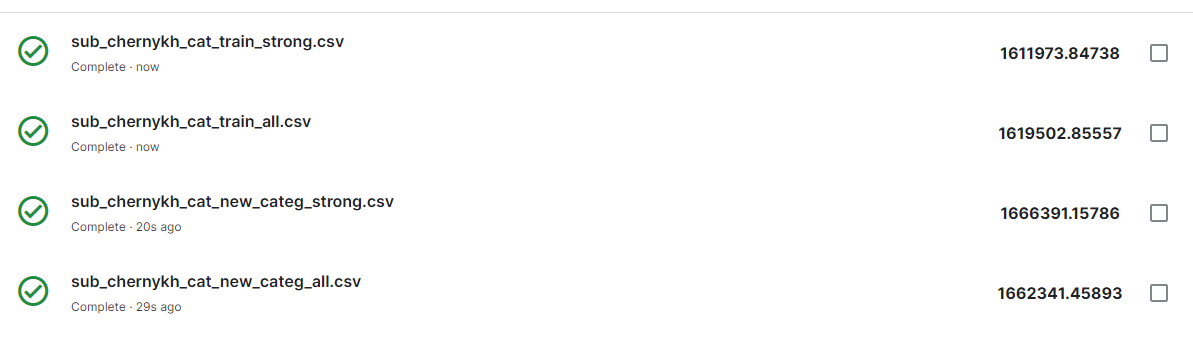

Попробовать только с full_sq, sub_area, full_all

In [238]:
last_exp = ['sub_area','full_sq','full_all']

In [246]:
X_train, X_test, y_train, y_test = train_test_split(cat_train[last_exp], cat_train.price_doc, random_state = SEED, test_size=0.18)

def objective_cat(trial):   
    param = {
        'iterations': trial.suggest_categorical('iterations', [900, 1000, 1100, 1200, 1300, 10000]), 
        'verbose': 0, 
        'random_seed': SEED,
        'loss_function': 'MAE',
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 4, 8),
        'eval_metric': 'MAE',
        'cat_features': ['sub_area'],
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.1, 0.15, 0.2]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 6, 7, 8])
    }
    model = CatBoostRegressor(**param)  
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    
    return MAE

# sampler=optuna.samplers.TPESampler(seed=SEED) нужен для повторения результатов при перезапуске
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))

# Здесь n_trials показывает, сколько раз будет построена модель со случайными параметрами

study_cat.optimize(objective_cat, n_trials=200)

print('Параметры, полученные при лучшей оценке:', study_cat.best_trial.params)

[I 2023-04-02 15:36:29,447] A new study created in memory with name: no-name-189fae55-137a-4202-a5b7-2ad48e675772
[I 2023-04-02 15:37:04,923] Trial 0 finished with value: 1619203.3651156742 and parameters: {'iterations': 1300, 'l2_leaf_reg': 5.654350795146094, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 0 with value: 1619203.3651156742.
[I 2023-04-02 15:40:38,390] Trial 1 finished with value: 1609928.5885114225 and parameters: {'iterations': 10000, 'l2_leaf_reg': 5.360139767818508, 'learning_rate': 0.1, 'max_depth': 7}. Best is trial 1 with value: 1609928.5885114225.
[I 2023-04-02 15:41:00,564] Trial 2 finished with value: 1613084.29726851 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.100771913808654, 'learning_rate': 0.2, 'max_depth': 8}. Best is trial 1 with value: 1609928.5885114225.
[I 2023-04-02 15:41:16,698] Trial 3 finished with value: 1656915.2190513741 and parameters: {'iterations': 900, 'l2_leaf_reg': 7.574010661605074, 'learning_rate': 0.01, 'max_depth': 6}. 

KeyboardInterrupt: ignored

завершил вручную, т.к слишком долго

In [249]:
last_exp

['sub_area', 'full_sq', 'full_all']

In [247]:
params = study_cat.best_trial.params


cat_clf = CatBoostRegressor(**params,verbose=False,cat_features=['sub_area'])
cat_clf.fit(cat_train[last_exp],cat_train['price_doc'])
cat_test['price_doc']=cat_clf.predict(cat_test[last_exp])
cat_test['id'] = cat_test.index
cat_test[['id', 'price_doc']].to_csv('sub_chernykh_cat_last_exp_cat_train.csv', index=None)

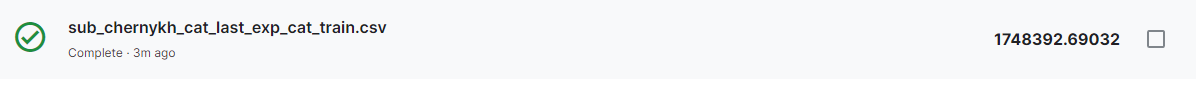

Сравнение с нилейной моделью (разница в 400 000 тысяч)

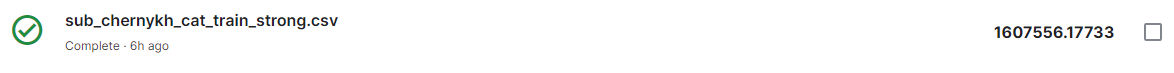
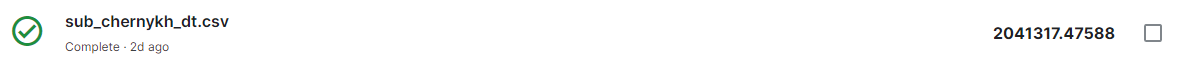